In [1]:
import numpy as np
import pandas as pd
from astropy.cosmology import Planck13 as cosmo
from astropy.io import fits
import fsps
from matplotlib.gridspec import GridSpec
from spec_tools import Source_present, Scale_model, Oldest_galaxy, Sig_int,Likelihood_contours, Median_w_Error_cont
from spec_exam import Gen_spec
from sim_engine import *
from spec_stats import Highest_density_region
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, interp2d
from glob import glob
import seaborn as sea
import os
from grizli import multifit
from grizli import model
from C_full_fit import Gen_spec2, Chi_Squared
from C_sim_test import Gen_sim, F_lam_per_M
from prospect.models.transforms import logsfr_ratios_to_masses

import dynesty
from dynesty import plotting as dyplot
from dynesty.utils import quantile as _quantile
from scipy.ndimage import gaussian_filter as norm_kde

import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
R = robjects.r
pandas2ri.activate()

from time import time
sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

if hpath == '/Users/Vince.ec/':
    dpath = '/Volumes/Vince_research/Data/' 
    
else:
    dpath = hpath + 'Data/' 

In [2]:
def Get_posterior(results, entry):
    sample = results.samples[:, entry]
    logwt = results.logwt
    logz = results.logz
    
    
    weight = np.exp(logwt - logz[-1])

    q = [0.5 - 0.5 * 0.999999426697, 0.5 + 0.5 * 0.999999426697]
    span = _quantile(sample.T, q, weights=weight)

    s = 0.02

    bins = int(round(10. / 0.02))
    n, b = np.histogram(sample, bins=bins, weights=weight,
                        range=np.sort(span))
    n = norm_kde(n, 10.)
    x0 = 0.5 * (b[1:] + b[:-1])
    y0 = n
    
    return x0, y0 / np.trapz(y0,x0)

In [8]:
specz = 1.25
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

LBT = (10**agebins.T[1][::-1][0] - 10**agebins.T[0][::-1])*1E-9
time_per_bin = np.diff(10**agebins, axis=-1)[:,0]

# Compare bounding method for tab to delay and tab to tab

In [18]:
## logL

tdL = []
ttL = []
tt_lbL = []
tt_smL = []
tt_ssL = []

for i in range(1,6,1):
    bfit = np.load('../data/bestfits/sim_test_tab_to_delay_multi_{0}_bfit.npy'.format(i))
    tdL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_tab_to_tab_{0}_bfit.npy'.format(i))
    ttL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_tab_to_tab_lessbin_{0}_bfit.npy'.format(i))
    tt_lbL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_tab_to_tab_sclmass_{0}_bfit.npy'.format(i))
    tt_smL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_tab_to_tab_sclspec_{0}_bfit.npy'.format(i))
    tt_ssL.append(bfit[-1])


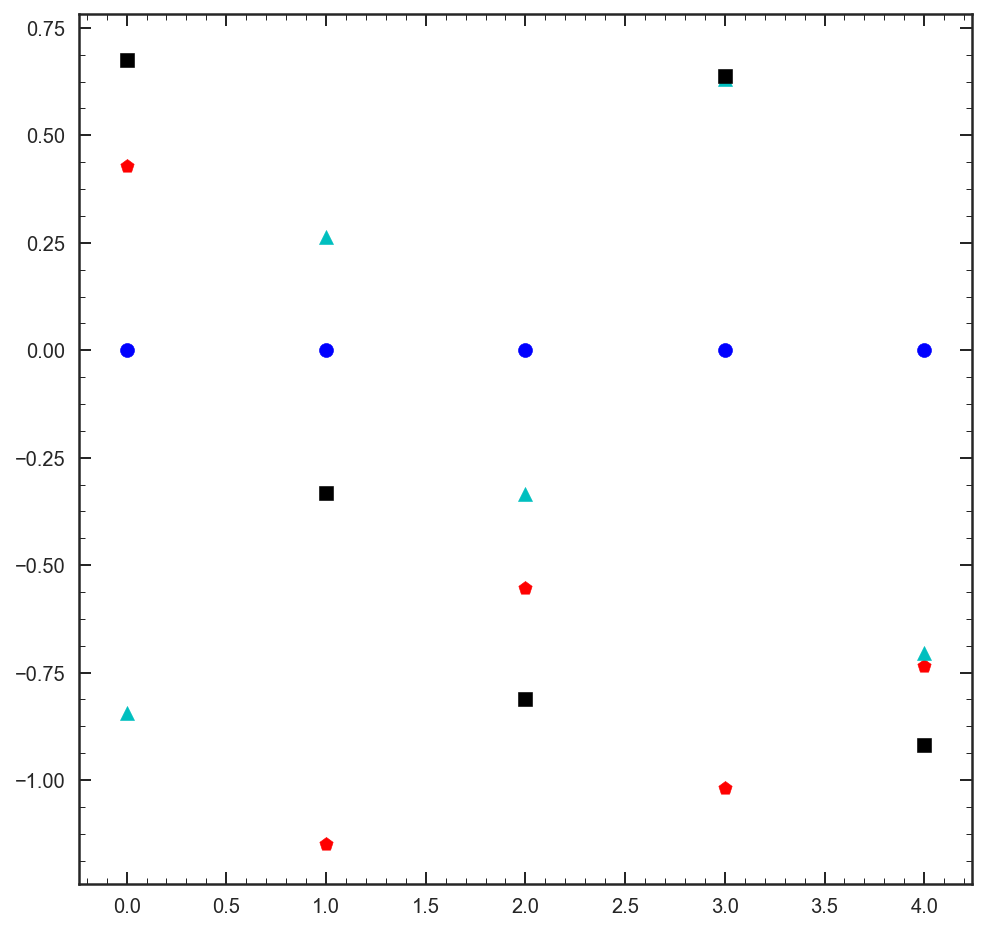

In [7]:
plt.figure(figsize=[8,8])
plt.scatter(range(len(tdL)),np.abs(tdL) - np.abs(tdL),color='b', marker = 'o')
plt.scatter(range(len(ttL)),np.abs(ttL) - np.abs(tdL),color='r', marker = 'p')
plt.scatter(range(len(tt_lbL)),np.abs(tt_lbL) - np.abs(tdL),color='c', marker = '^')
# plt.scatter(range(len(tt_smL)),np.abs(tt_smL) - np.abs(tdL),color='g', marker = '*')
plt.scatter(range(len(tt_ssL)),np.abs(tt_ssL) - np.abs(tdL),color='k', marker = 's')

# plt.plot([-155,-120],[-155,-120])

In [9]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.8), sfh = 3, dust_type = 1)
sp.params['compute_light_ages'] = True

tab_sfh = np.array([0.9, 0.3, 0.025, 0.001, 0.0001, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.set_tabular_sfh(LBT,tab_sfh)

lwa_tab = sp.get_mags(tage = 4.25, bands=['sdss_g'])
    
sp.params['compute_light_ages'] = False

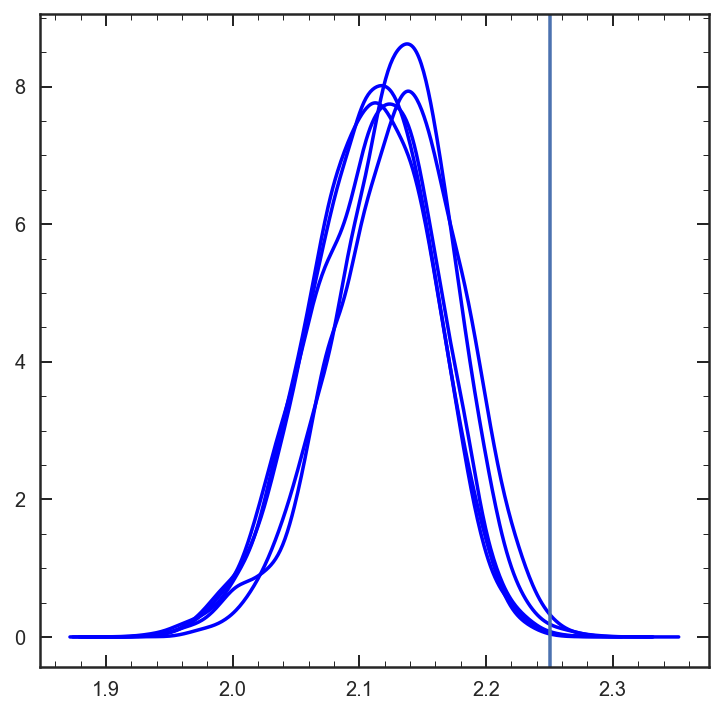

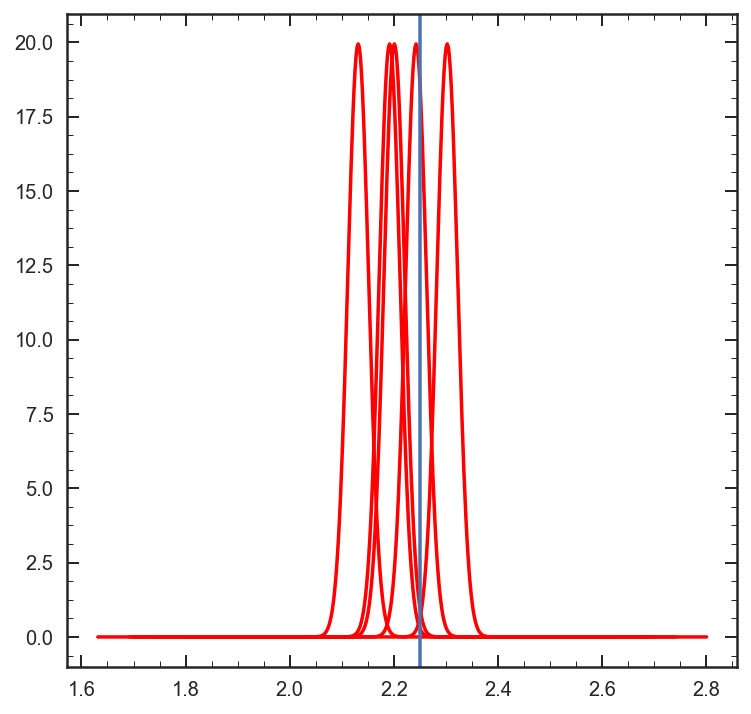

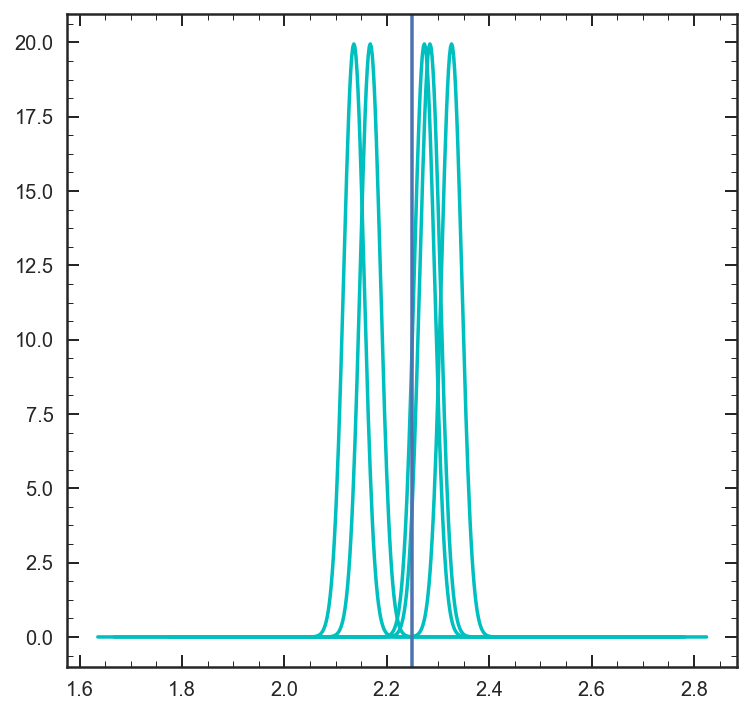

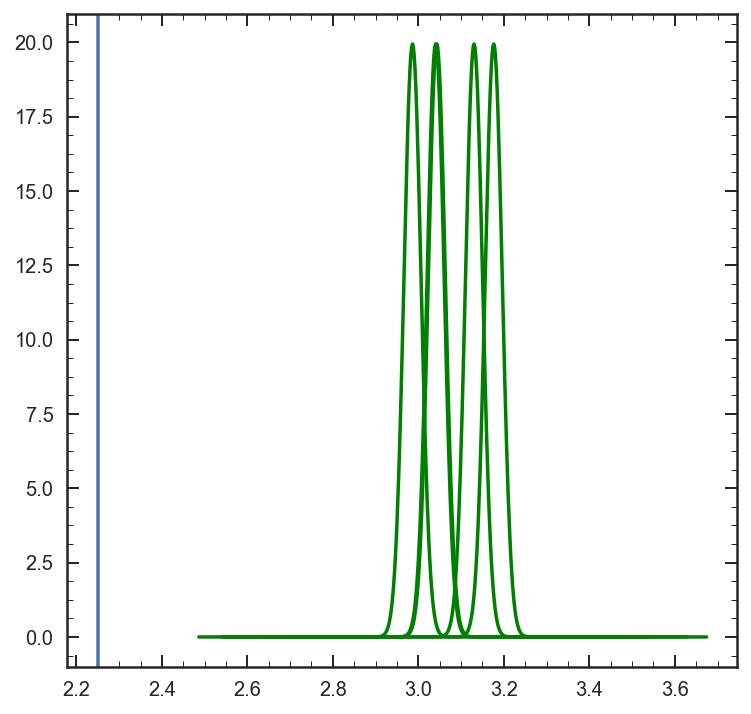

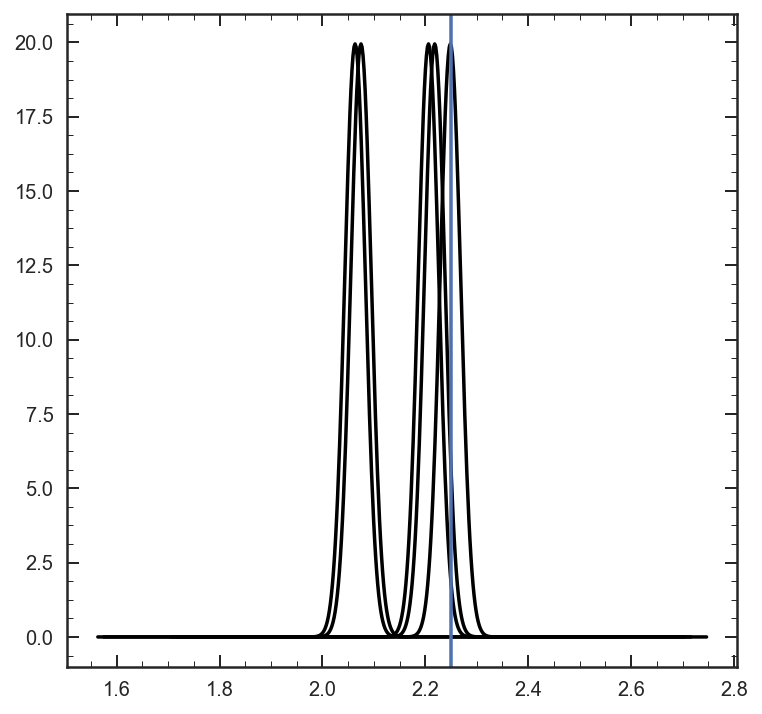

In [11]:
plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'b')
plt.axvline(lwa_tab)

plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'r')
plt.axvline(lwa_tab)

plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_lessbin_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'c')
plt.axvline(lwa_tab)
    
plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_sclmass_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'g')
plt.axvline(lwa_tab)
    
plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'k')
plt.axvline(lwa_tab)

# Compare bounding method for delay to tab

In [12]:
dtL = []
dt_lbL = []
dt_smL = []
dt_ssL = []

for i in range(1,6,1):   
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_{0}_bfit.npy'.format(i))
    dtL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_lessbin_{0}_bfit.npy'.format(i))
    dt_lbL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_sclmass_{0}_bfit.npy'.format(i))
    dt_smL.append(bfit[-1])
    
    bfit = np.load('../data/bestfits/sim_test_delay_to_tab_sclspec_{0}_bfit.npy'.format(i))
    dt_ssL.append(bfit[-1])

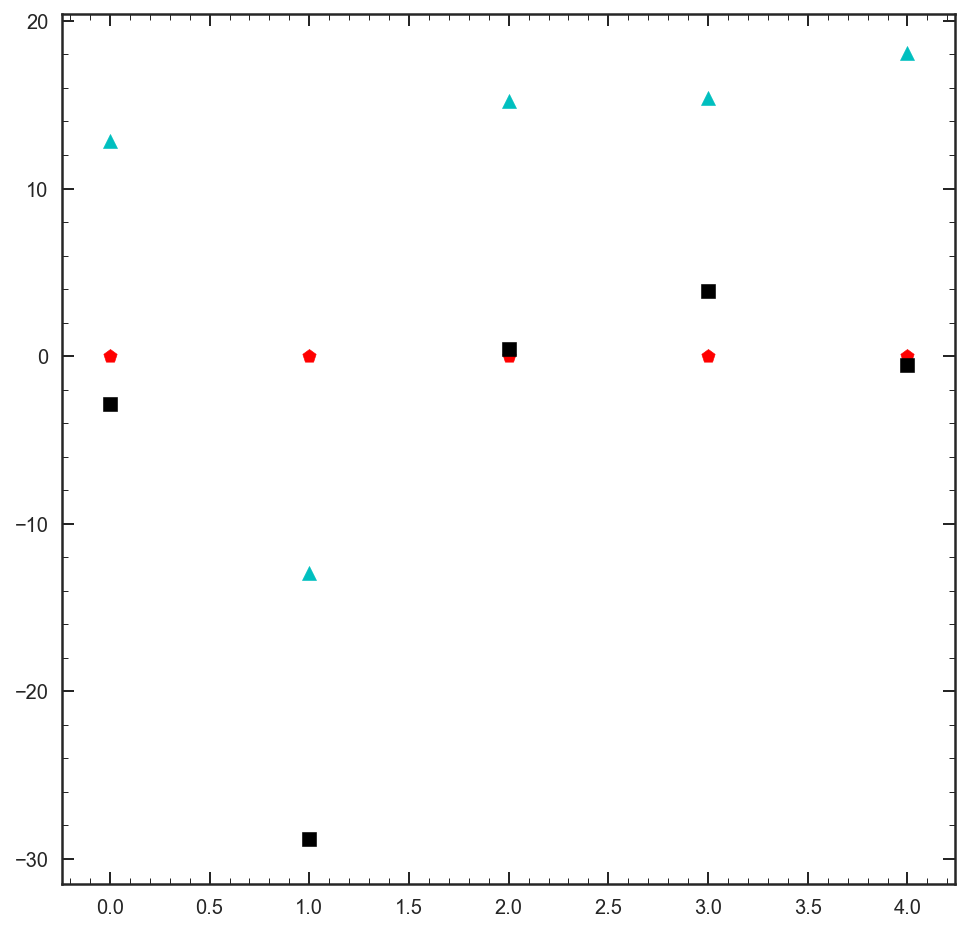

In [14]:
plt.figure(figsize=[8,8])
plt.scatter(range(len(dtL)),np.abs(dtL) - np.abs(dtL),color='r', marker = 'p')
plt.scatter(range(len(dt_lbL)),np.abs(dt_lbL) - np.abs(dtL),color='c', marker = '^')
# plt.scatter(range(len(dt_smL)),np.abs(dt_smL) - np.abs(dtL),color='g', marker = '*')
plt.scatter(range(len(dt_ssL)),np.abs(dt_ssL) - np.abs(dtL),color='k', marker = 's')

# plt.plot([-155,-120],[-155,-120])

In [15]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['compute_light_ages'] = True

sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

lwa_delay = sp.get_mags(tage = 4.25, bands=['sdss_g'])
    
sp.params['compute_light_ages'] = False

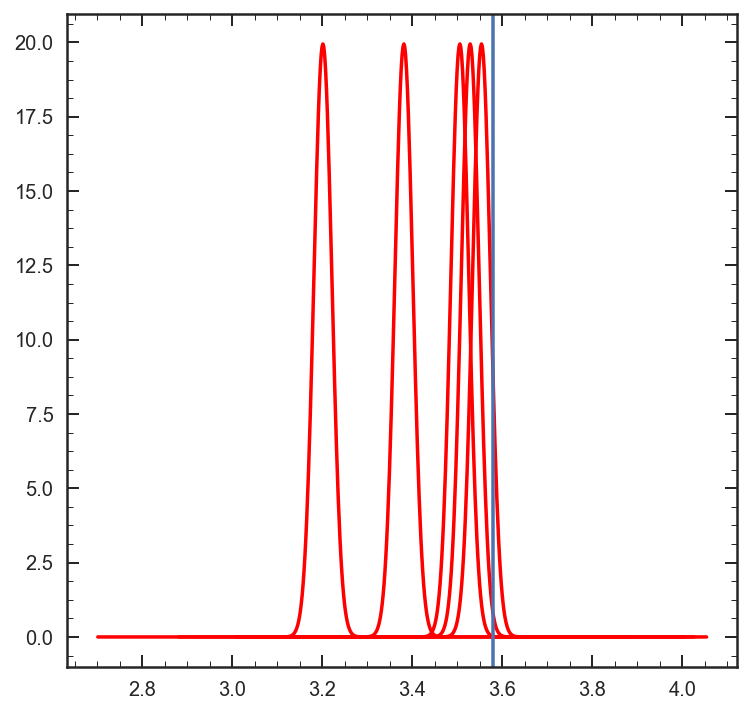

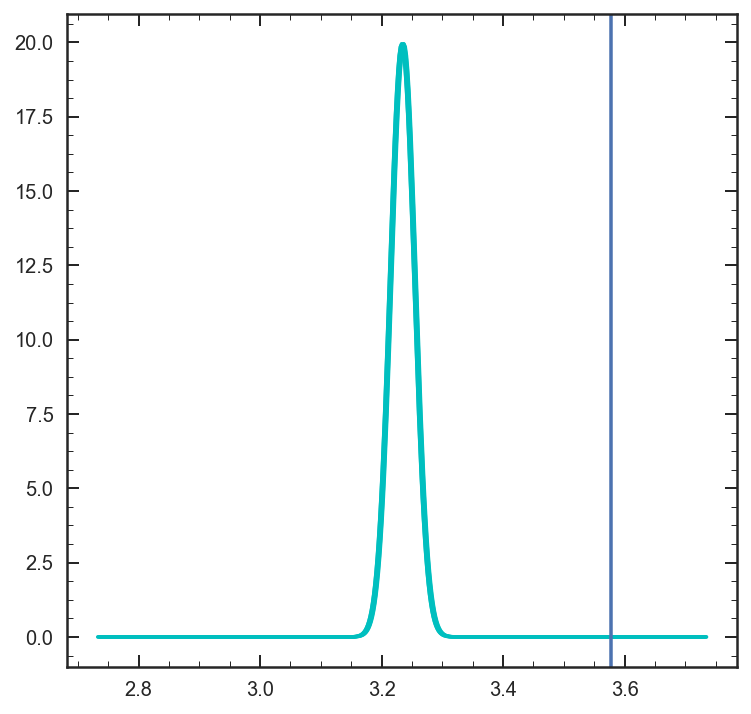

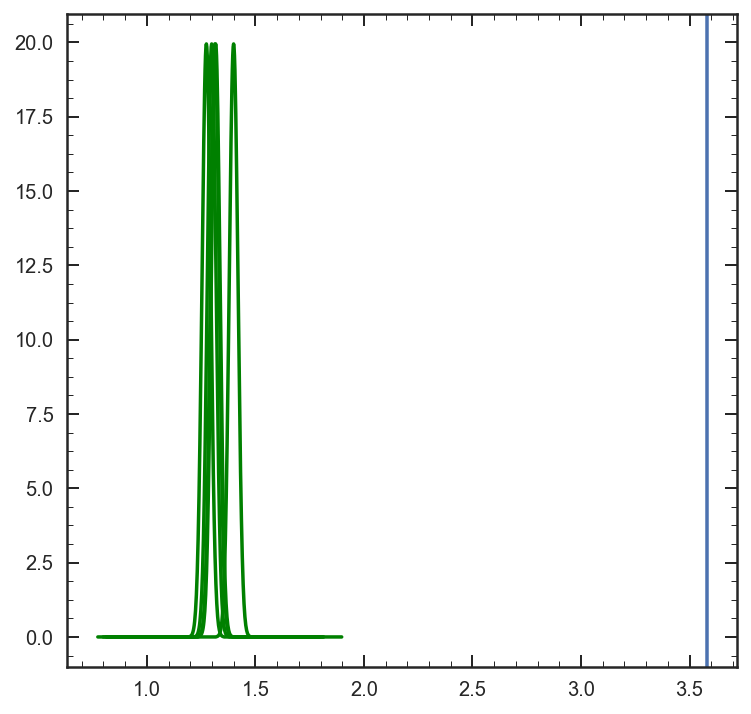

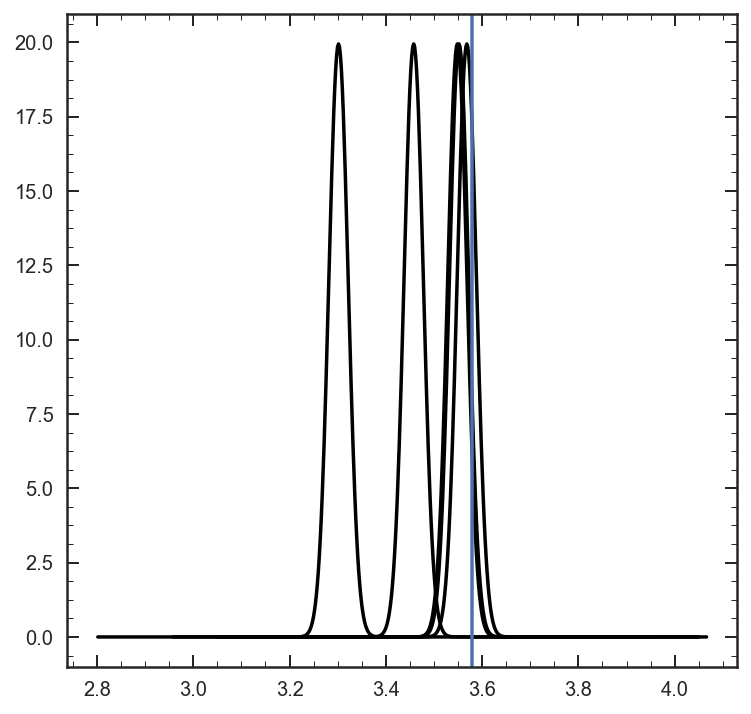

In [16]:
plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'r')
plt.axvline(lwa_delay)

plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'c')
plt.axvline(lwa_delay)
    
plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_sclmass_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'g')
plt.axvline(lwa_delay)
    
plt.figure(figsize=[6,6])
for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Plwa.npy'.format(i))
    plt.plot(t,pt,'k')
plt.axvline(lwa_delay)

# Compare td spec_fits

In [11]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2

tab_sfh = np.array([0.9, 0.3, 0.025, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
tab_Z = np.array([0.2, 1.0, 1.1, 1.0, 0.95, 0.9, 1.1, 1.0, 0.9, 0.8])*0.019

sp.set_tabular_sfh(LBT,tab_sfh, Z = tab_Z )

wave1, flux1 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc1 = sp.stellar_mass
 
D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = (10**11 / mass_perc1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

(2.8, 5)

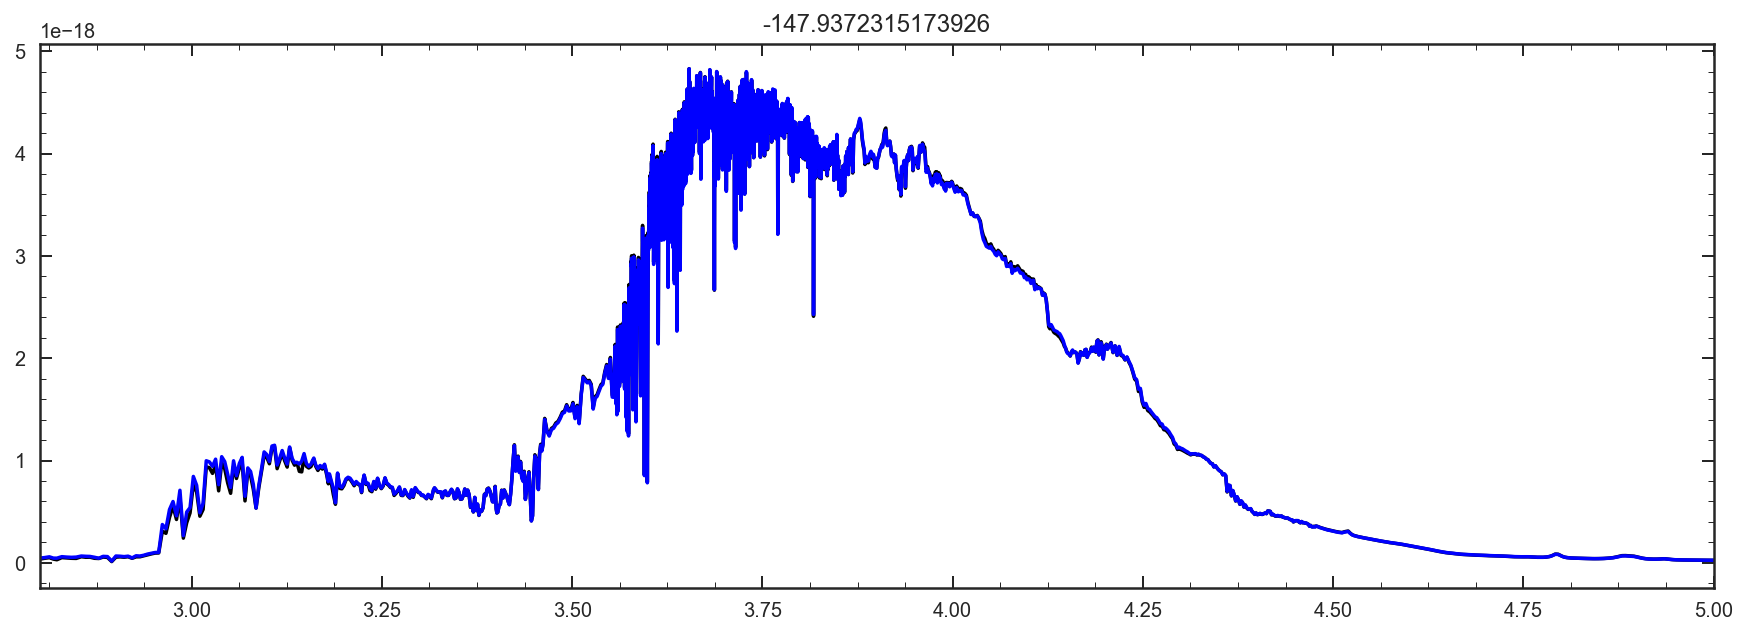

In [13]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)


bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
np.load('../data/bestfits/sim_test_tab_to_tab_continuity_prior_multi_1_bfit.npy')

sp.params['dust2'] = bfd
sp.params['dust1'] = bfd
sp.params['logzsol'] = np.log10(bfZ)
sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

wave, flux = sp.get_spectrum(tage = bft, peraa = True)

mp1 = sp.stellar_mass

D_l = cosmo.luminosity_distance(bfz).value # in Mpc
MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

plt.figure(figsize=[15,5])
plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
plt.plot(np.log10(wave), flux * MT,'b')
plt.title(logl)
plt.xlim(2.8,5)

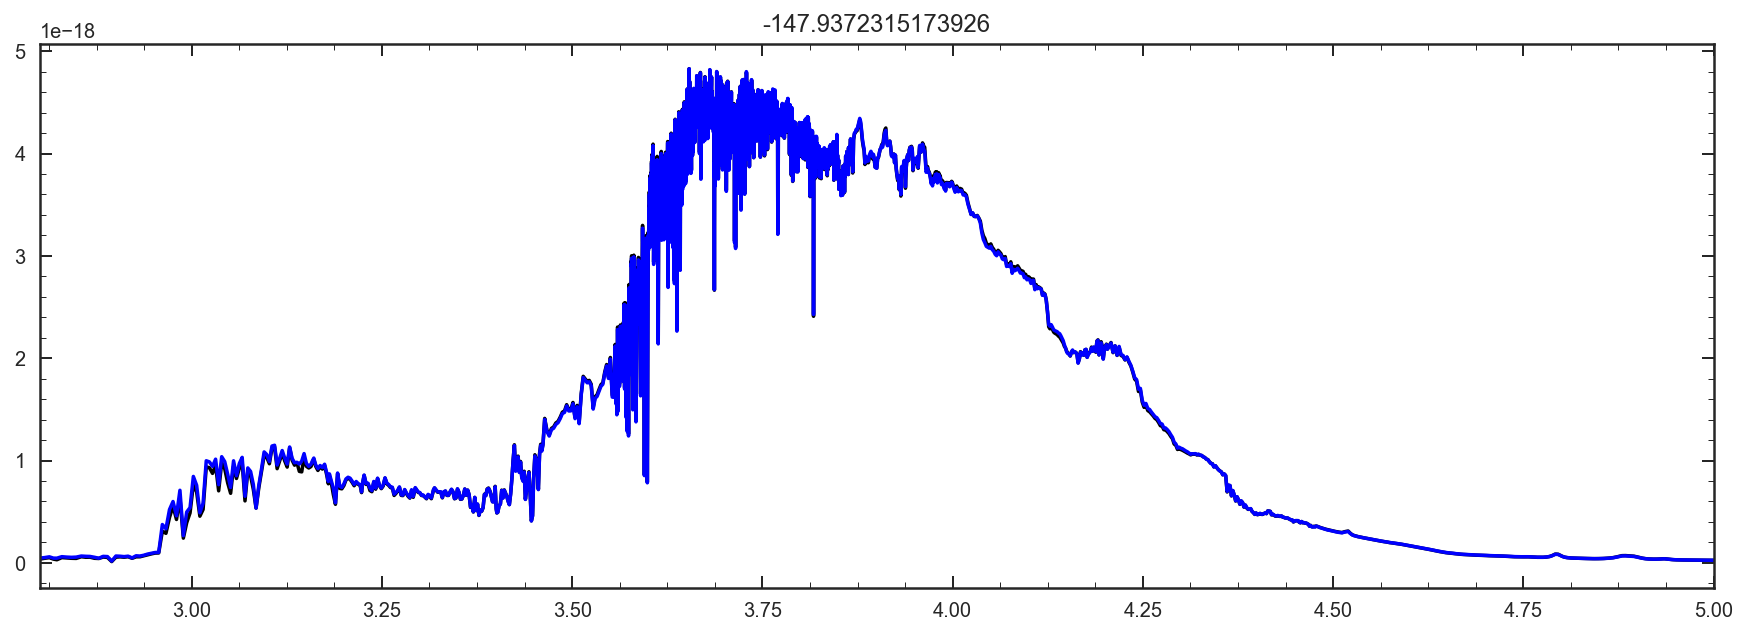

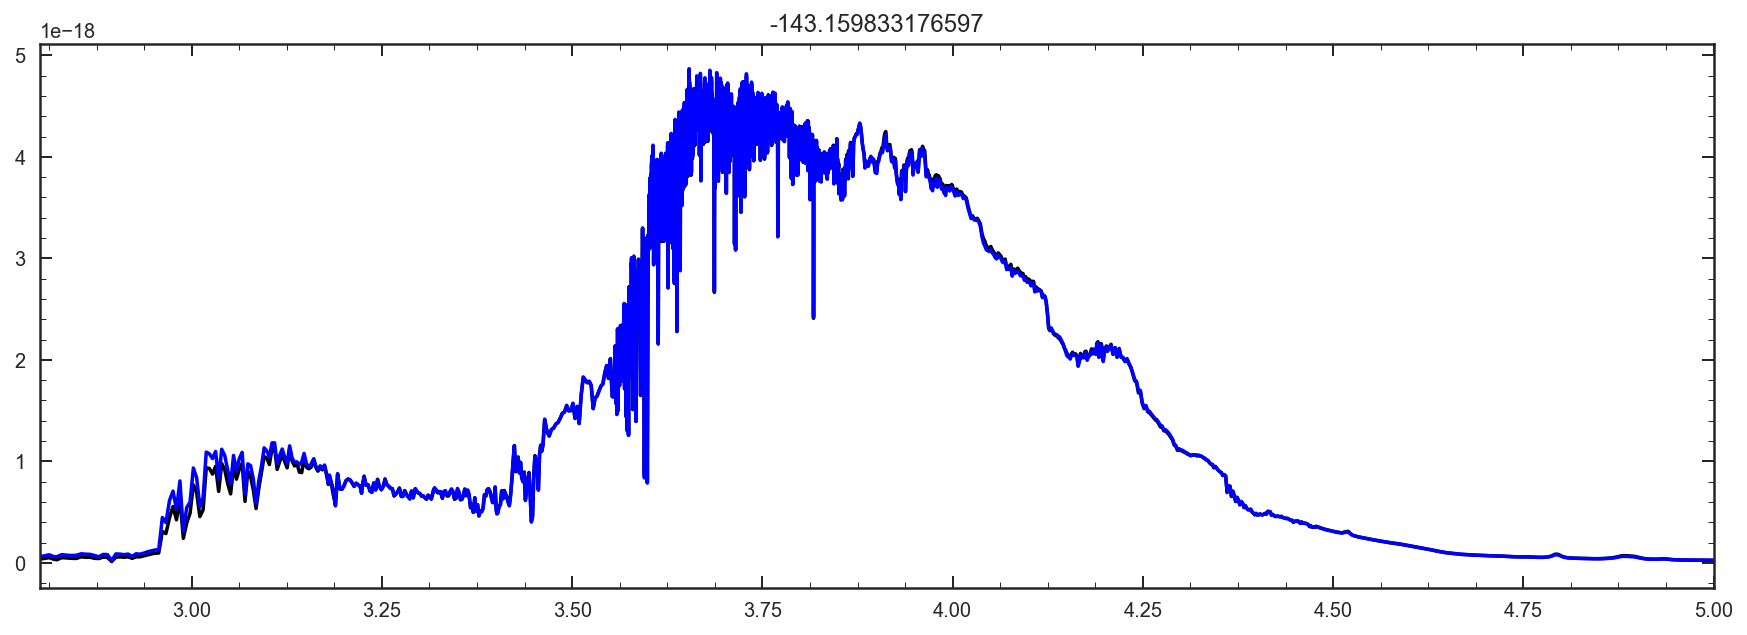

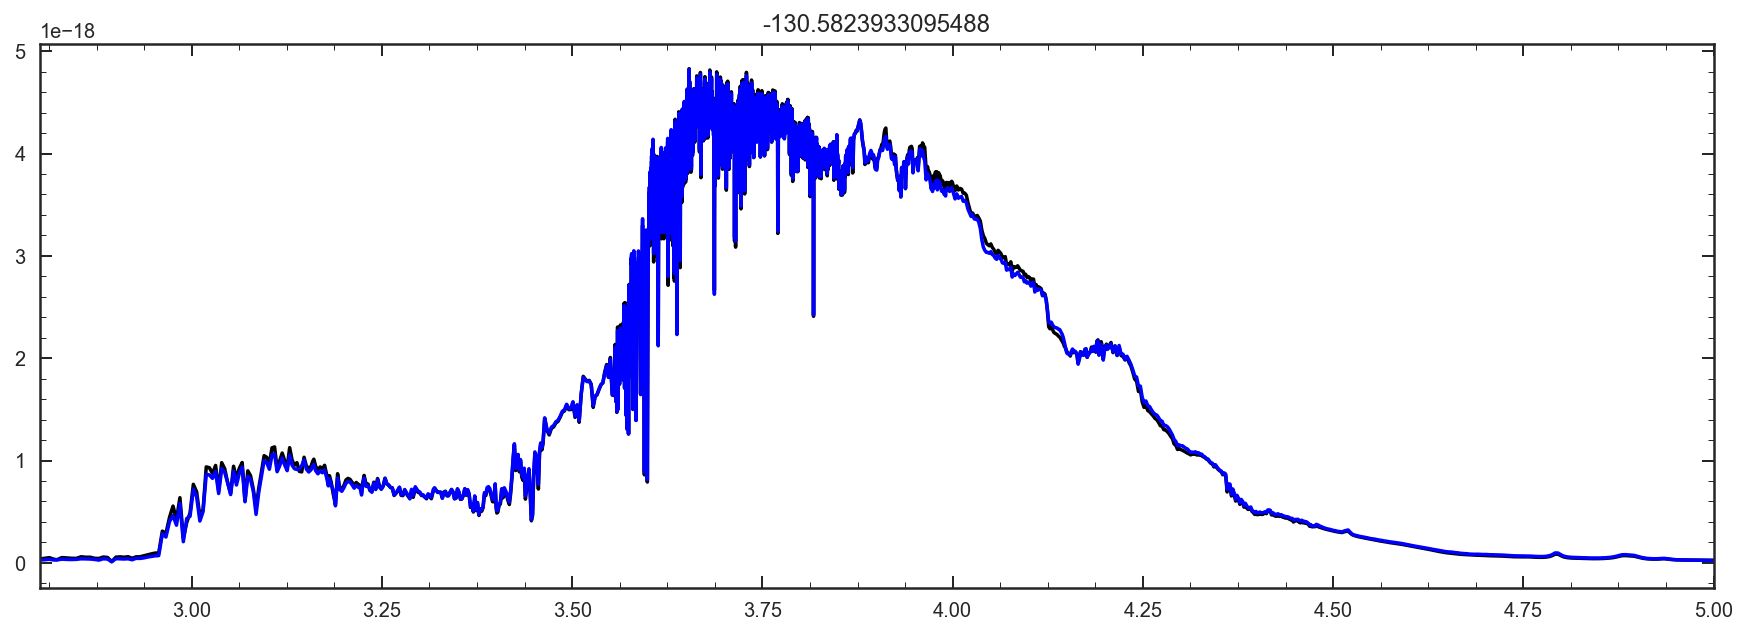

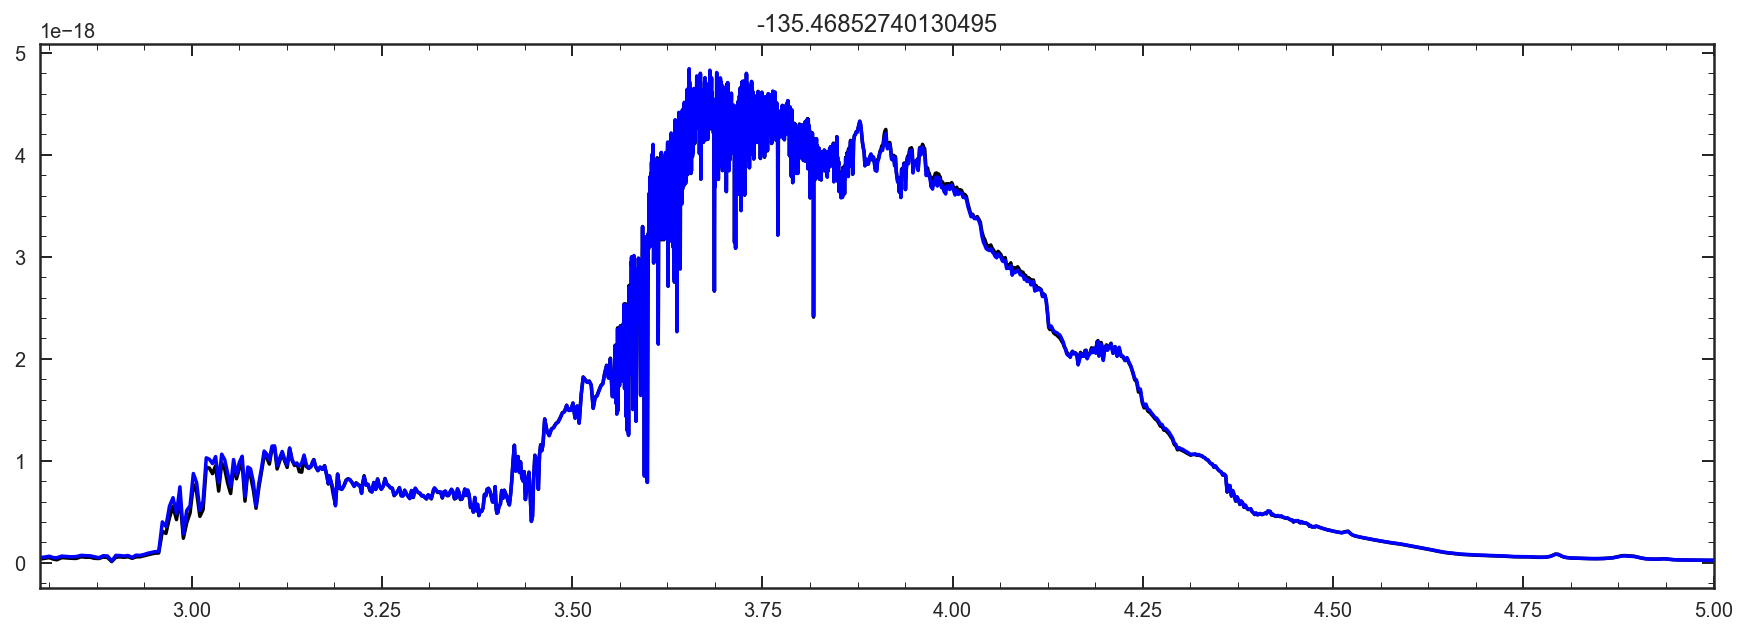

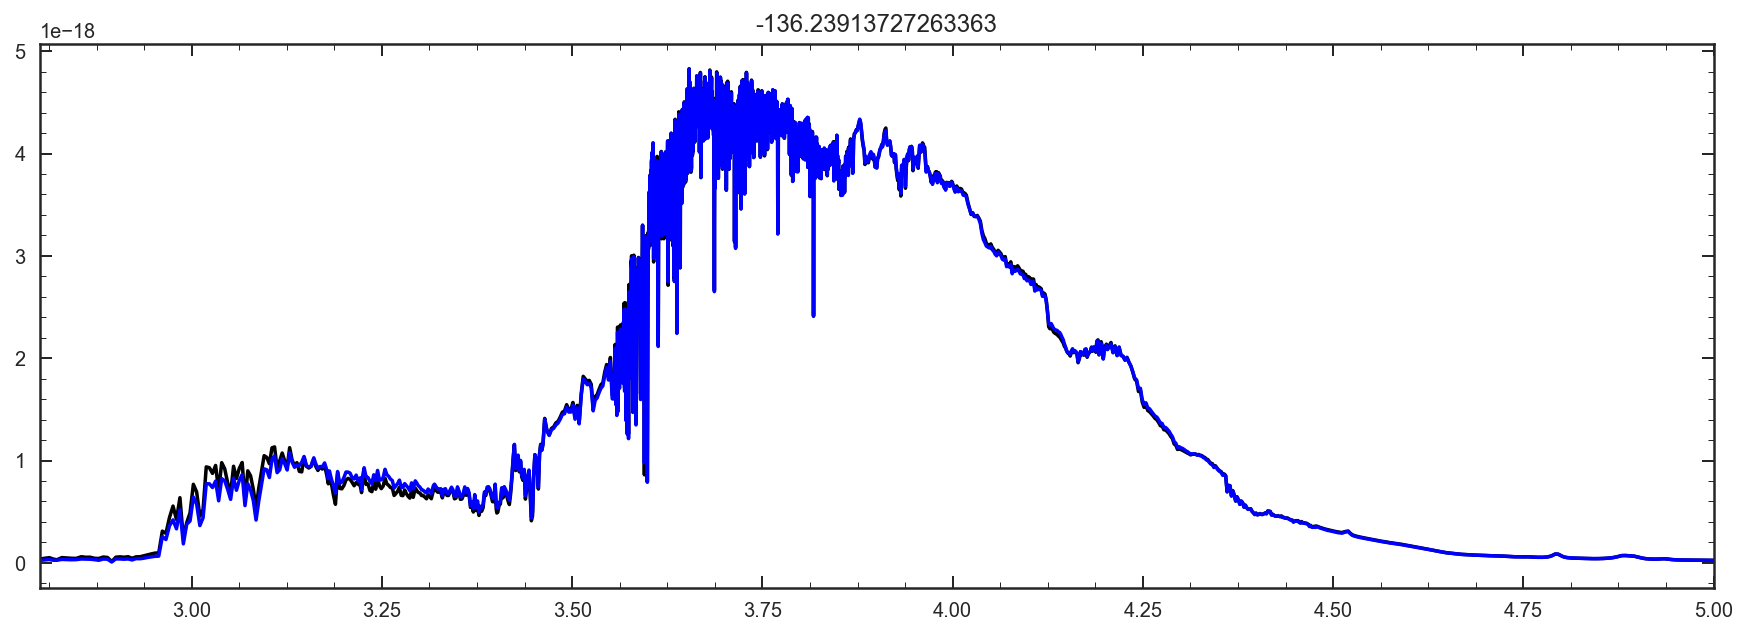

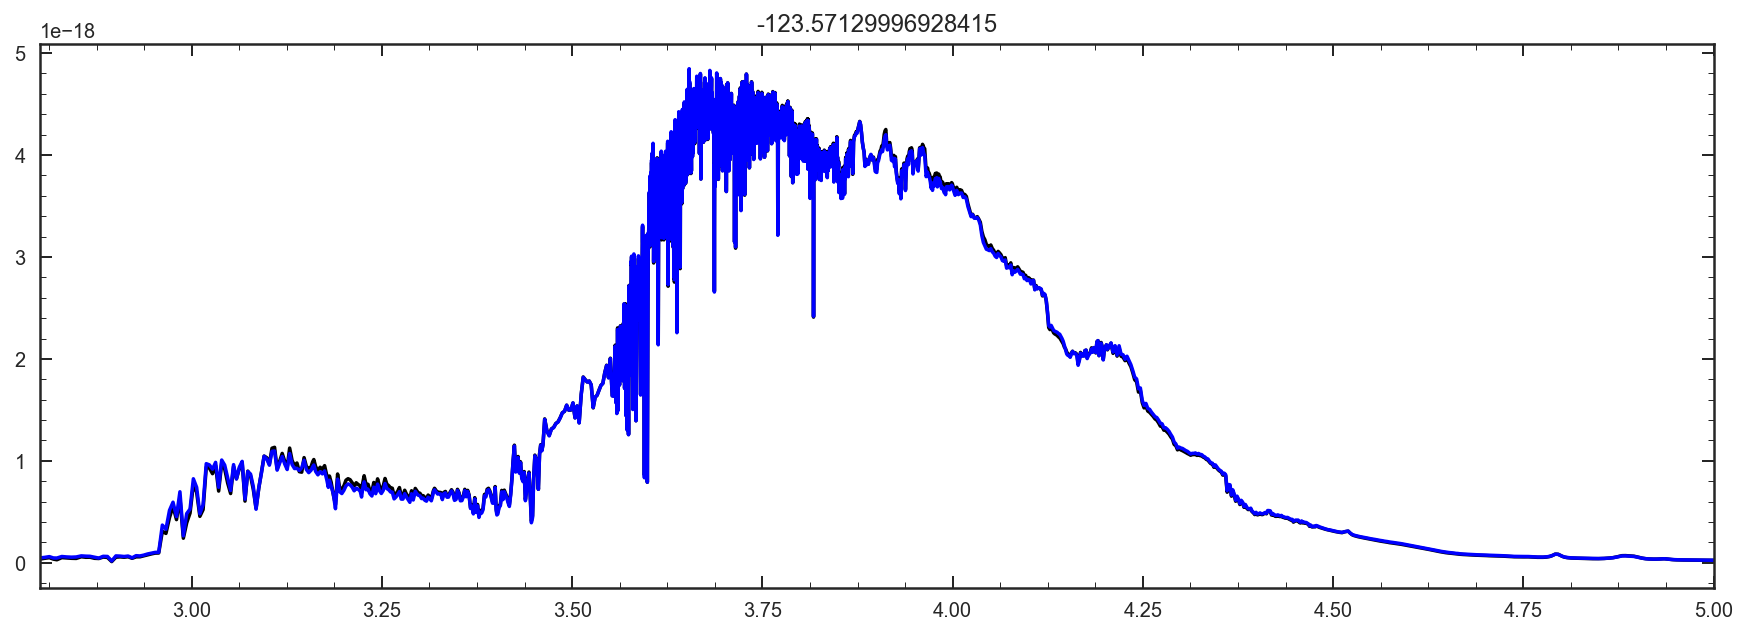

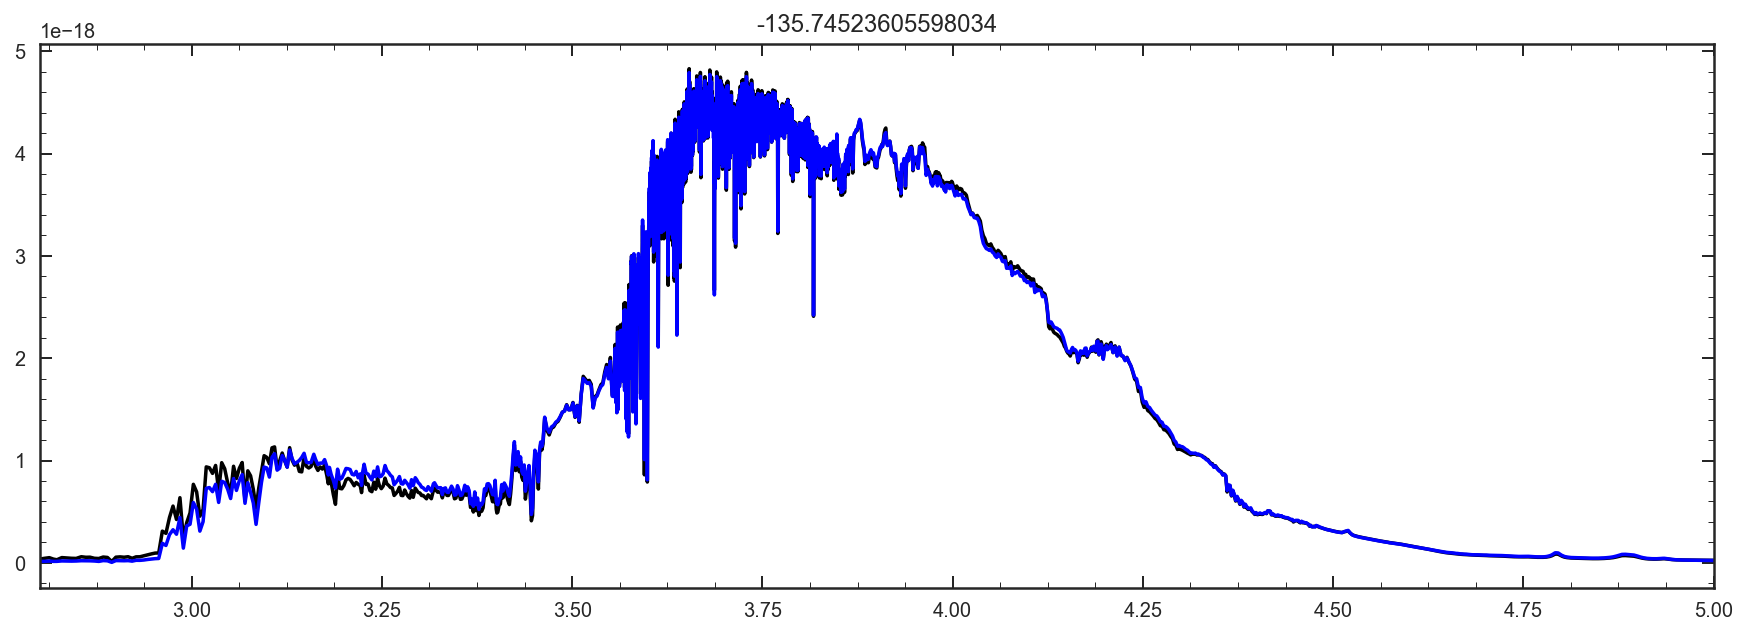

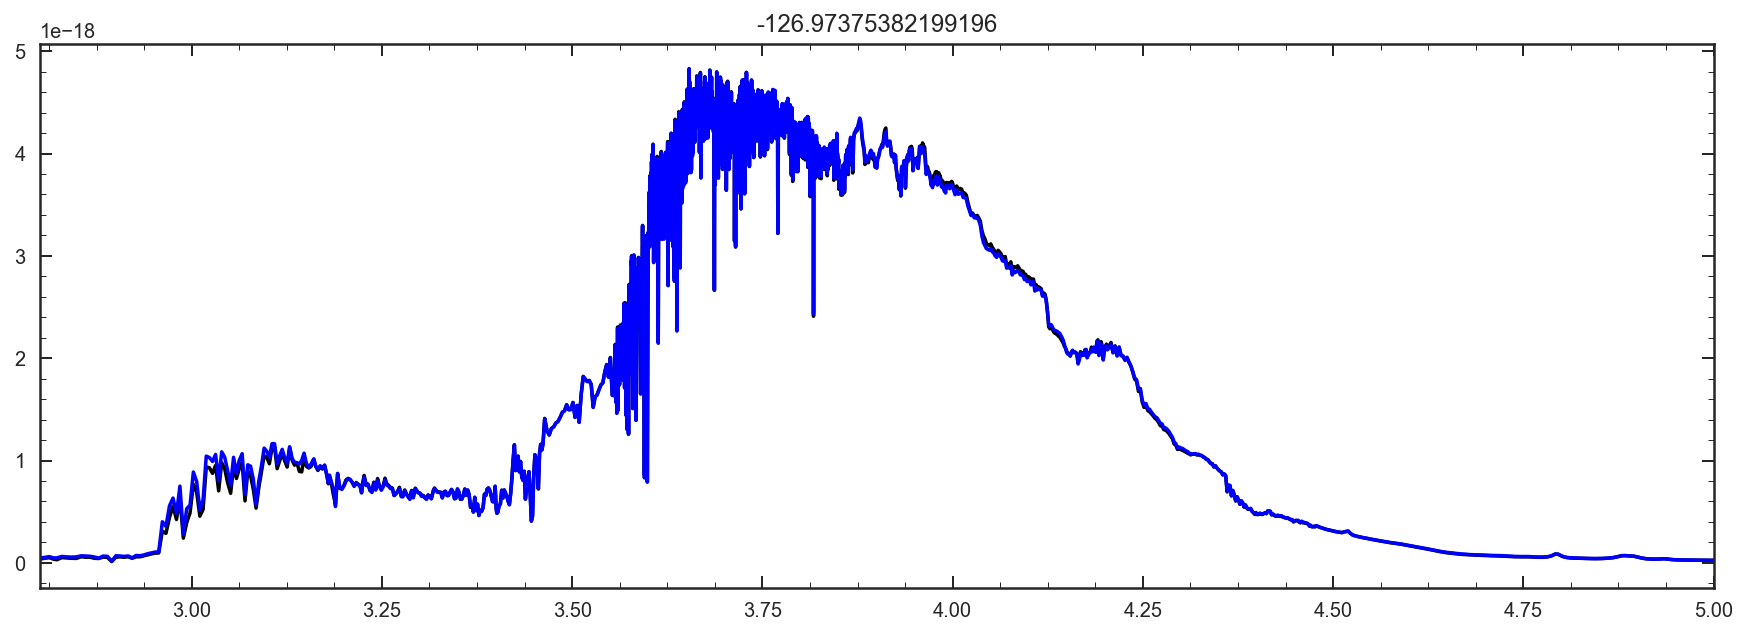

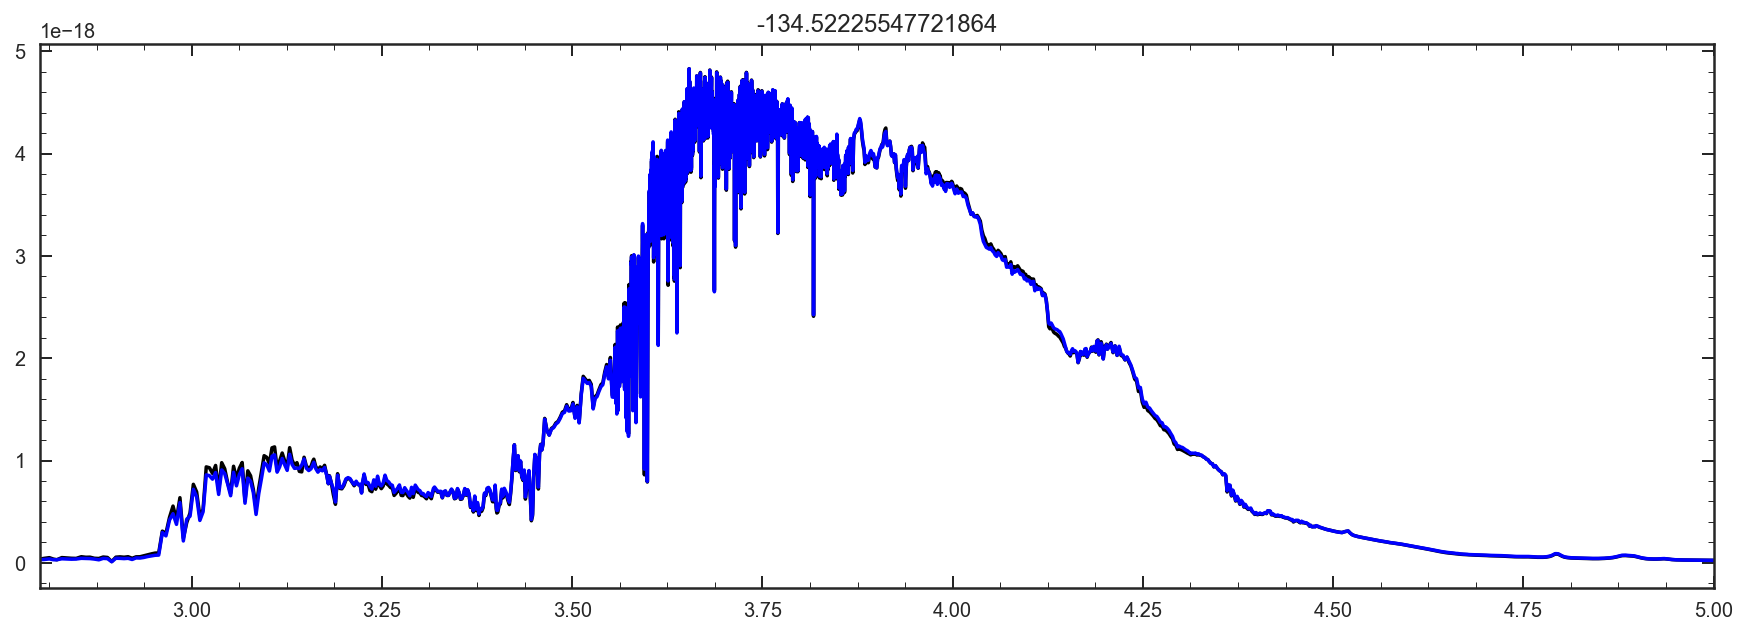

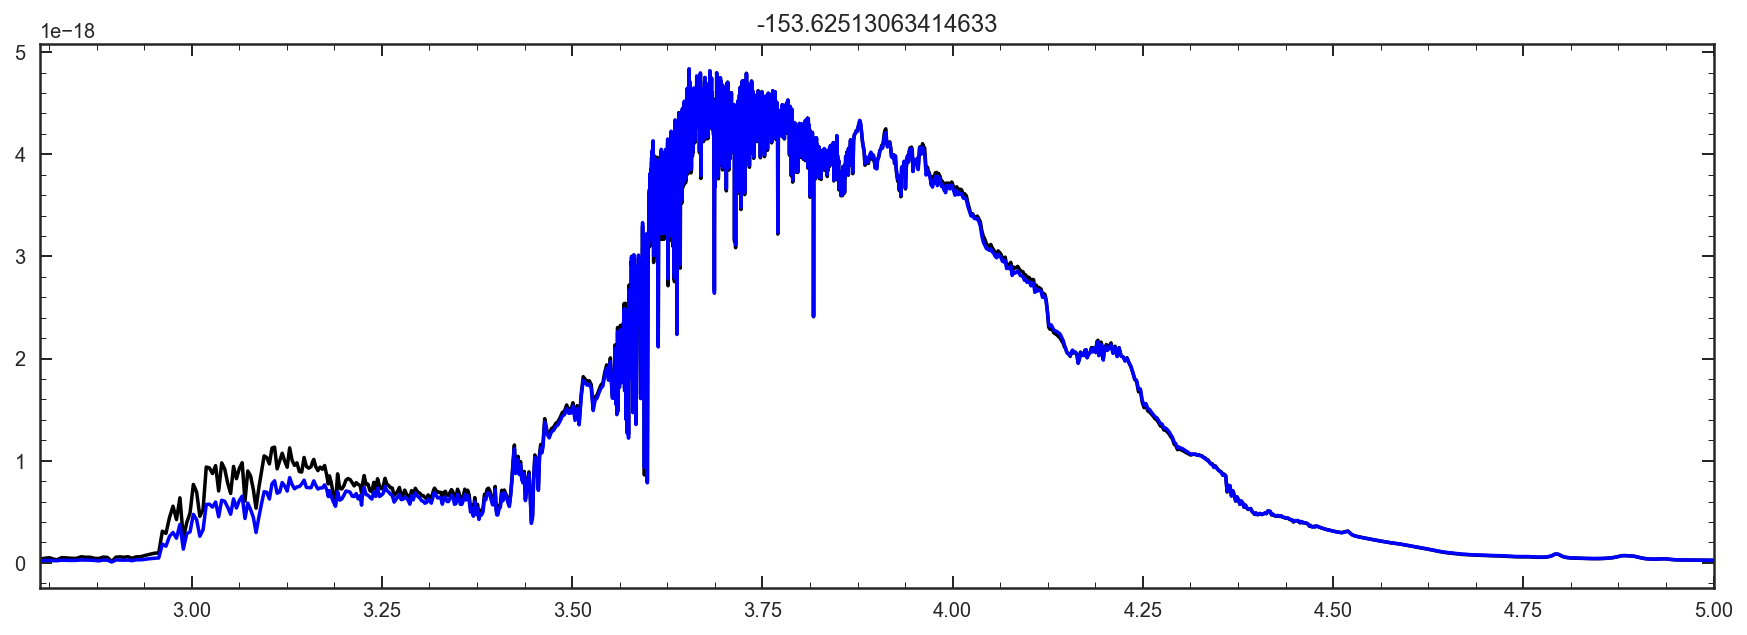

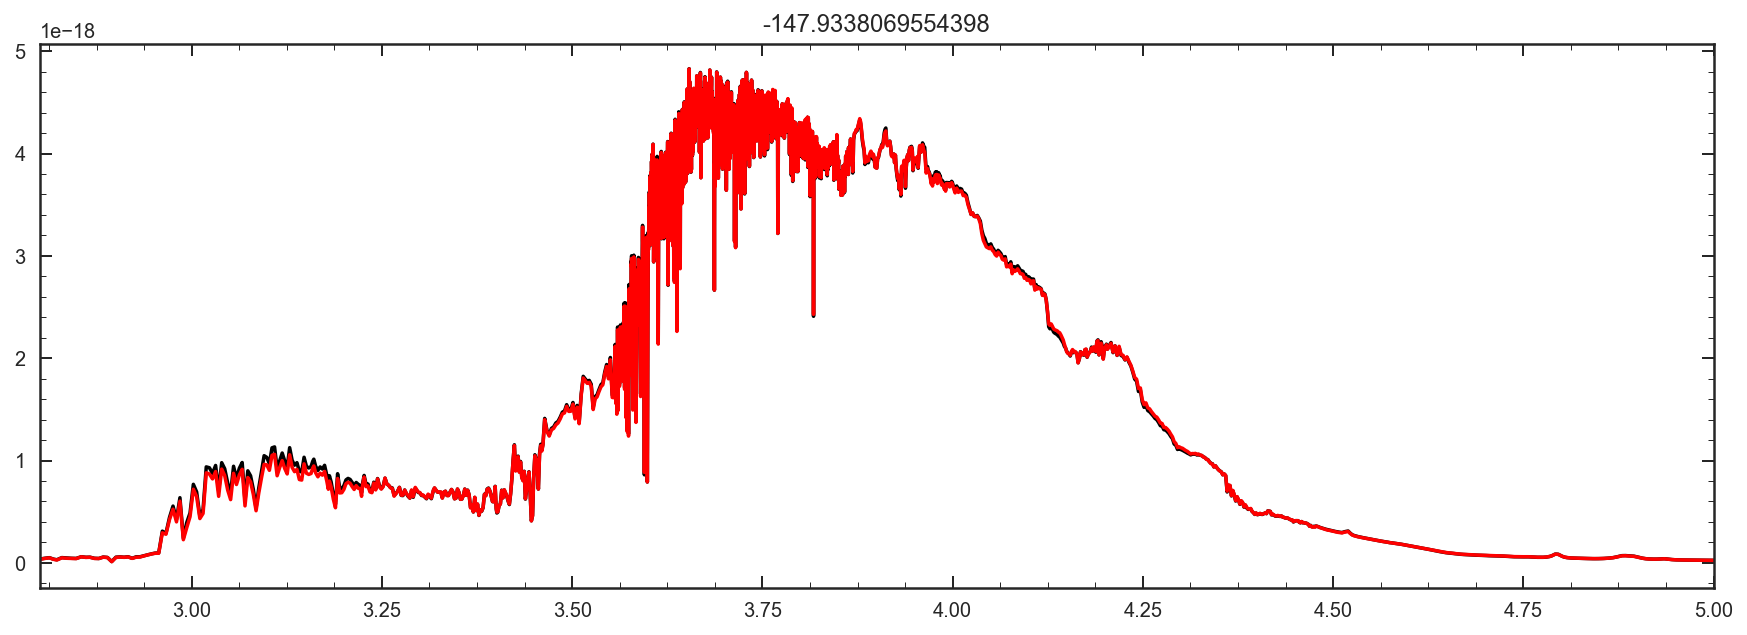

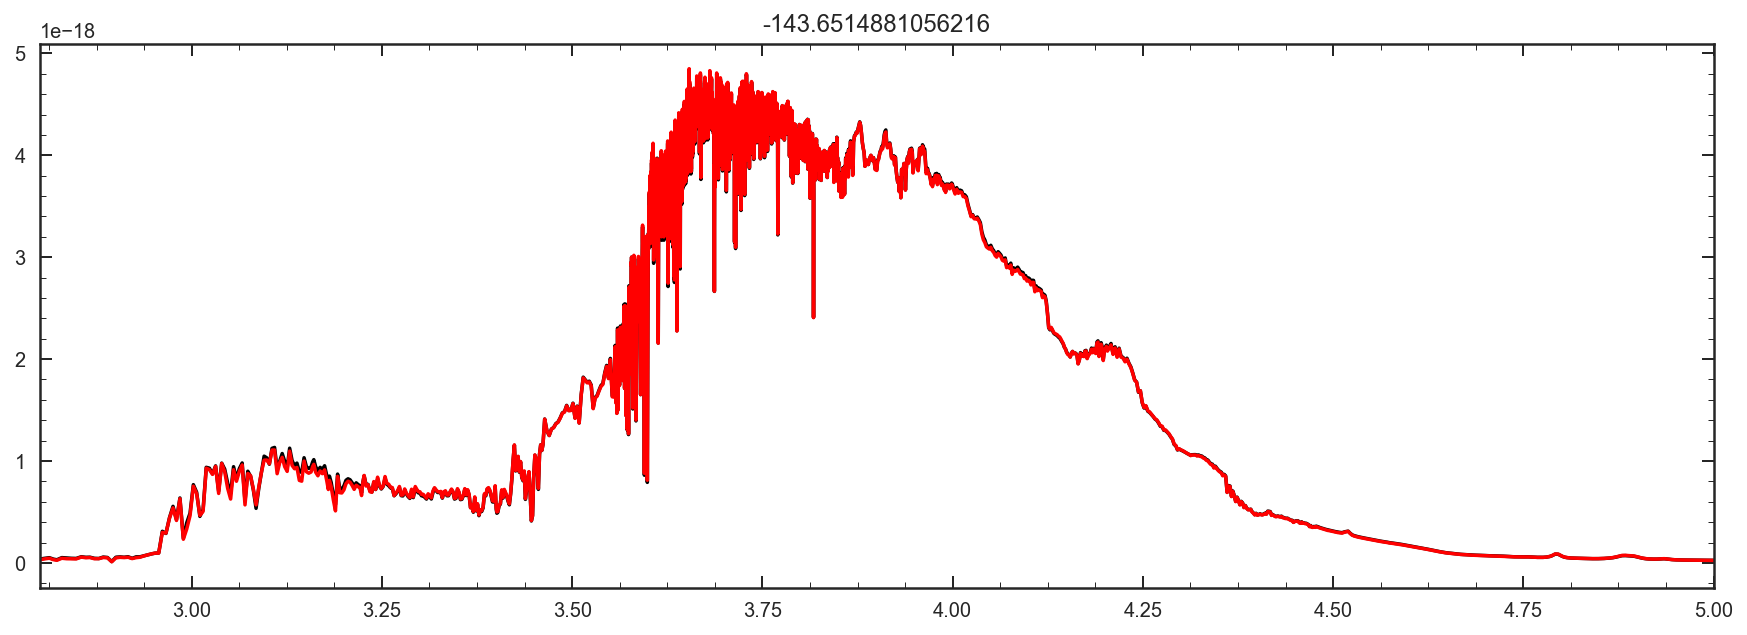

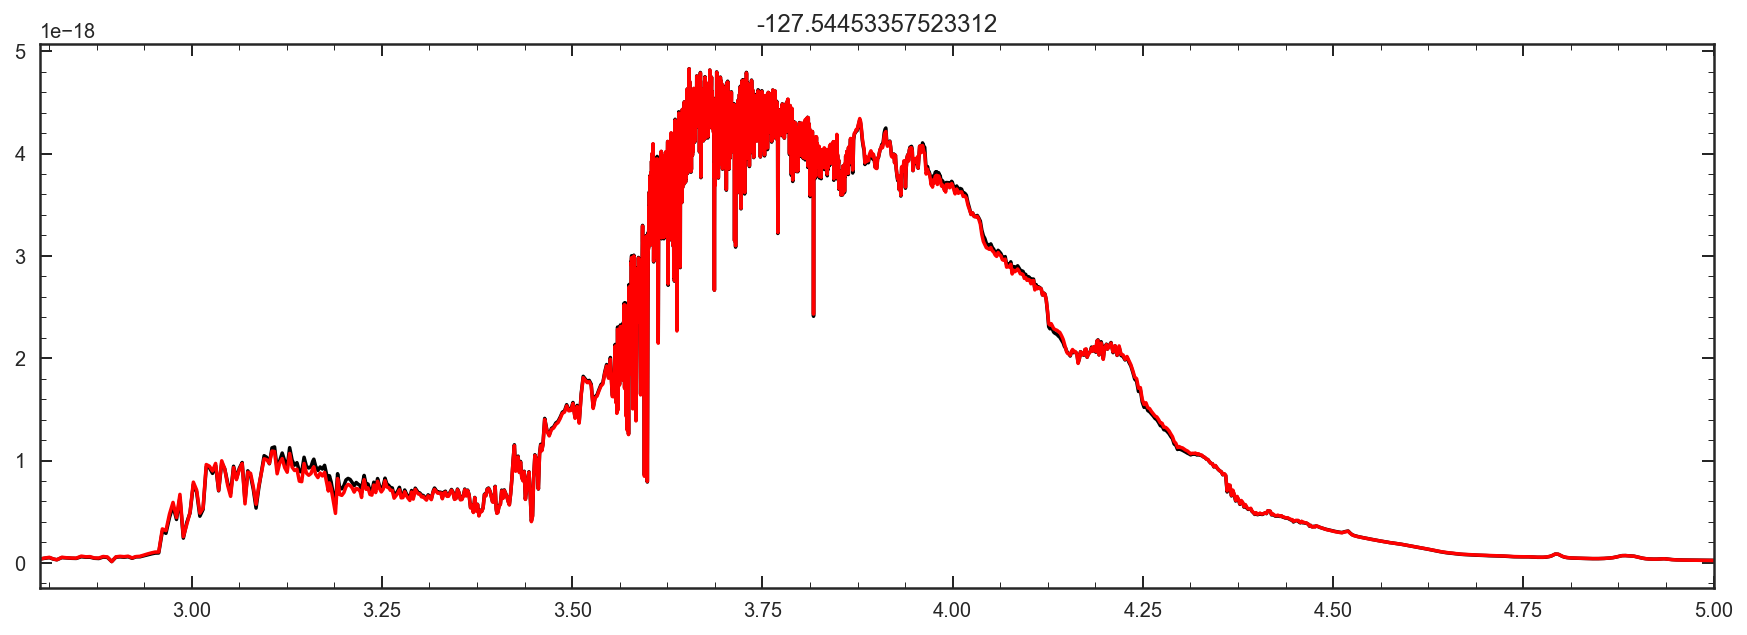

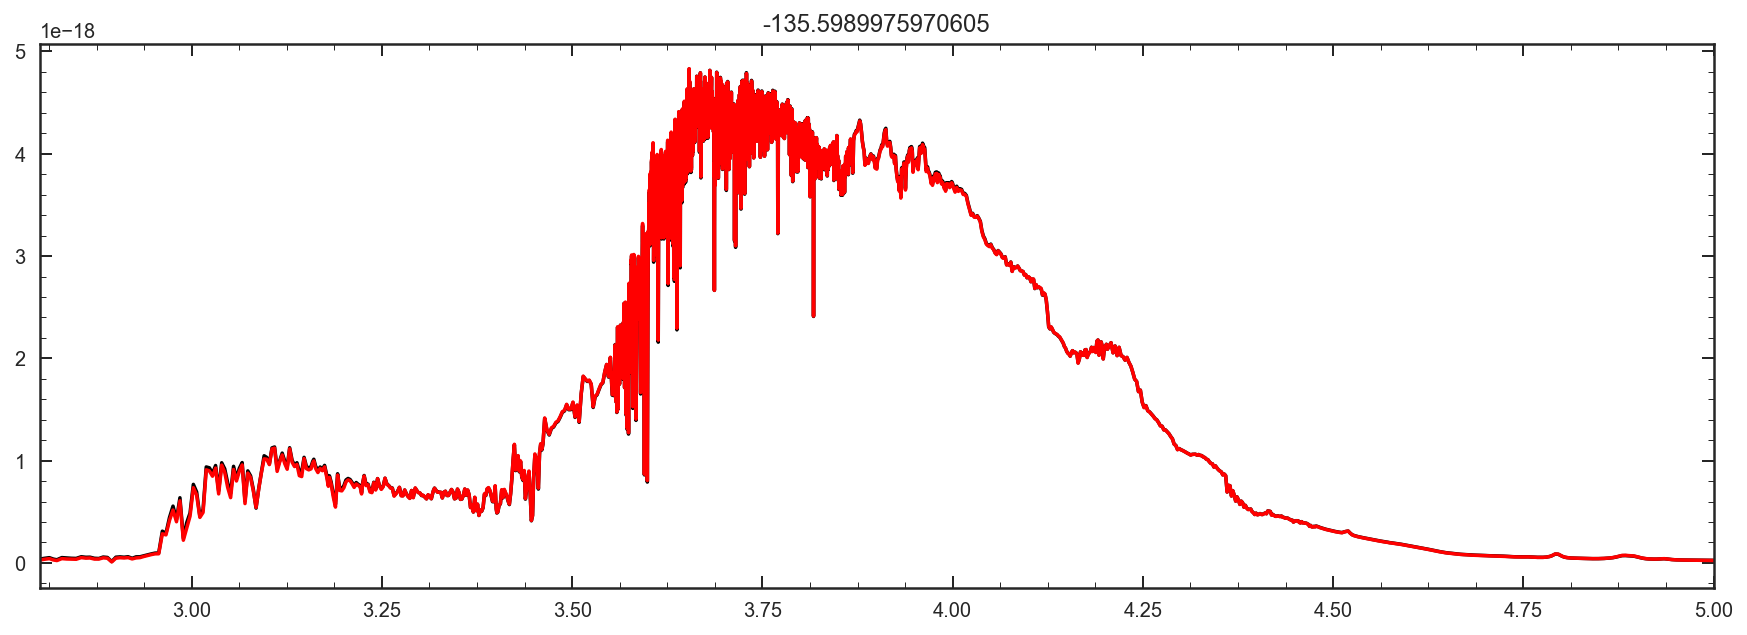

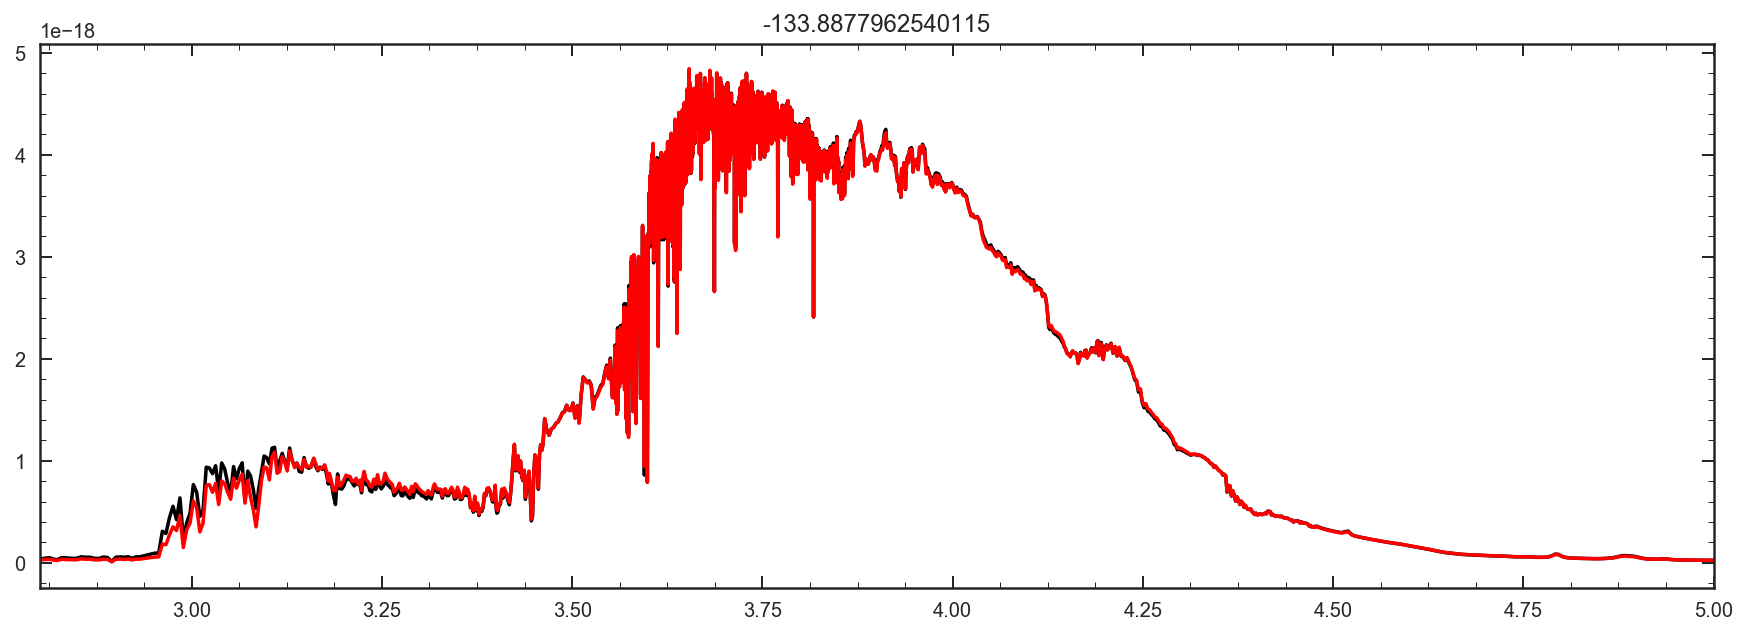

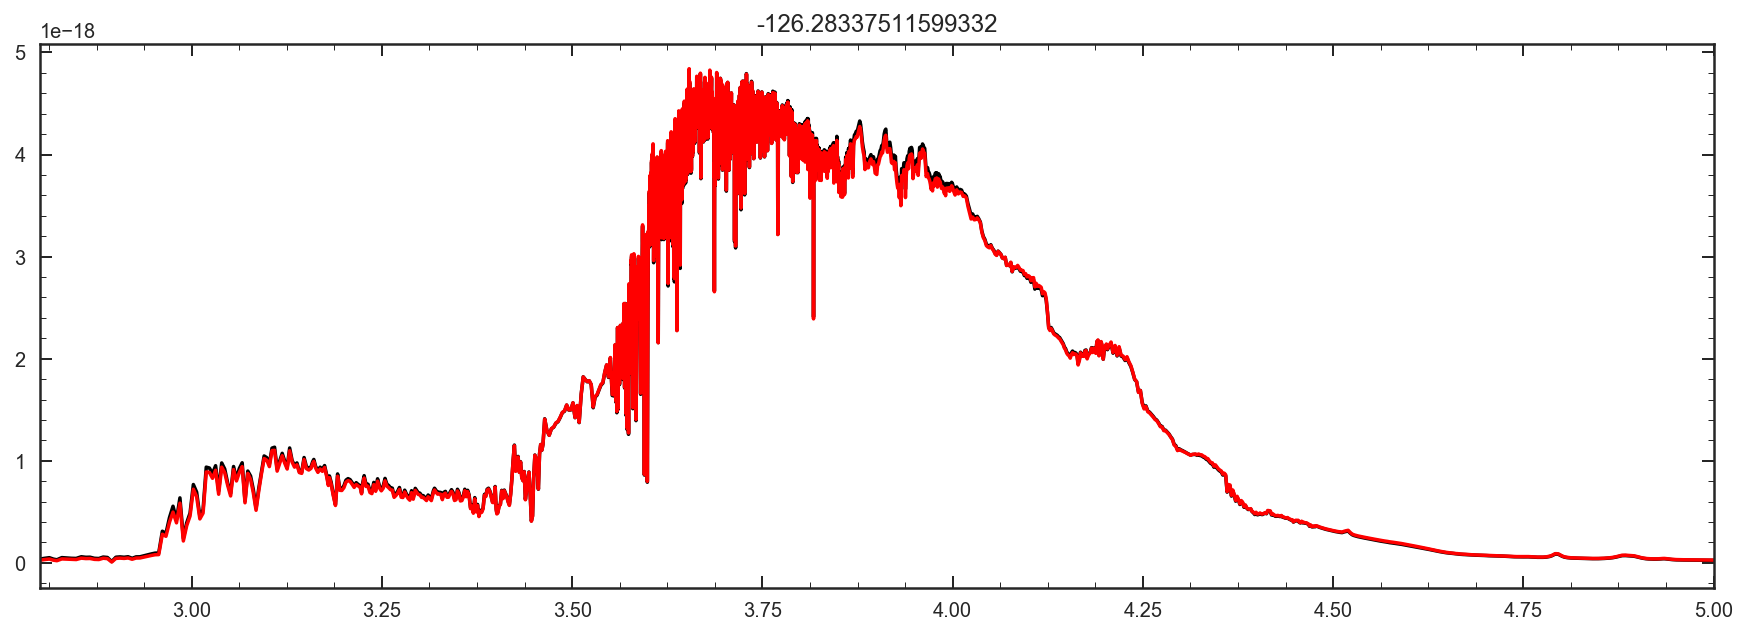

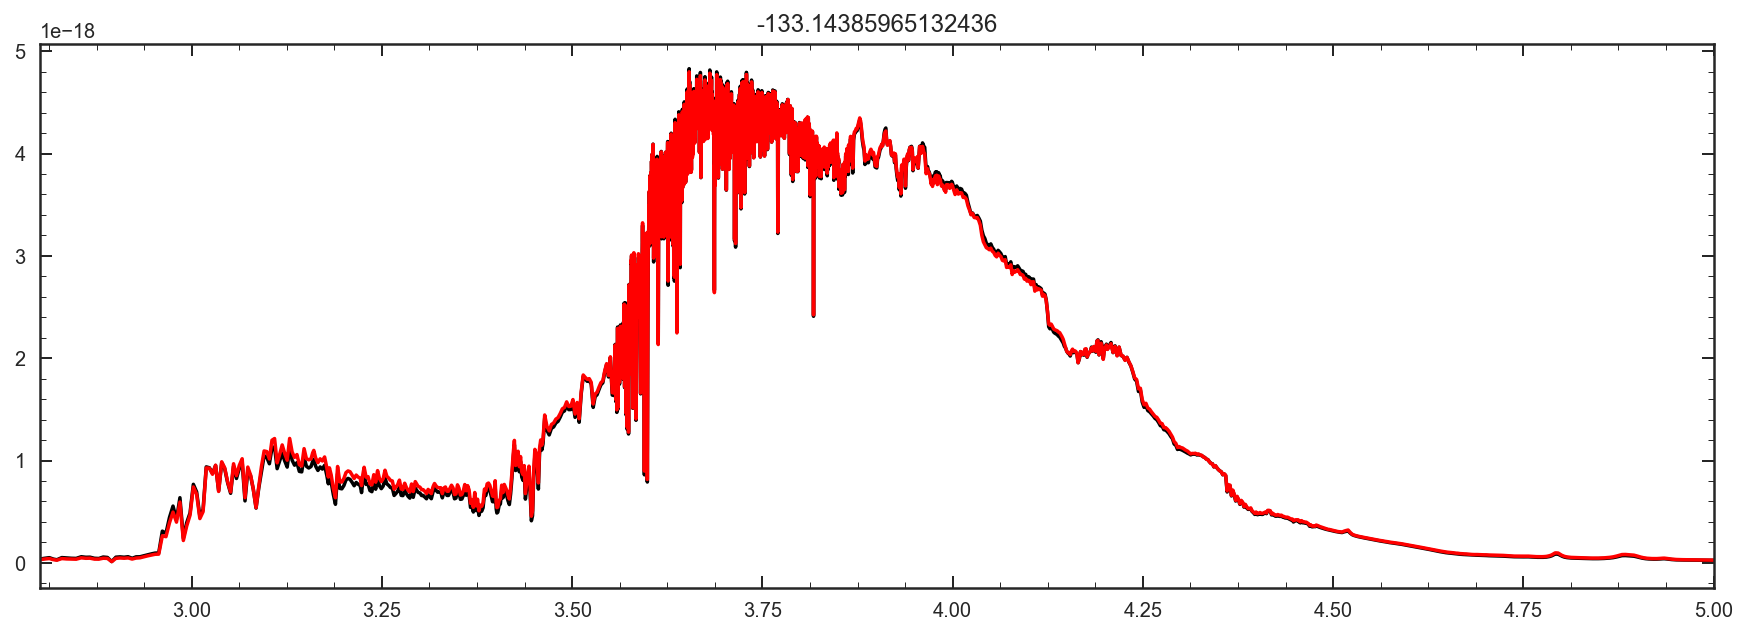

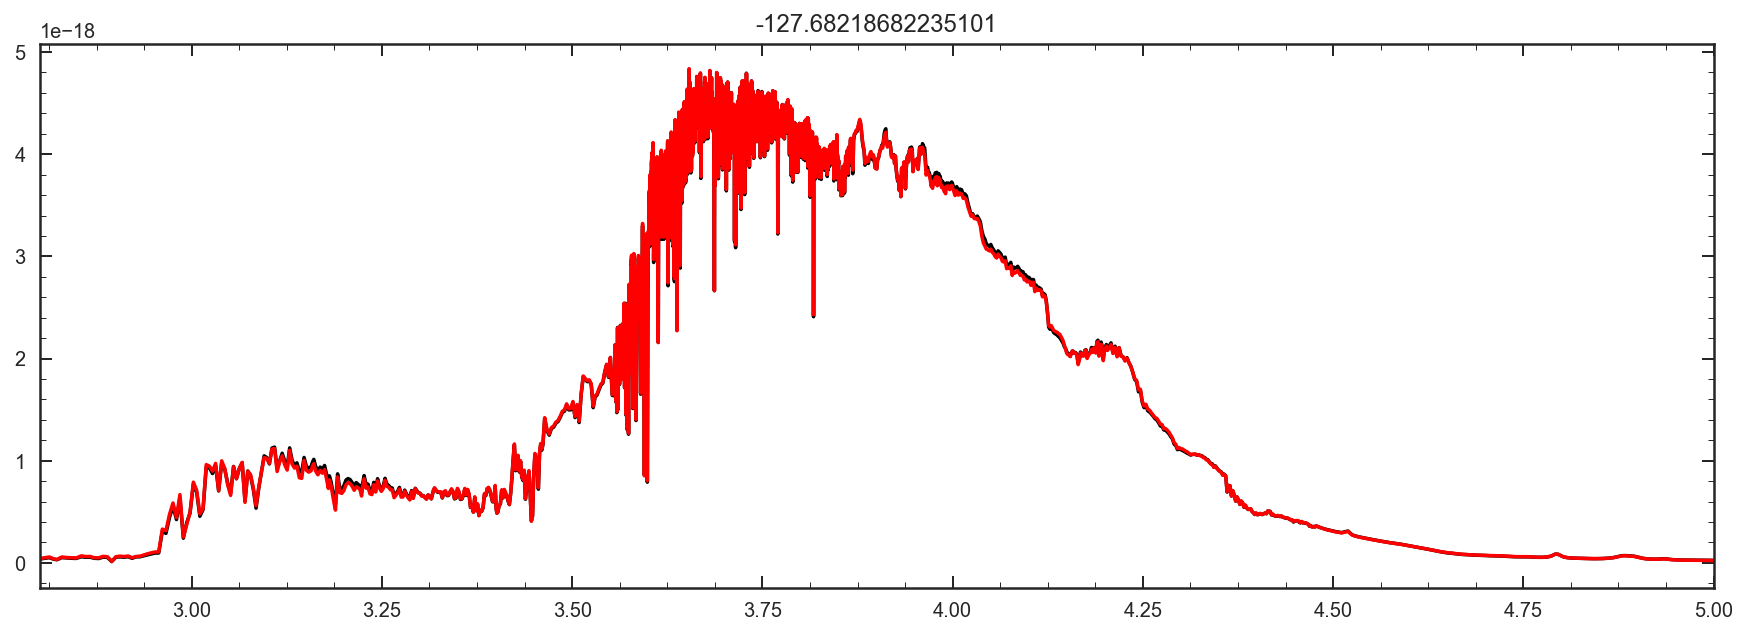

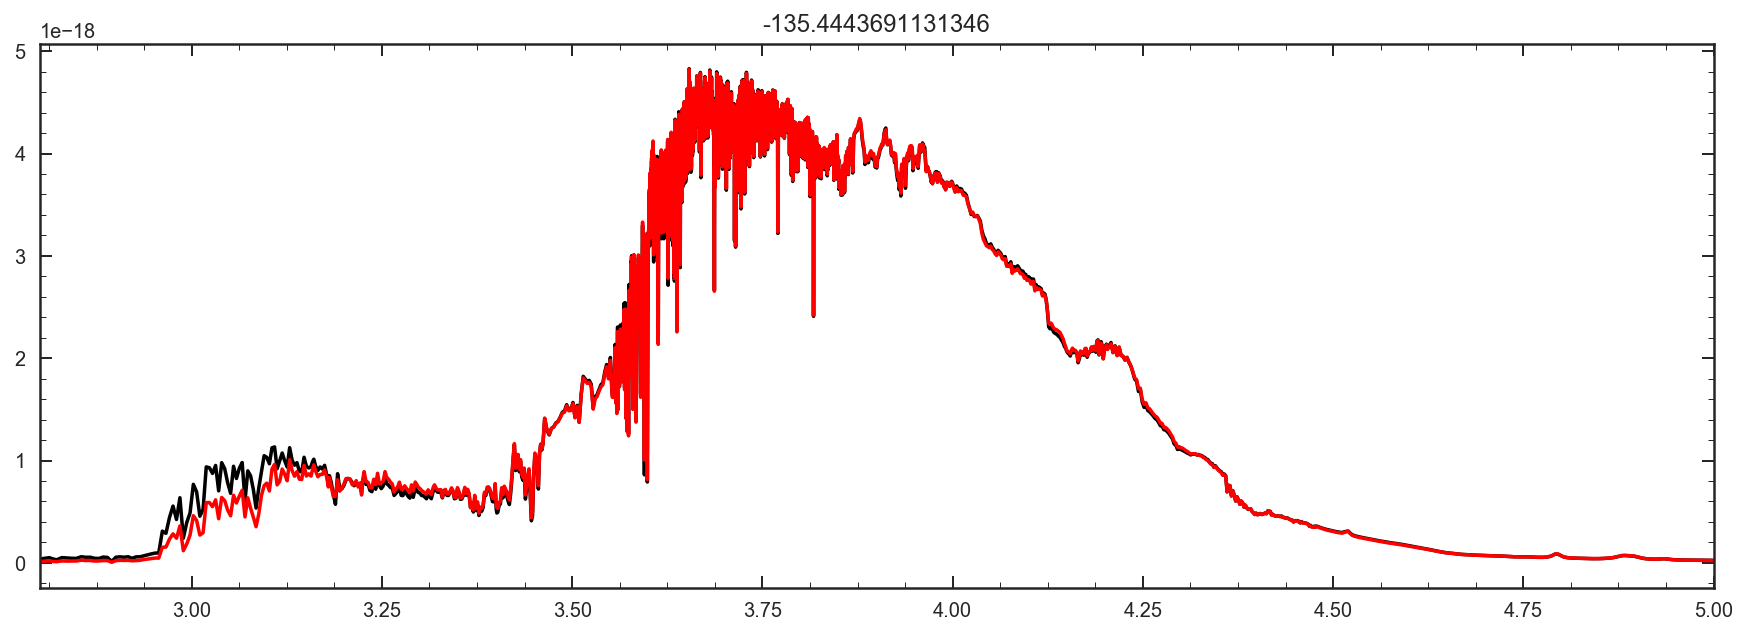

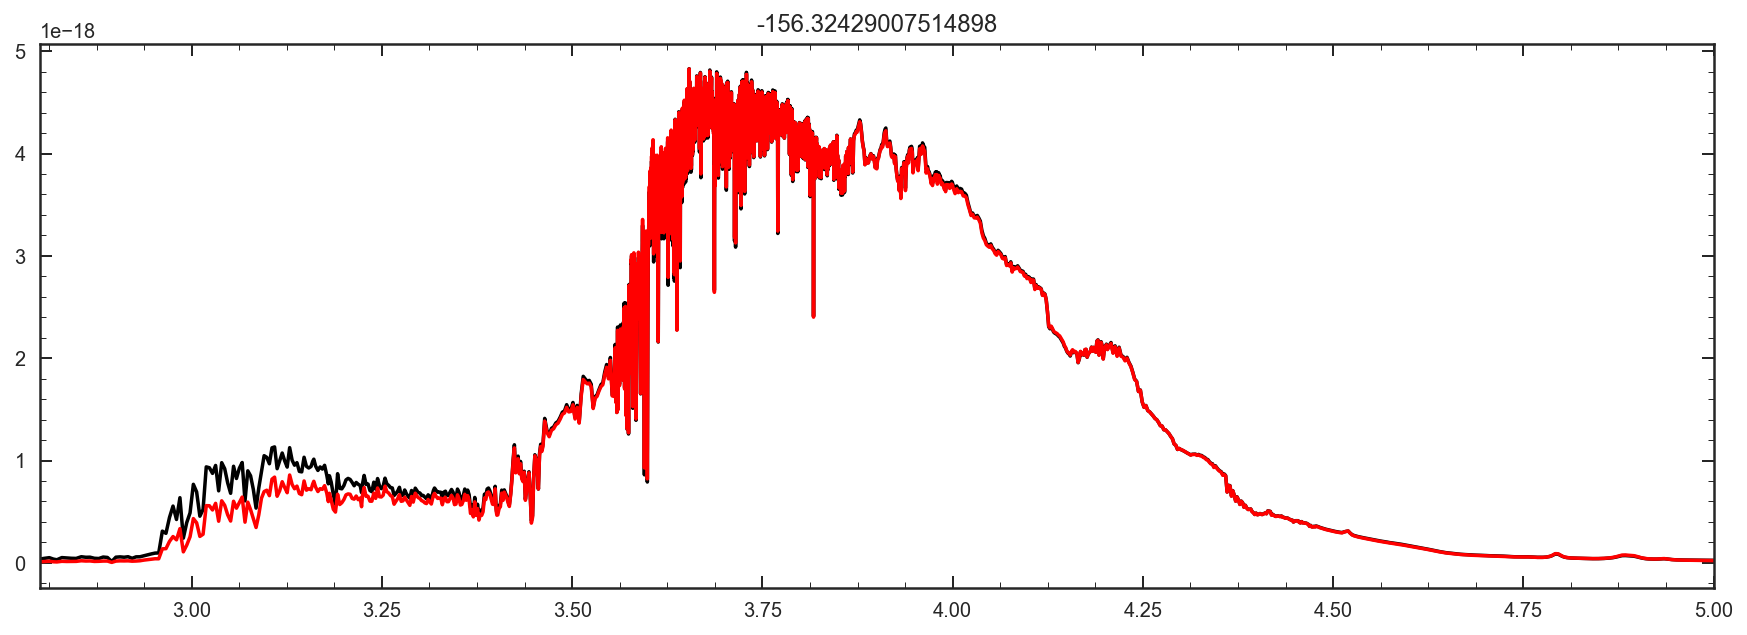

In [14]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

for i in range(10):
#     dres = np.load(multi_list[i]).item()
    bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_tab_to_tab_continuity_prior_multi_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'b')
    plt.title(logl)
    plt.xlim(2.8,5)
    
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

for i in range(10):
#     dres = np.load(multi_list[i]).item()
    bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_tab_to_tab_continuity_prior_multi_metal_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]),
                      Z = np.array([bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10])*0.019)

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave1), flux1 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'r')
    plt.title(logl)
    plt.xlim(2.8,5)

# Compare dt spec_fits

In [72]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

wave2, flux2 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc2 = sp.stellar_mass

D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

mass_transform = 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

In [21]:
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

for i in range(10):
    dres = np.load(multi_list[i]).item()
    bfZ, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_delay_to_tab_continuity_prior_multi_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]))

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'b')
    plt.title(dres.logl[-1])
    plt.xlim(2.8,5)
    
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 3, sfh = 3, dust_type = 1)

for i in range(10):
    dres = np.load(multi_list[i]).item()
    bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10, bft, bft1, bft2, bft3, bft4, bft5, bft6, \
    bft7, bft8, bft9, bft10, bfz, bfd, bflm, logl = \
    np.load('../data/bestfits/sim_test_delay_to_tab_continuity_prior_multi_metal_{0}_bfit.npy'.format(i+1))

    sp.params['dust2'] = bfd
    sp.params['dust1'] = bfd
    sp.params['logzsol'] = np.log10(bfZ)
    sp.set_tabular_sfh(LBT,np.array([bft1, bft2, bft3, bft4, bft5, bft6, bft7, bft8, bft9, bft10]),
                      Z = np.array([bfZ1,bfZ2,bfZ3,bfZ4,bfZ5,bfZ6,bfZ7,bfZ8,bfZ9,bfZ10])*0.019)

    wave, flux = sp.get_spectrum(tage = bft, peraa = True)

    mp1 = sp.stellar_mass
 
    D_l = cosmo.luminosity_distance(bfz).value # in Mpc
    MT = (10**bflm / mp1) * lsol_to_fsol / (4 * np.pi * (D_l*conv)**2)

    plt.figure(figsize=[15,5])
    plt.plot(np.log10(wave2), flux2 * mass_transform,'k')
    plt.plot(np.log10(wave), flux * MT,'r')
    plt.title(dres.logl[-1])
    plt.xlim(2.8,5)

NameError: name 'lsol_to_fsol' is not defined

# Compare td SFHs

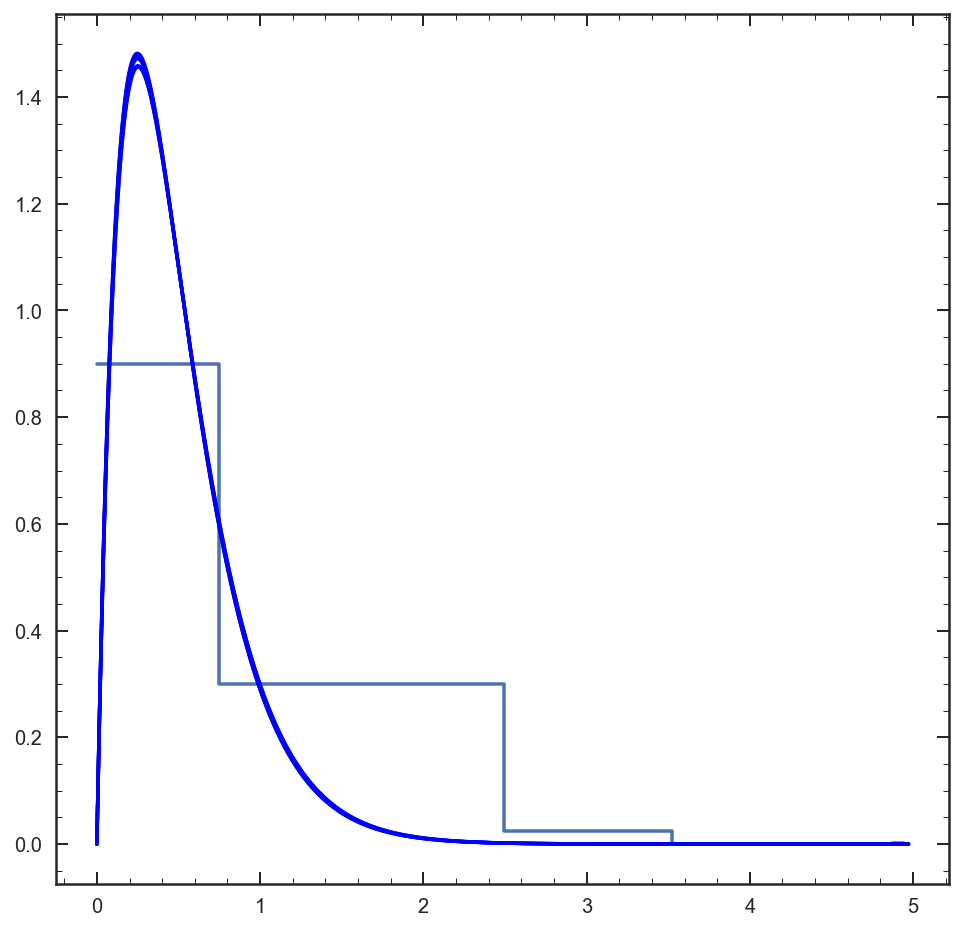

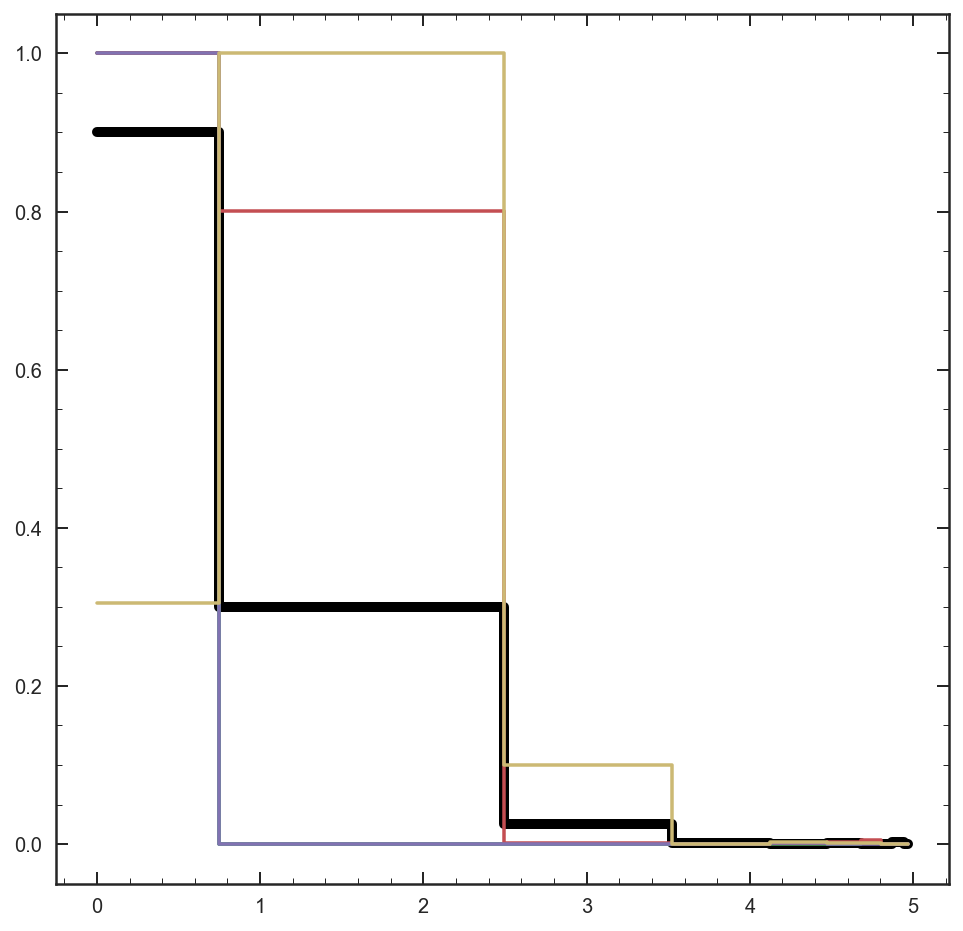

In [32]:
tab_sfh = np.array([0.9, 0.3, 0.025, 0.001, 0.0001, 0.001, 0.00001, 0.0002, 0.002, 0.0001])

T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh))

for i in range(1,6,1):
    t,pt = np.load('../data/posteriors/sim_test_tab_to_delay_multi_{0}_Pt.npy'.format(i))

    tau = t[pt == max(pt)][0]
    
    sfh = T * np.exp(-T / tau)

    sfh /= np.trapz(sfh,T)
    
    plt.plot(T,sfh,'b')

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh),'k', linewidth = 5)
for i in range(1,6,1):
    md = np.zeros(10)
    for ii in range(7):
        t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_sclspec_{0}_Pt{1}.npy'.format(i,ii+1))
        md[ii] = t[pt == max(pt)]
        
    plt.step(np.append(0,LBT), np.append(md[0],md) / max(md))


# Compare dt SFHs

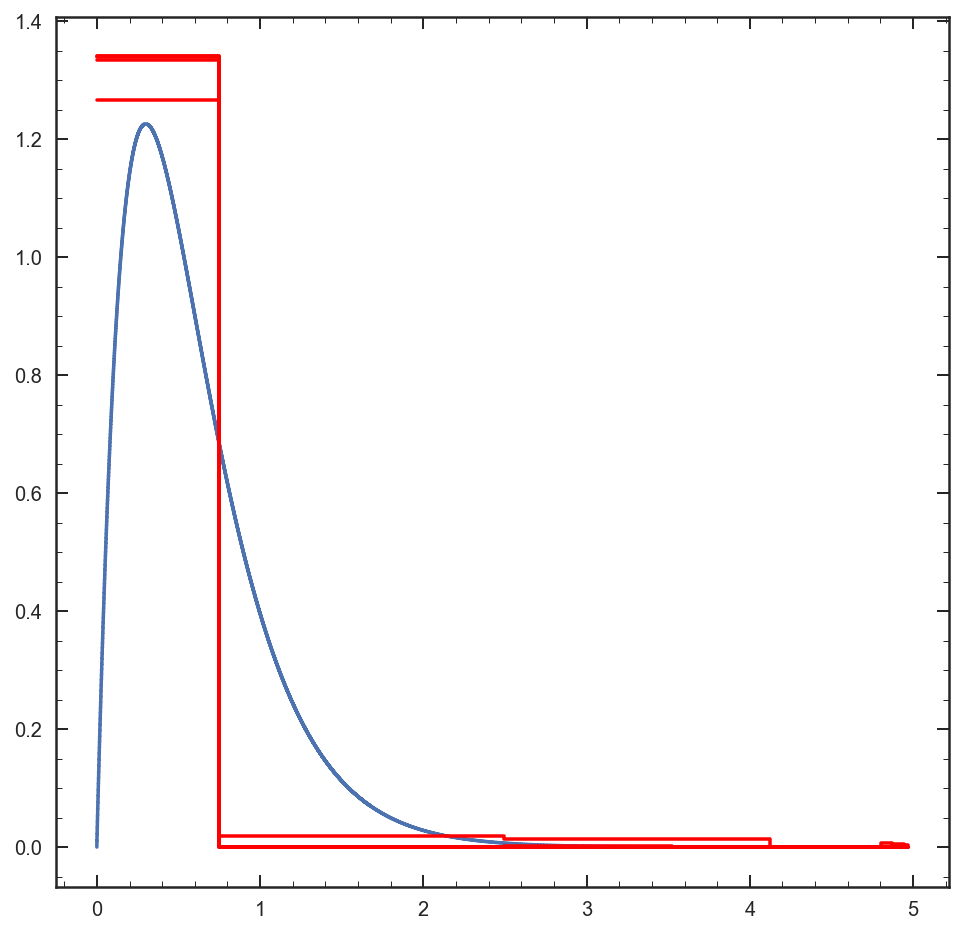

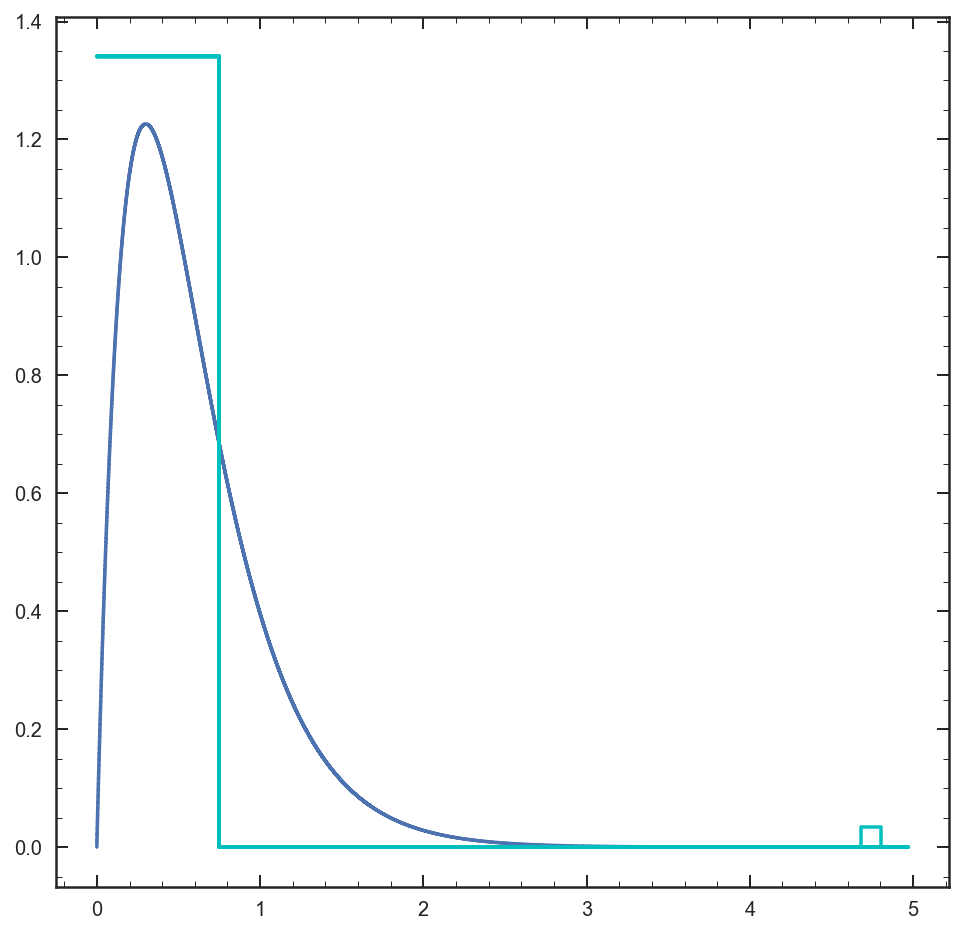

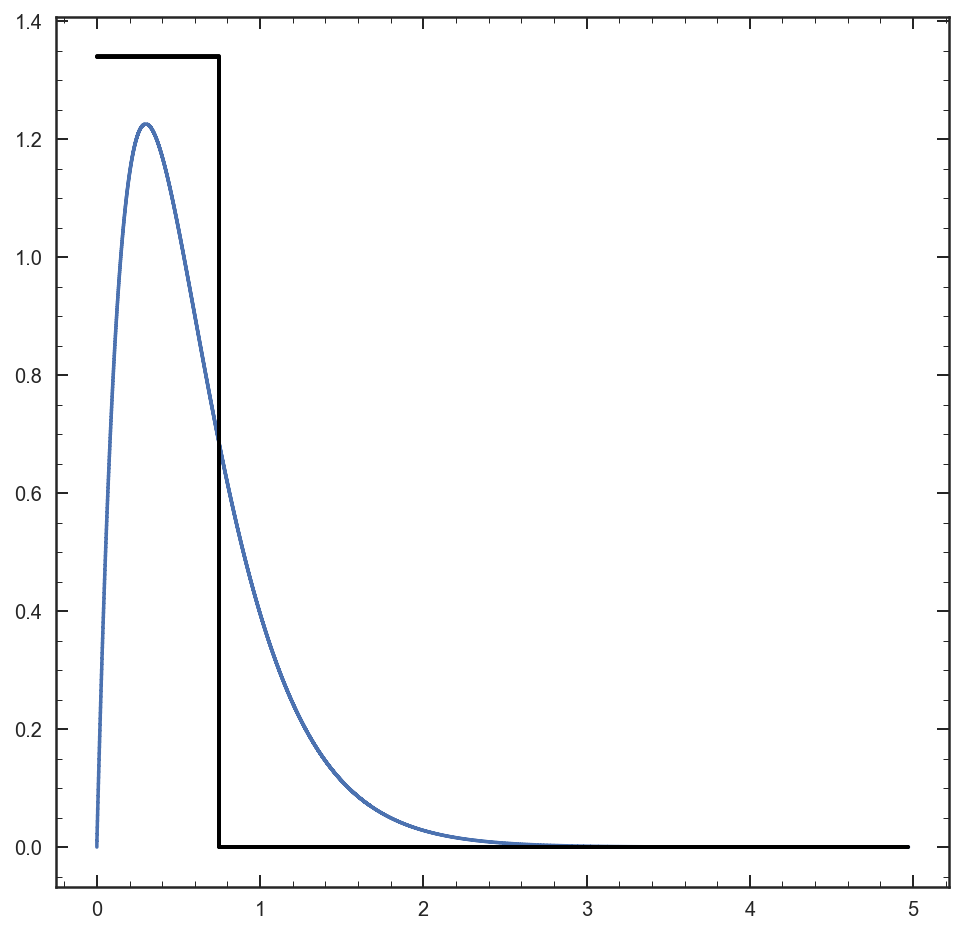

In [35]:
T= np.arange(0,Oldest_galaxy(1.25)+.001,.001)

sfh = T * np.exp(-T / 0.3)

sfh /= np.trapz(sfh,T)

plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(5):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_{0}_Pt{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'r')

plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(5):
    md = np.zeros(10)

    for ii in range(7):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_lessbin_{0}_Pt{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'c')
    
plt.figure(figsize=[8,8])
plt.step(T, sfh,)

for i in range(5):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_sclspec_{0}_Pt{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    plt.step(np.append(0,LBT), np.append(md[0],md), 'k')

# Compare tt SFHs

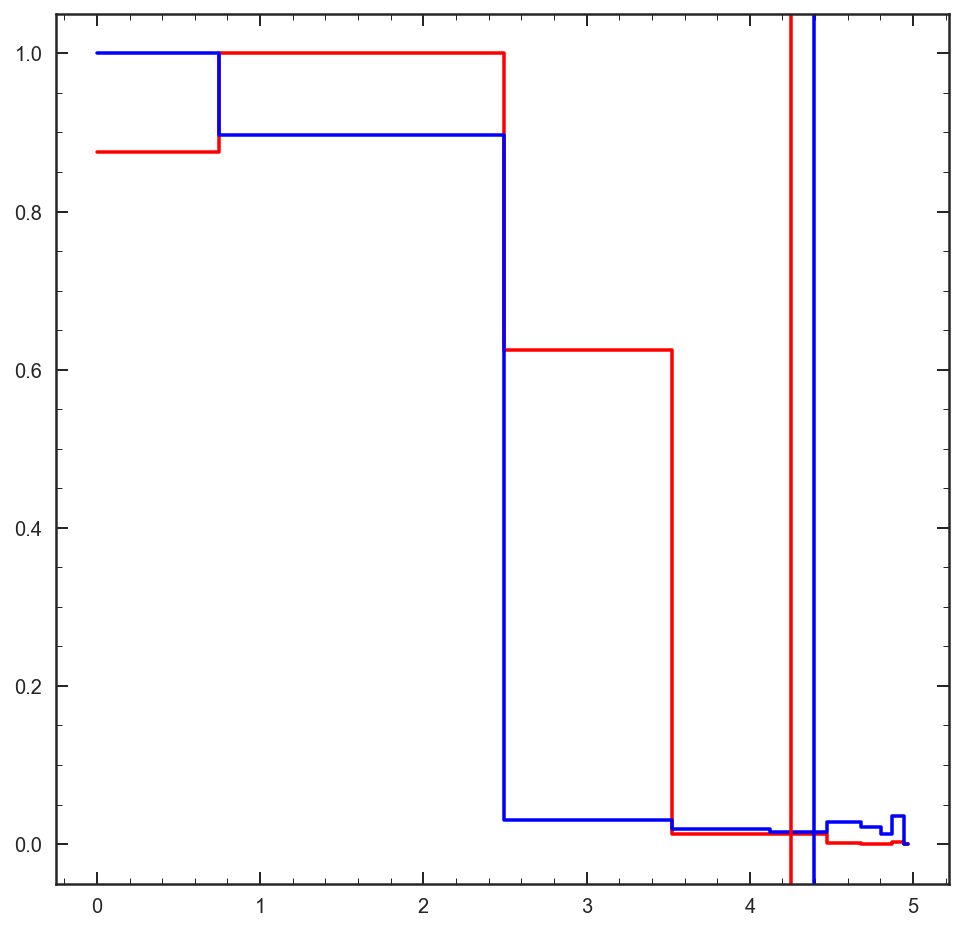

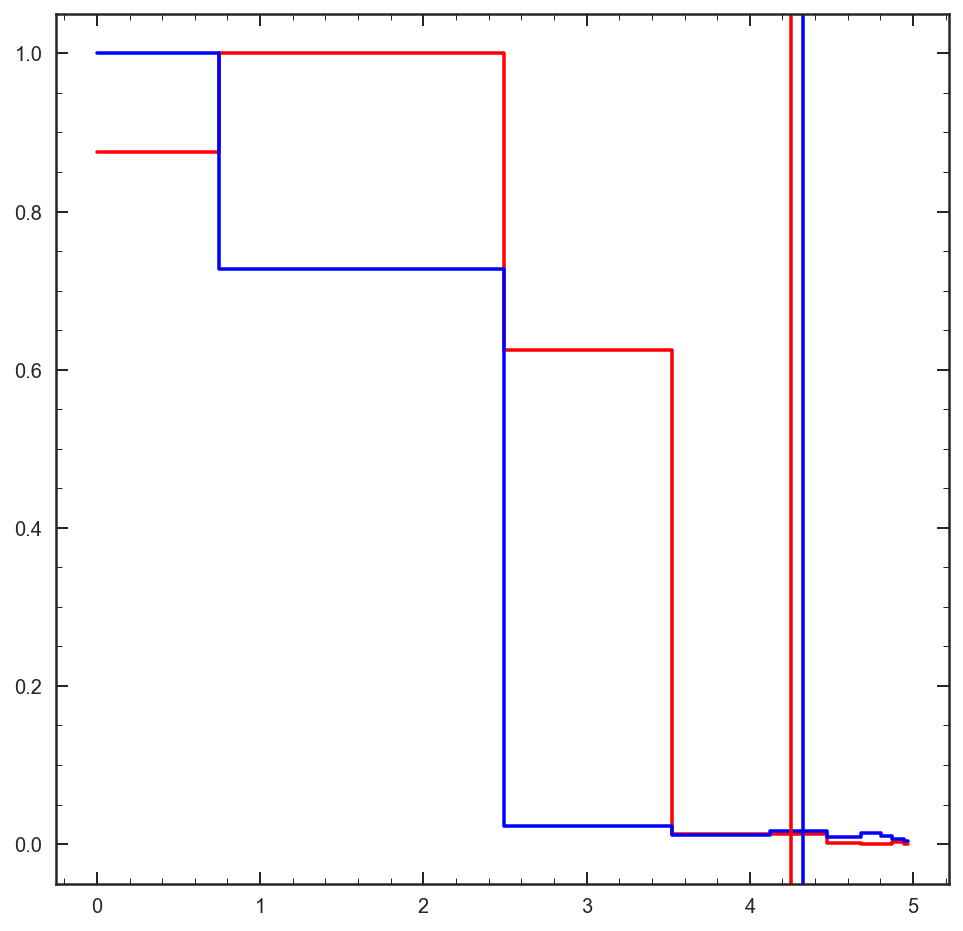

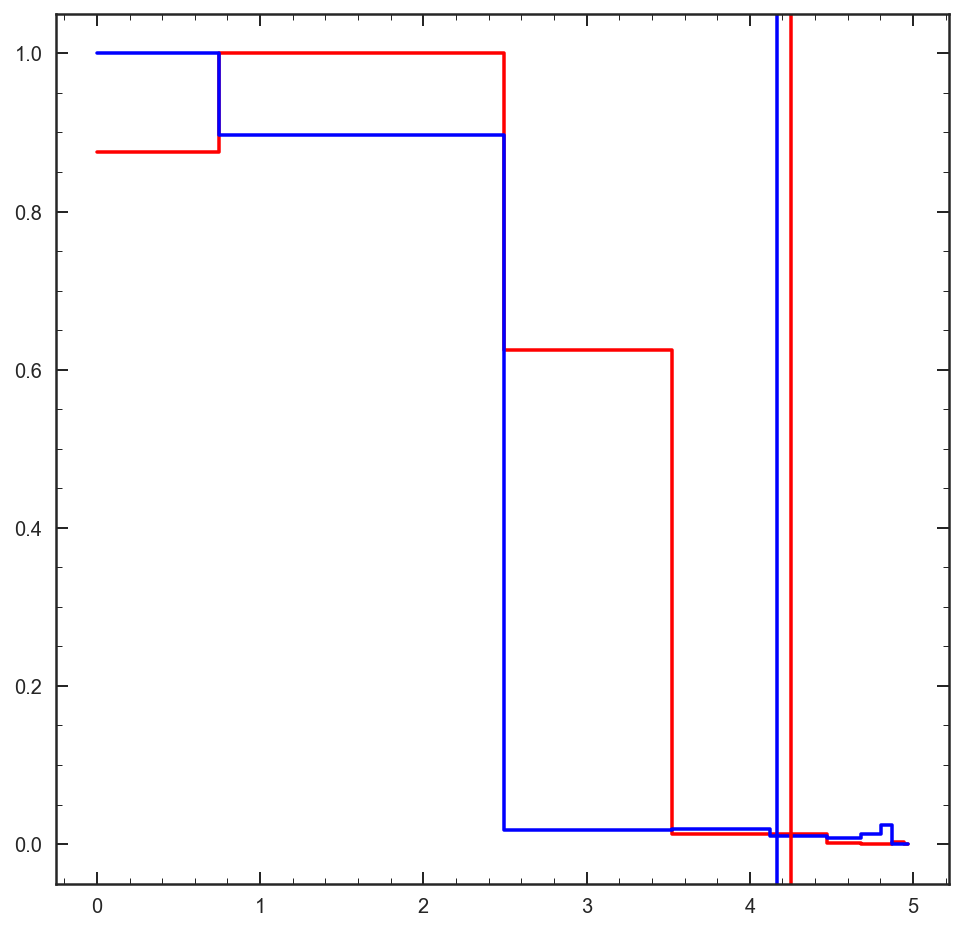

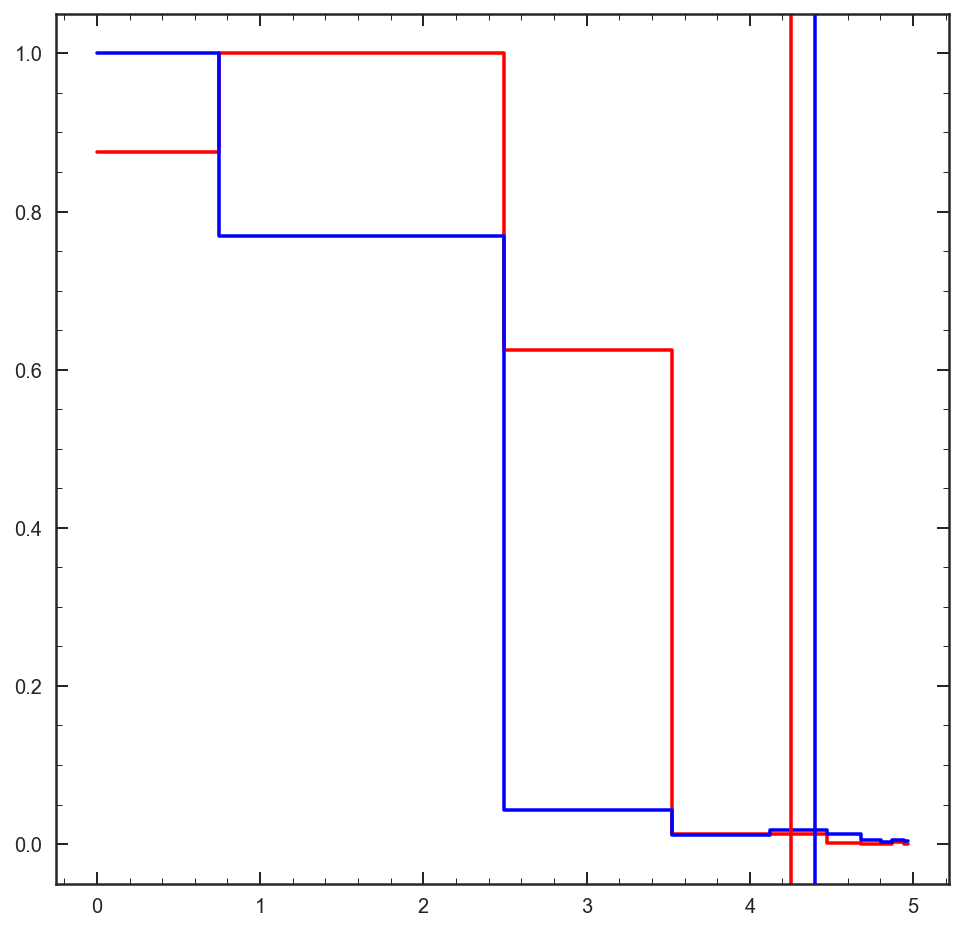

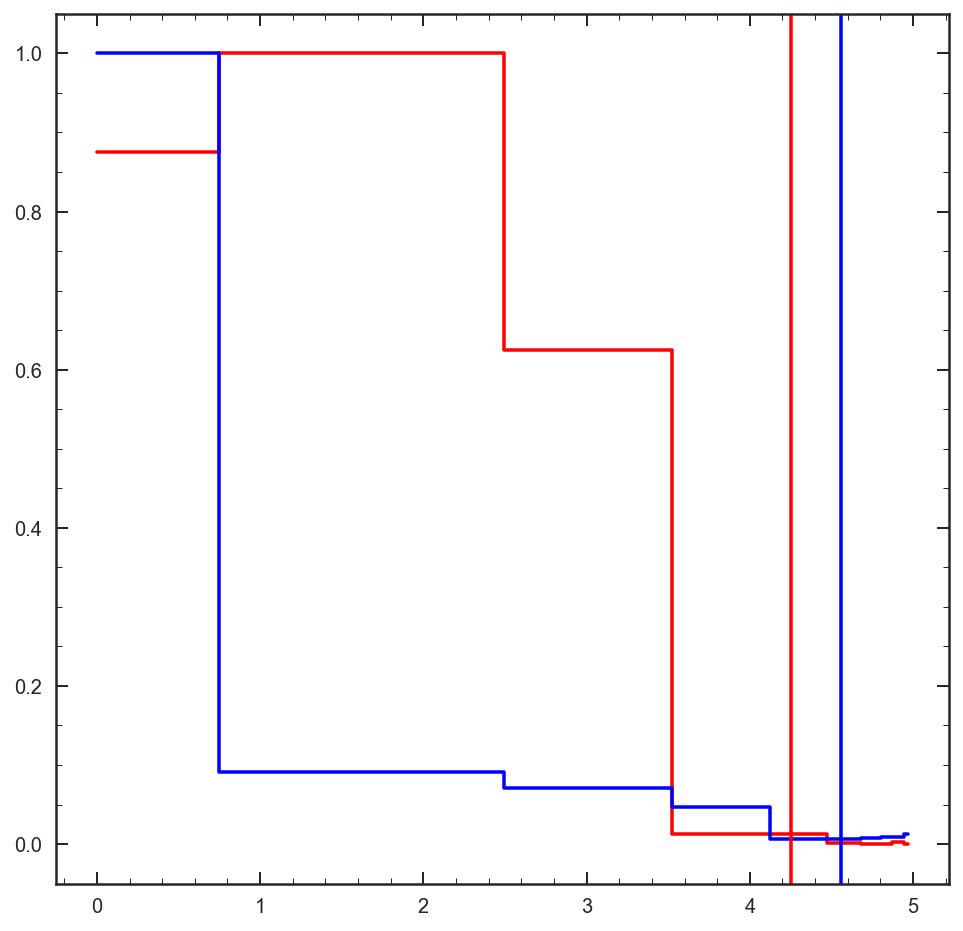

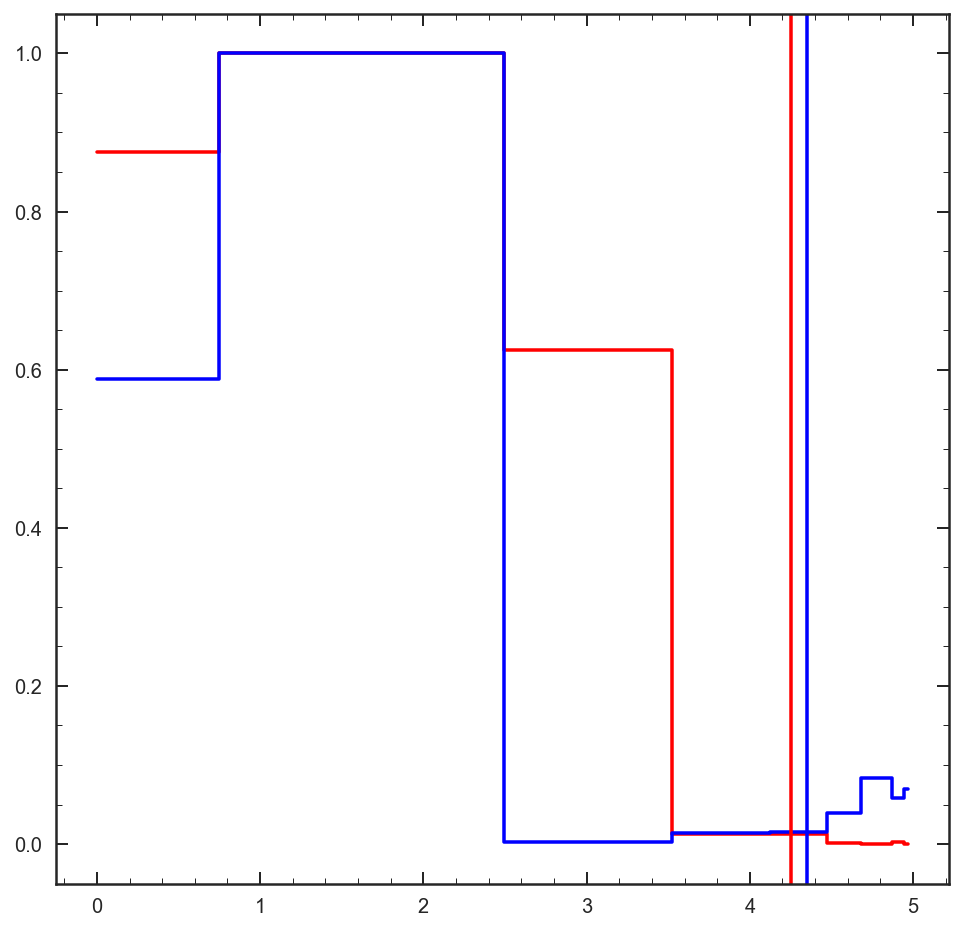

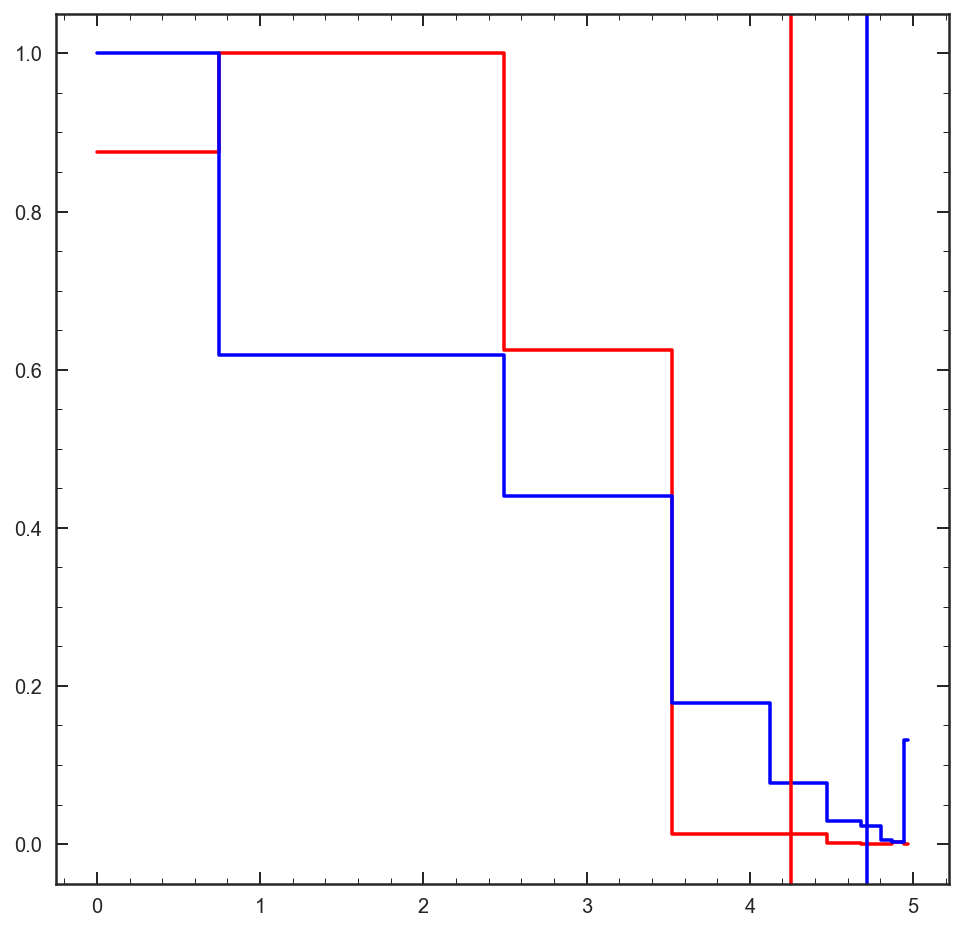

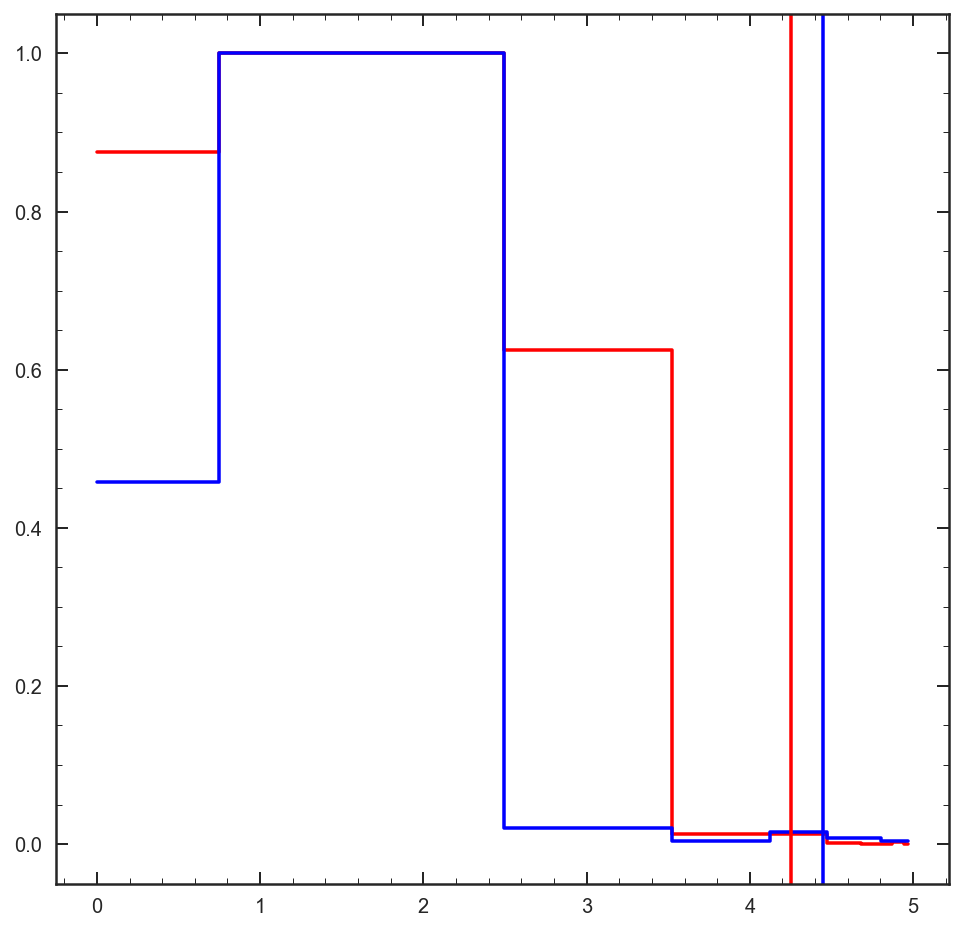

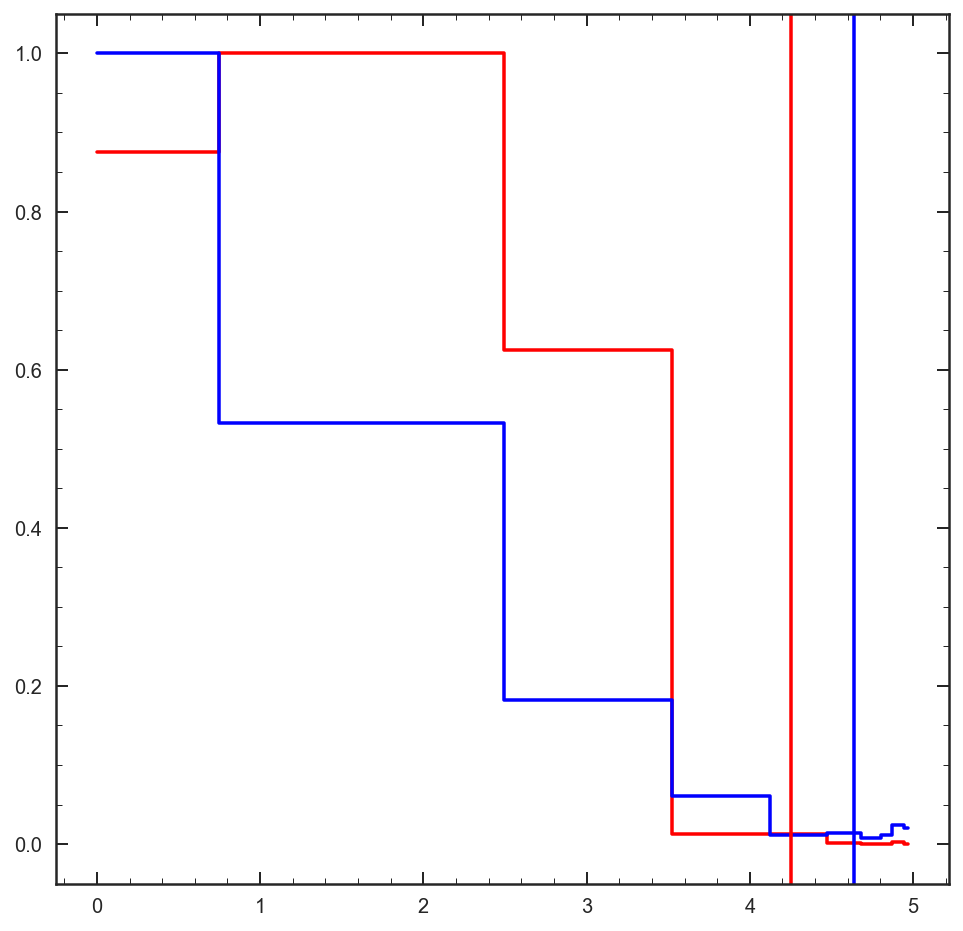

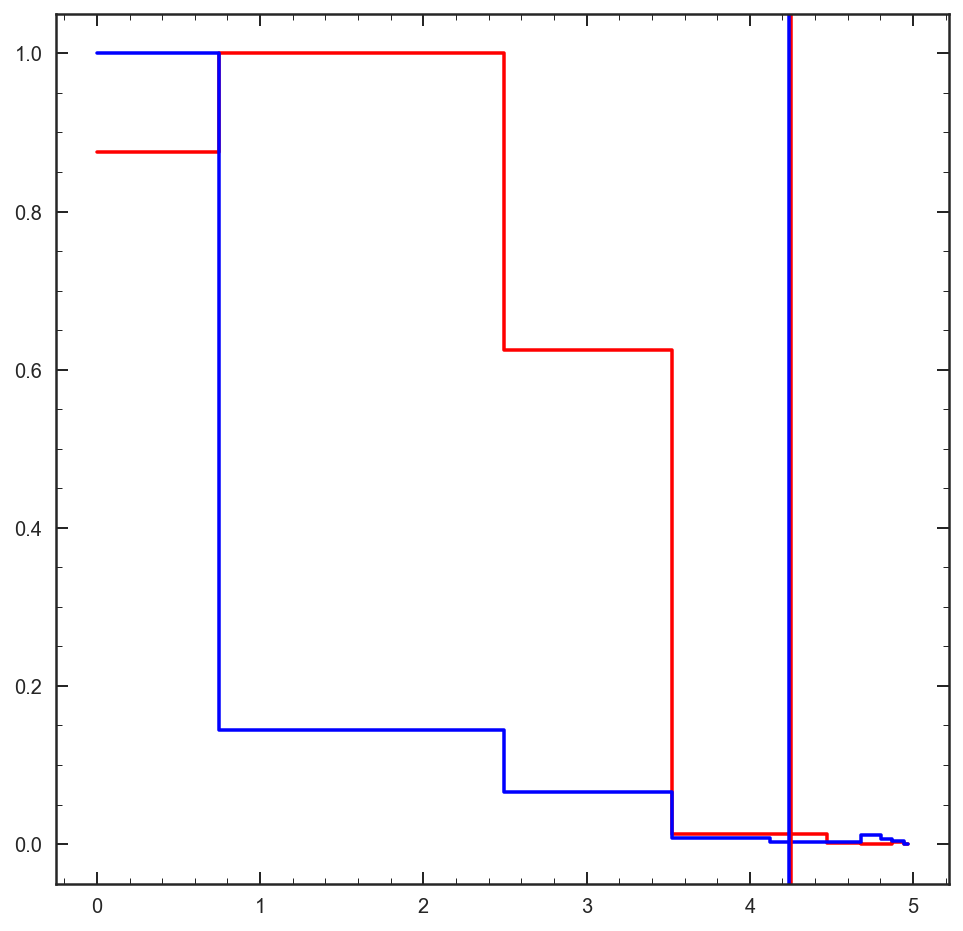

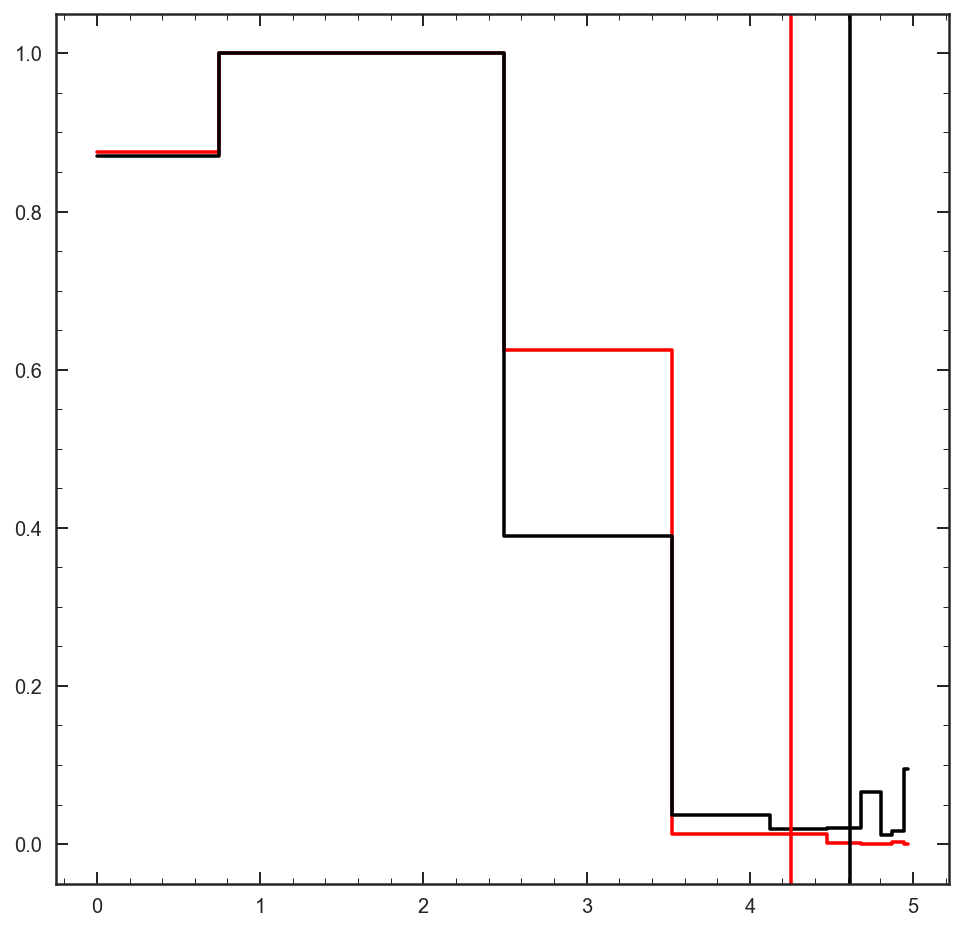

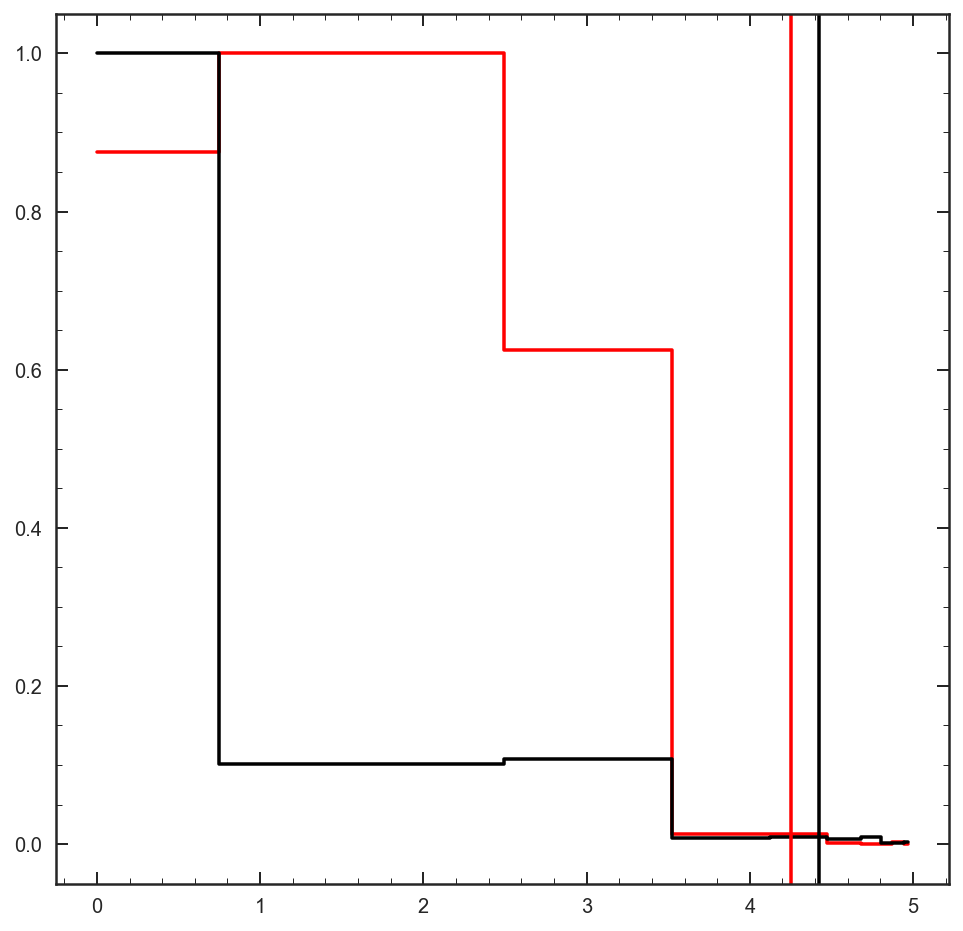

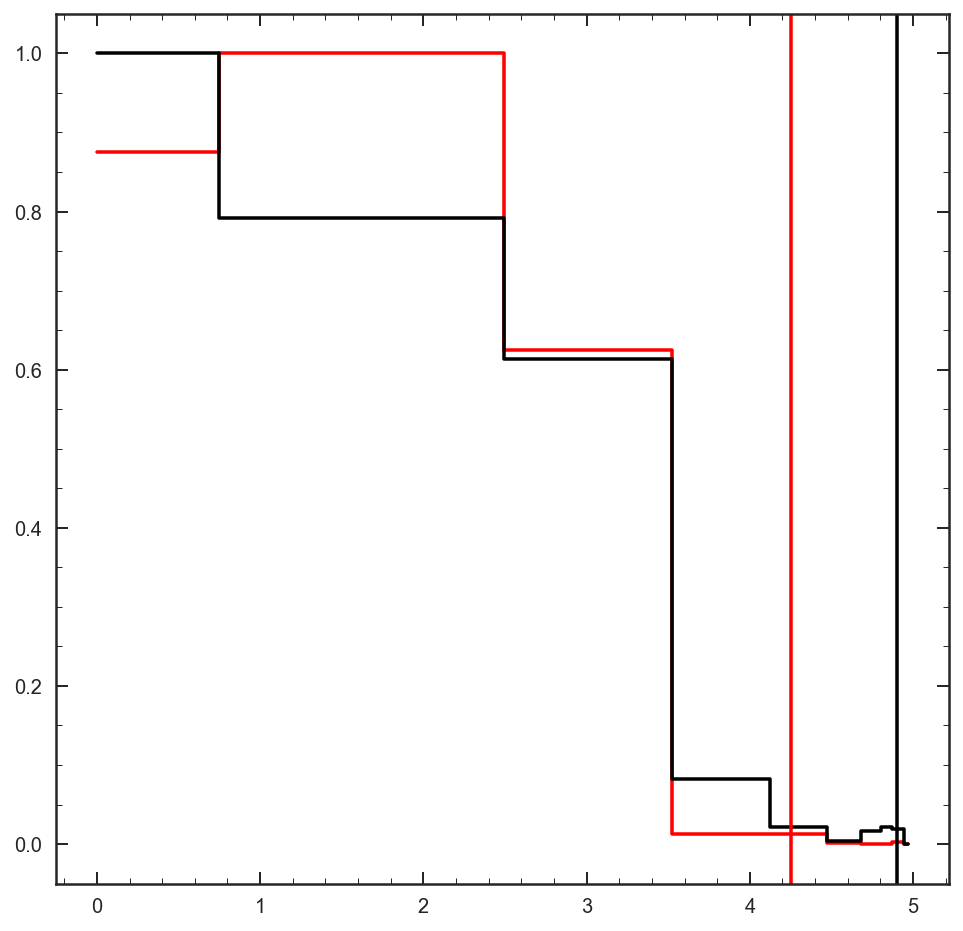

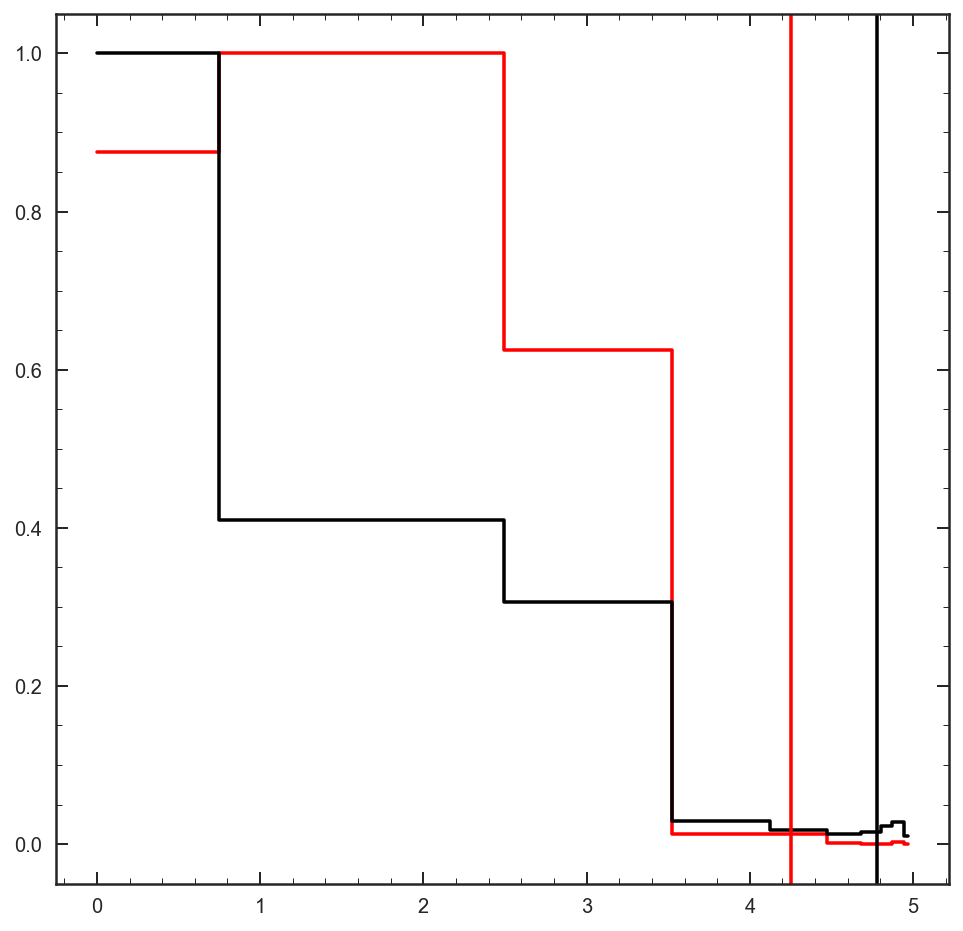

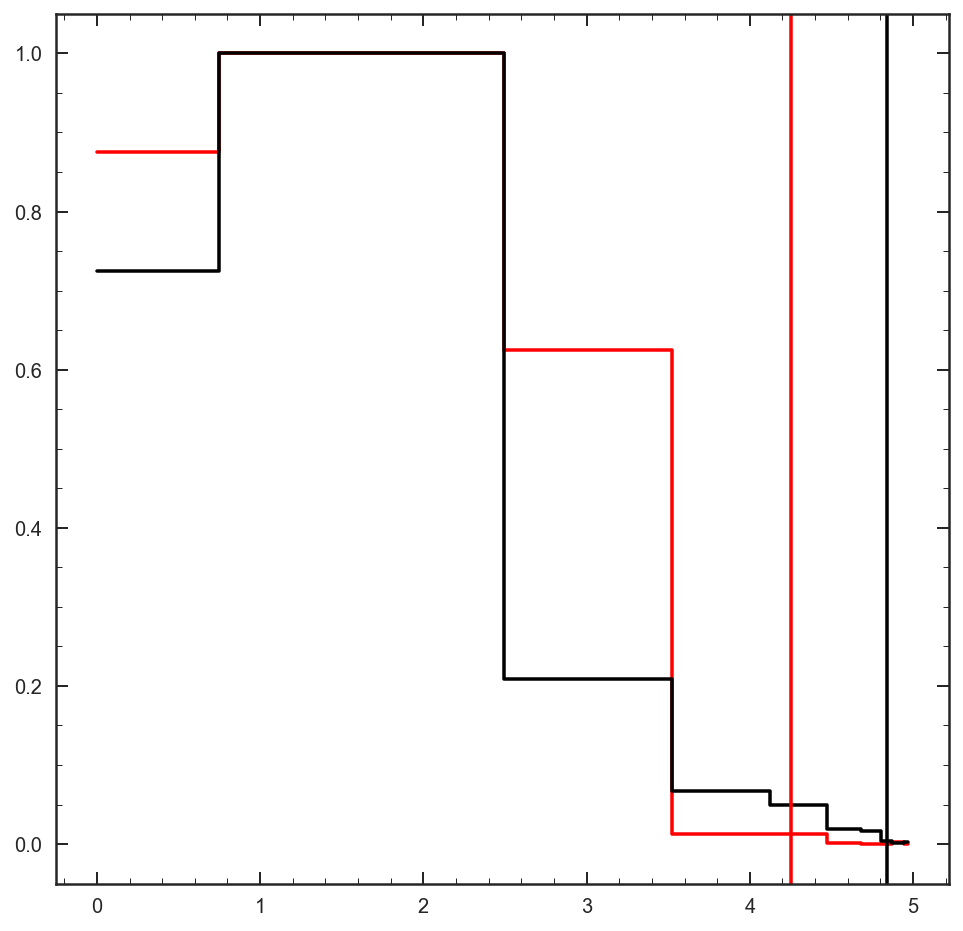

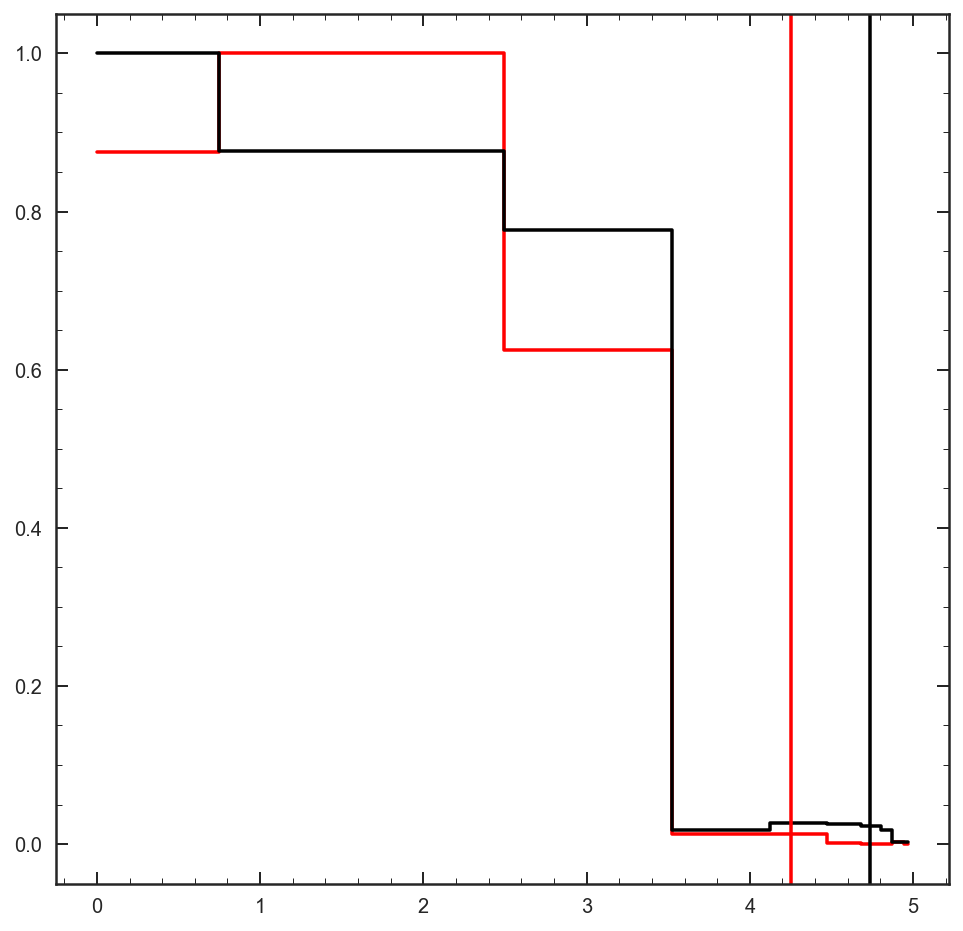

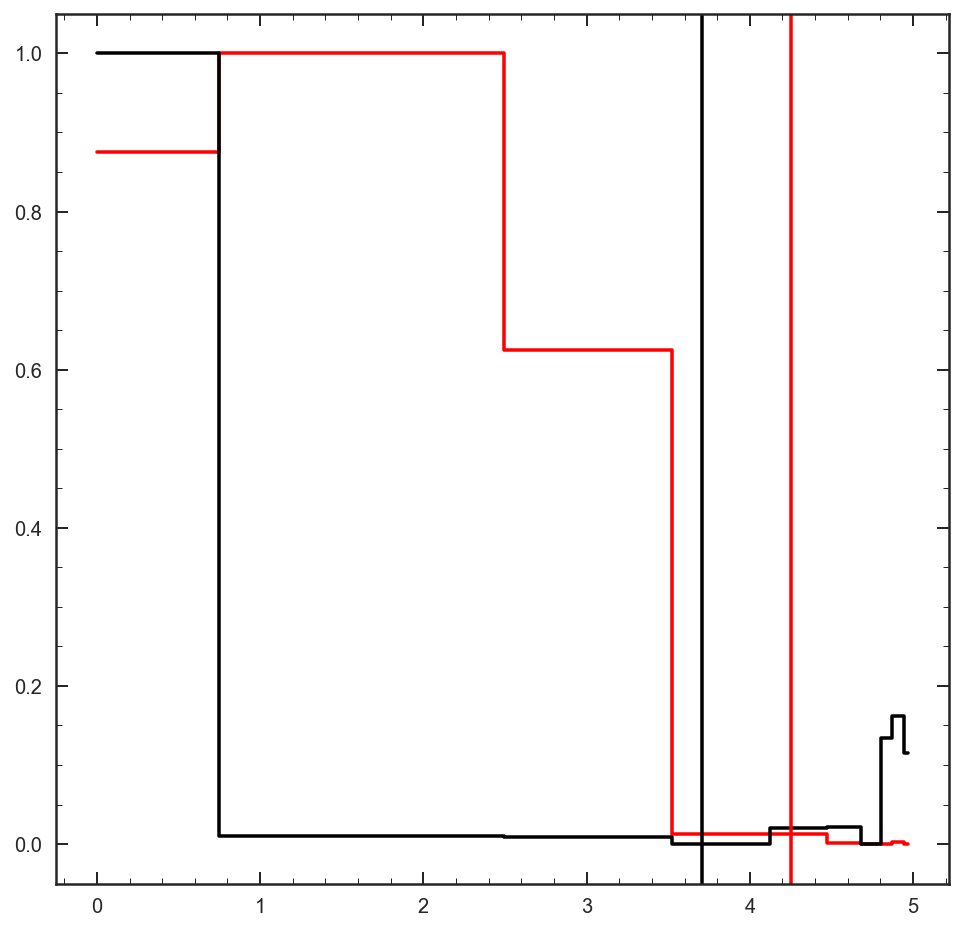

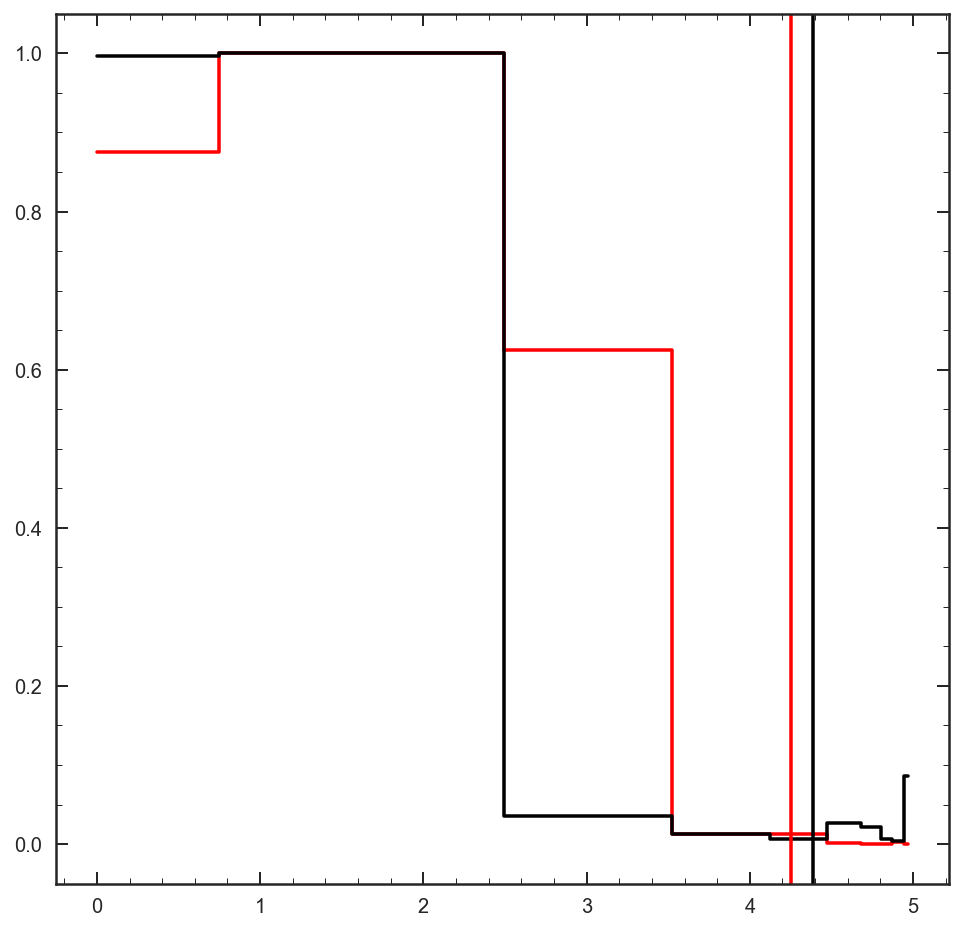

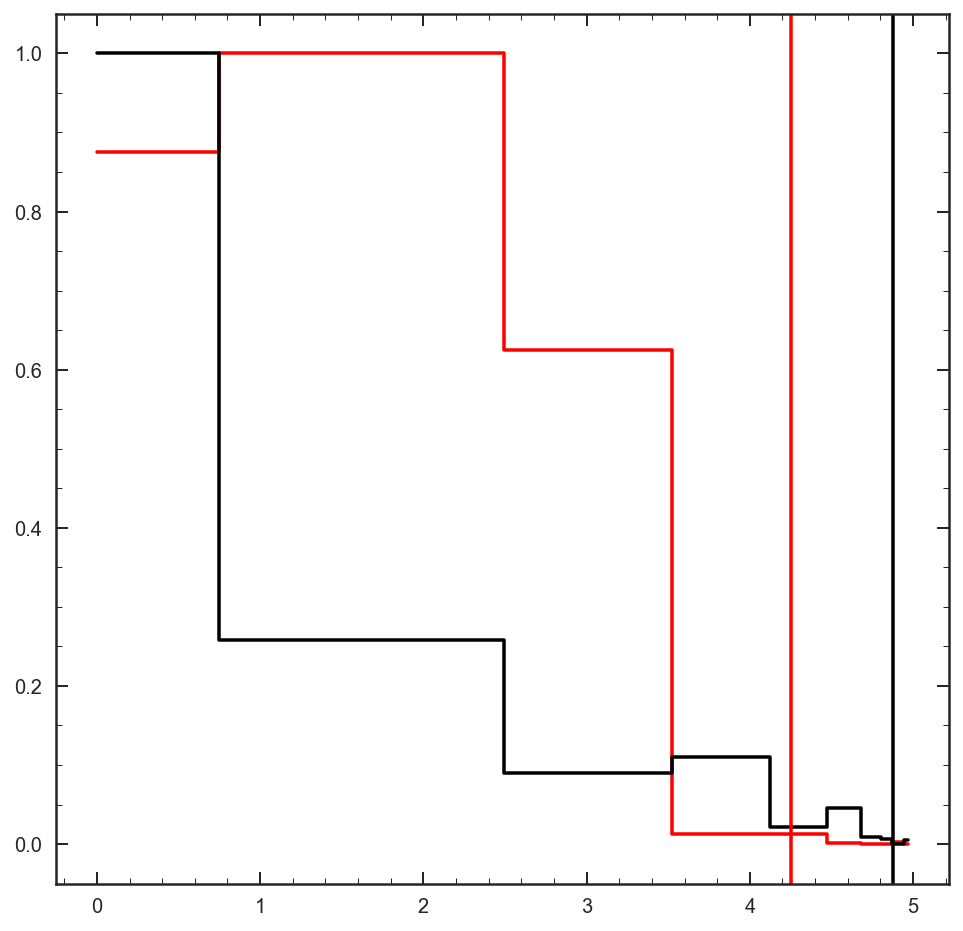

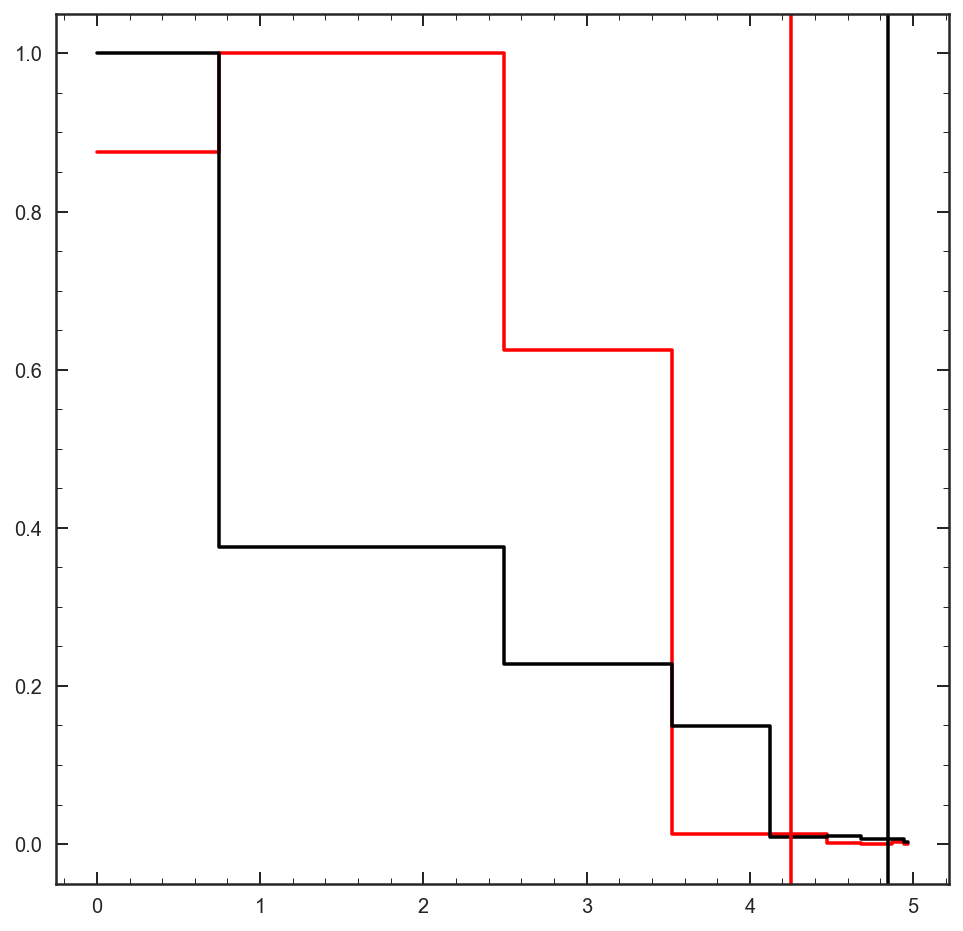

In [57]:
tab_sfh = np.array([0.7, 0.8, 0.5, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])

for i in range(10):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_{0}_Pt{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
        
    t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_{0}_Pa.npy'.format(i+1))
    md_age = t[pt == max(pt)]
    plt.figure(figsize=[8,8])
    plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh) / max(tab_sfh),'r')
    plt.step(np.append(0,LBT), np.append(md[0],md) / max(md), 'b')
    plt.axvline(4.25,color = 'r')
    plt.axvline(md_age,color = 'b')

for i in range(10):
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_metal_{0}_Pt{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]
    t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_metal_{0}_Pa.npy'.format(i+1))
    
    md_age = t[pt == max(pt)]
    
    plt.figure(figsize=[8,8])
    plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh) / max(tab_sfh),'r')
    plt.step(np.append(0,LBT), np.append(md[0],md) / max(md), 'k')
    plt.axvline(4.25,color = 'r')
    plt.axvline(md_age,color = 'k')


In [65]:
def get_massdist(sfr, LBT):
    md = sfr
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < bft]
    hrtime = hrtime[hrtime < bft]
    mass /= mass[-1]

    return hrtime,mass

def scale_sfr(sfr, LBT, fitmass):
    md = sfr
    hrtime = np.round(np.arange(0,LBT[-1],0.001),2)
    dt = 0.001
    mass = np.zeros(len(hrtime))
    mbu = 0
    u = 0
    for i in range(len(hrtime)):
        if hrtime[i] > LBT[u]:
            u+=1
        mass[i] = mbu
        mbu += md[u] * dt

    mass = mass[hrtime < bft]
    hrtime = hrtime[hrtime < bft]    
    
    return sfr / max(mass) * 10**fitmass * 1E-9

In [83]:
t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_1_Plm.npy')
md_mass = t[pt == max(pt)]
t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_1_Pa.npy')

sc_tab_sfh = scale_sfr(tab_sfh,LBT,11)
sc_md = scale_sfr(md,LBT,md_mass)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(sc_tab_sfh[0], sc_tab_sfh),'r')
plt.step(np.append(0,LBT), np.append(sc_md[0],sc_md), 'b')
plt.axvline(4.25, color = 'r')
plt.plot(t,pt / max(pt) * 40)

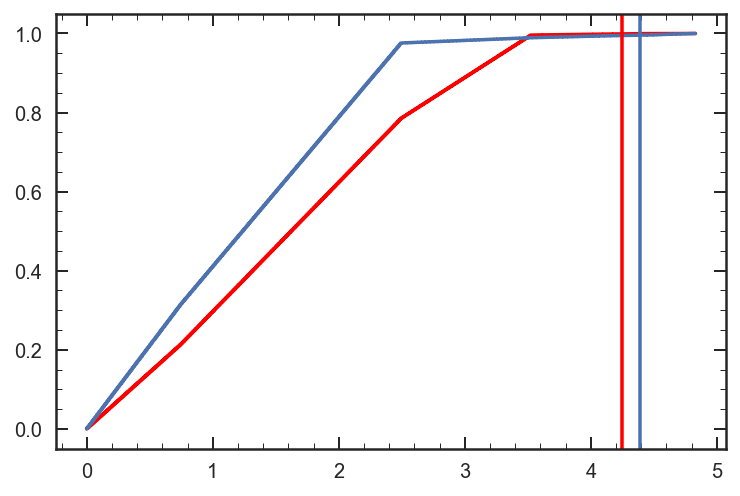

In [56]:
plt.plot(mtime,mdist,'r')
plt.plot(mtime2,mdist2)
plt.axvline(4.25, color = 'r')
plt.axvline(md_age)

<Figure size 576x576 with 0 Axes>

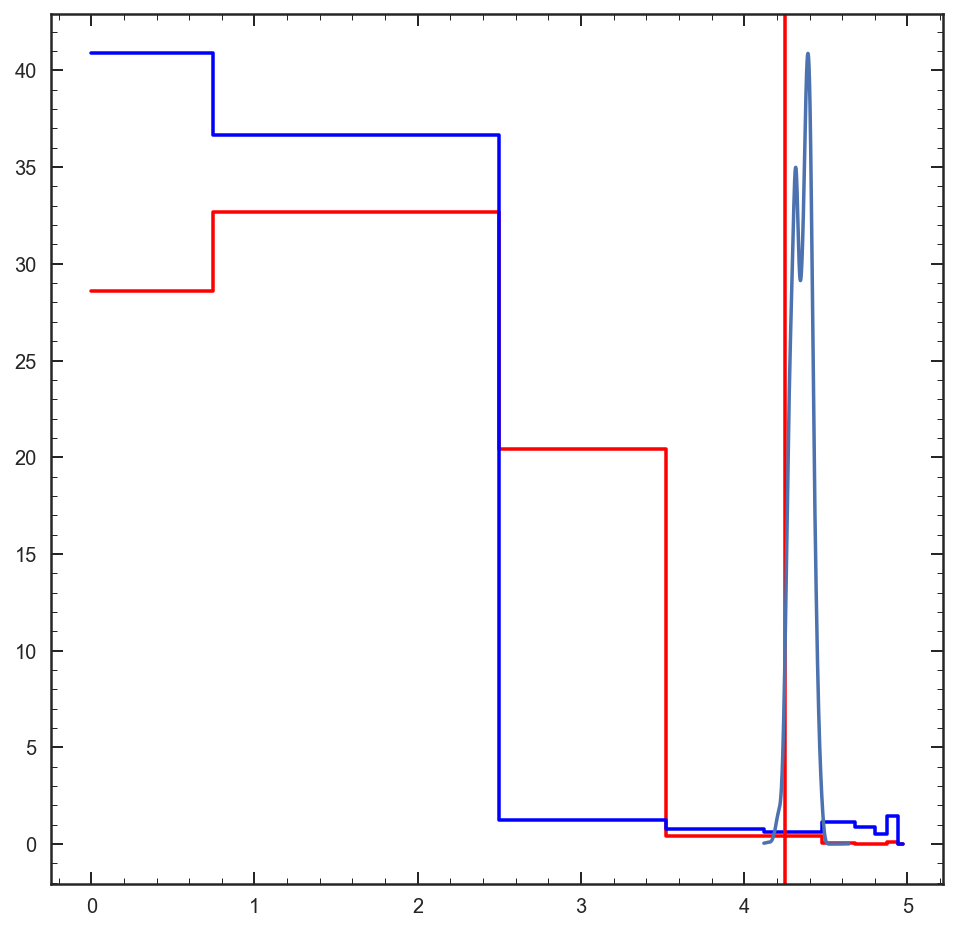

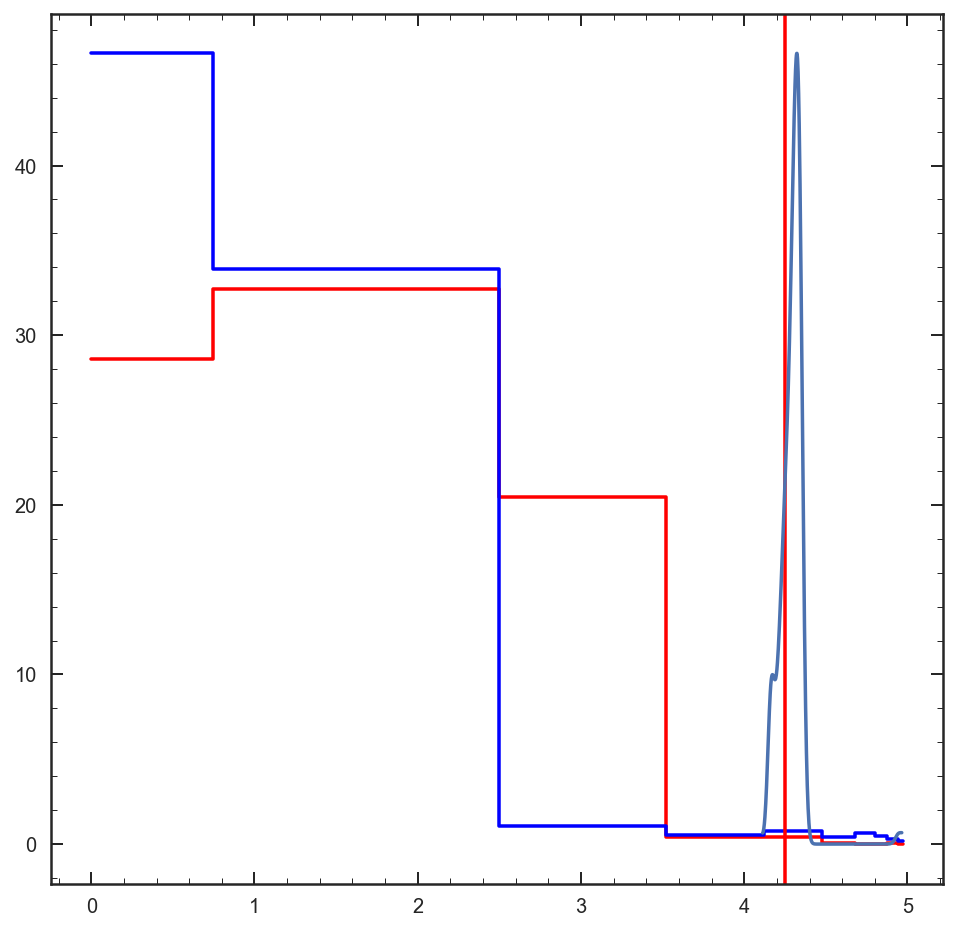

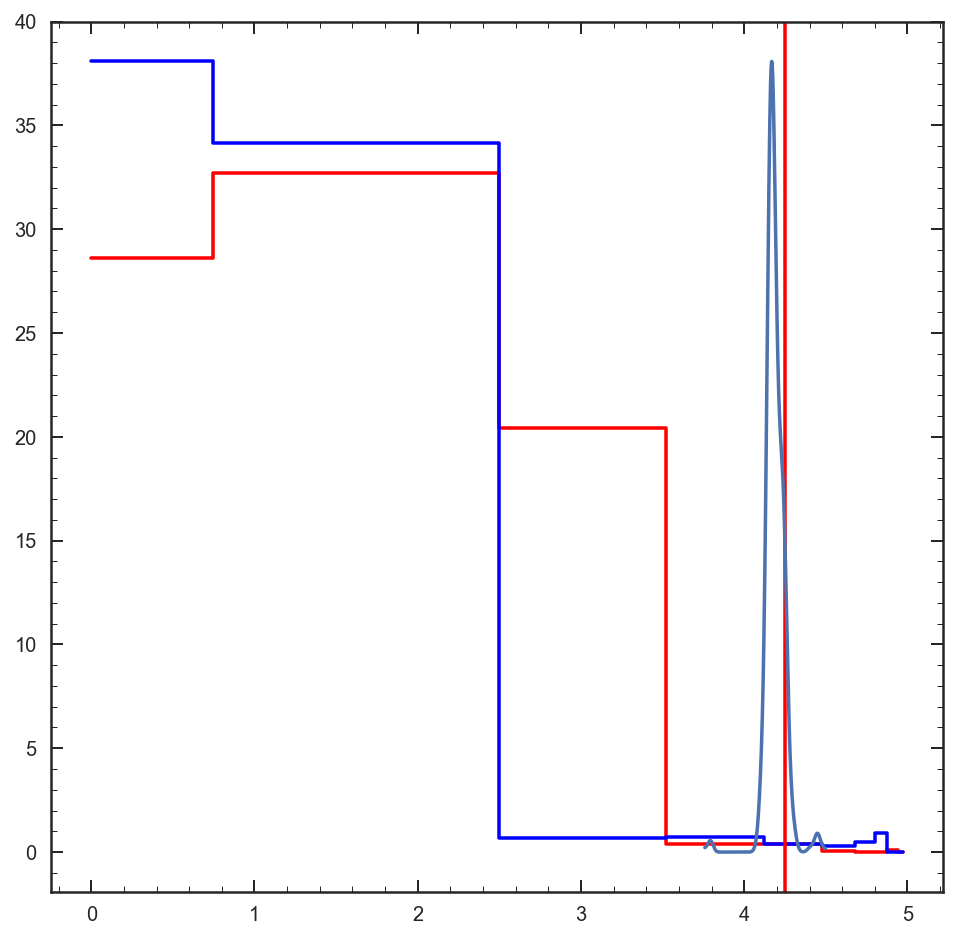

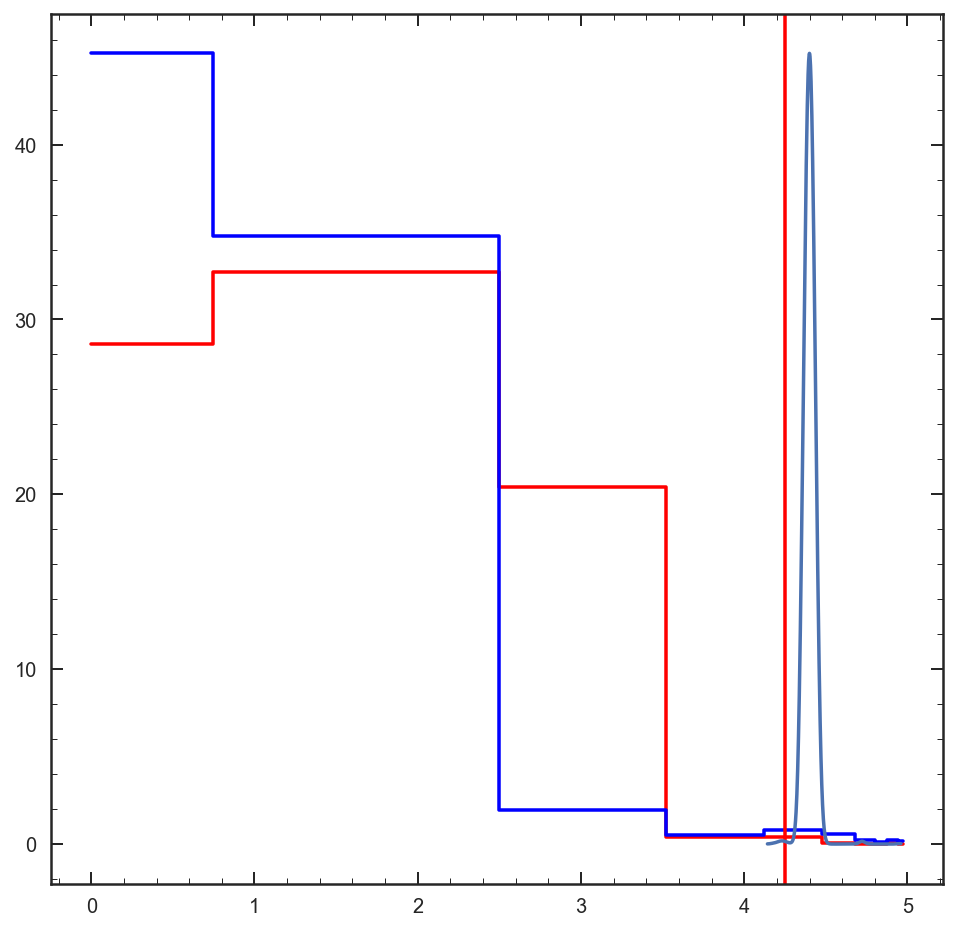

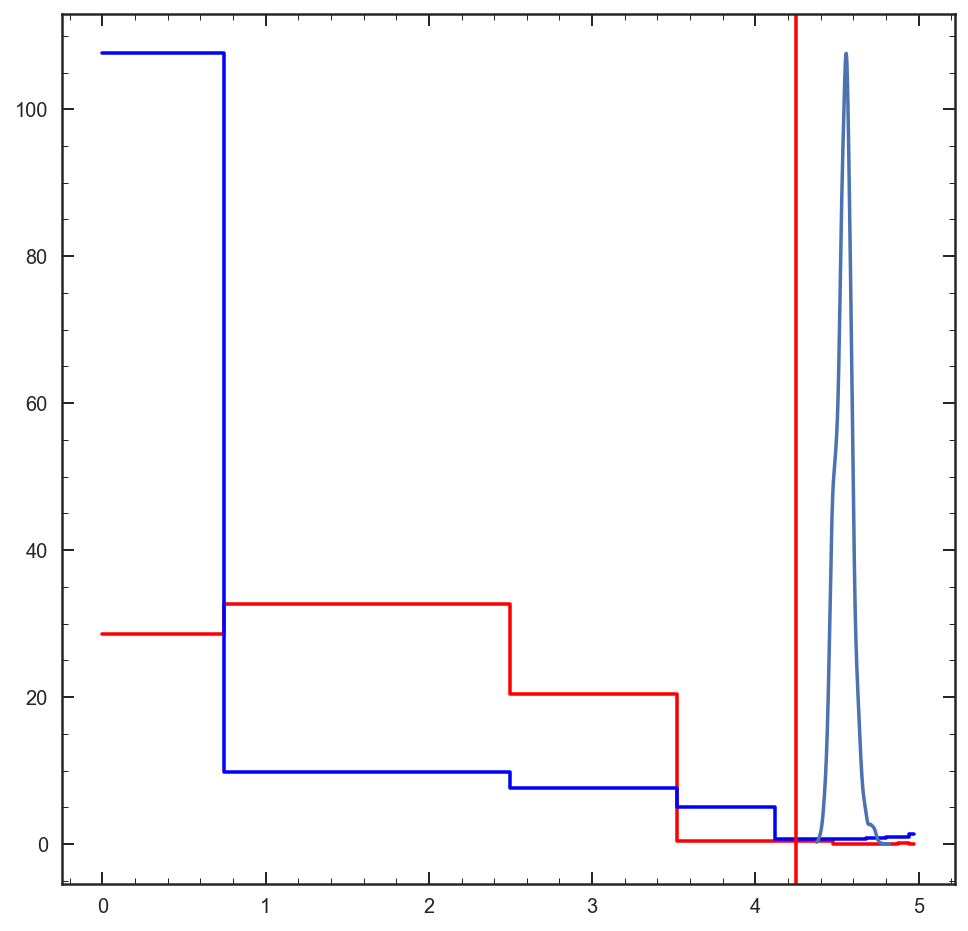

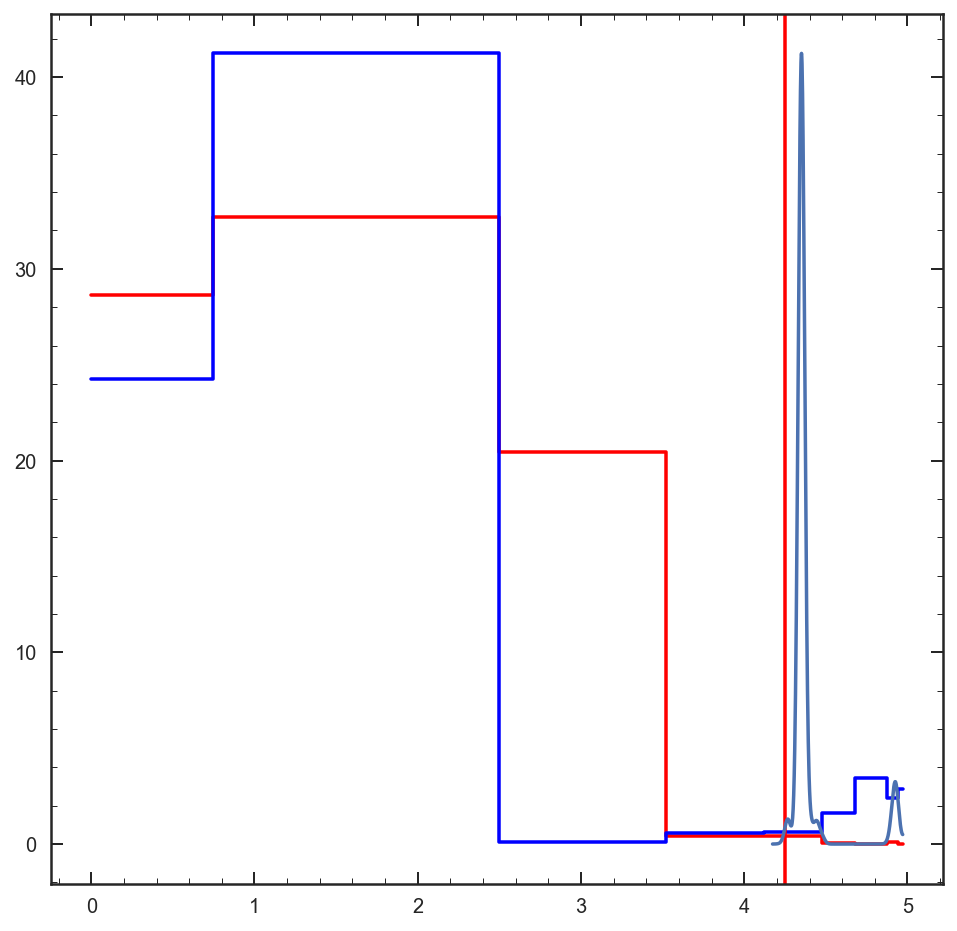

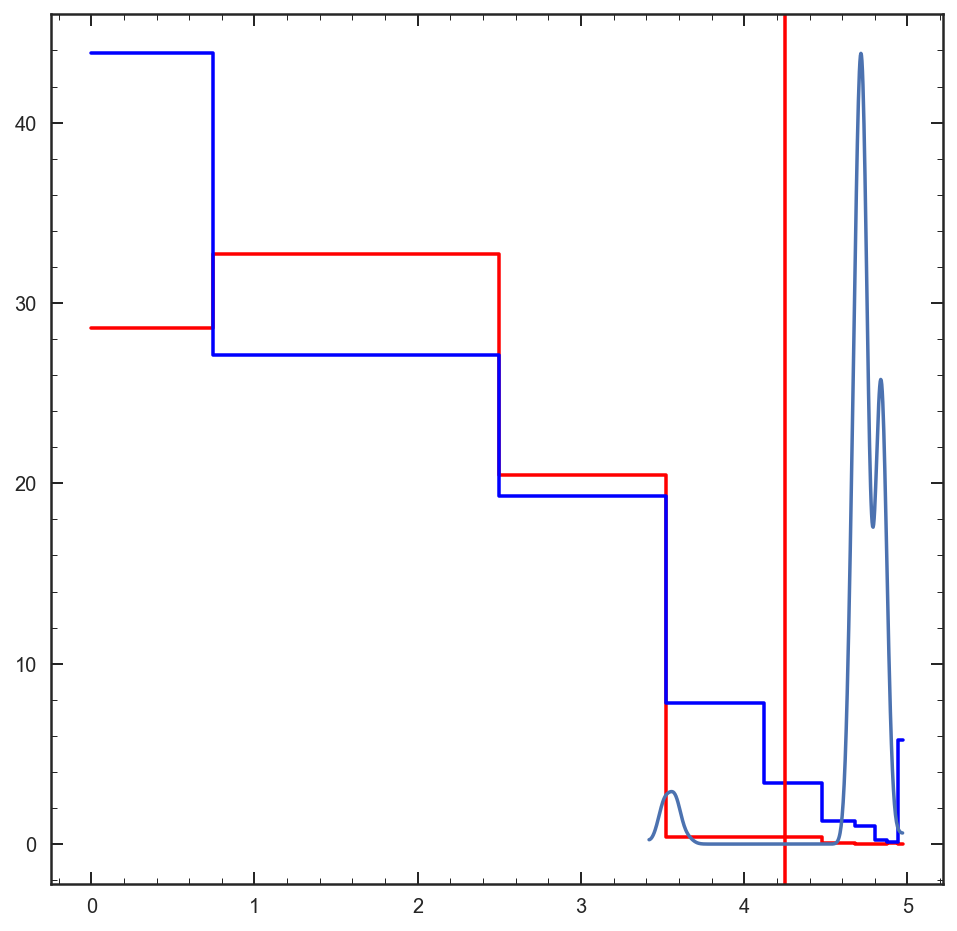

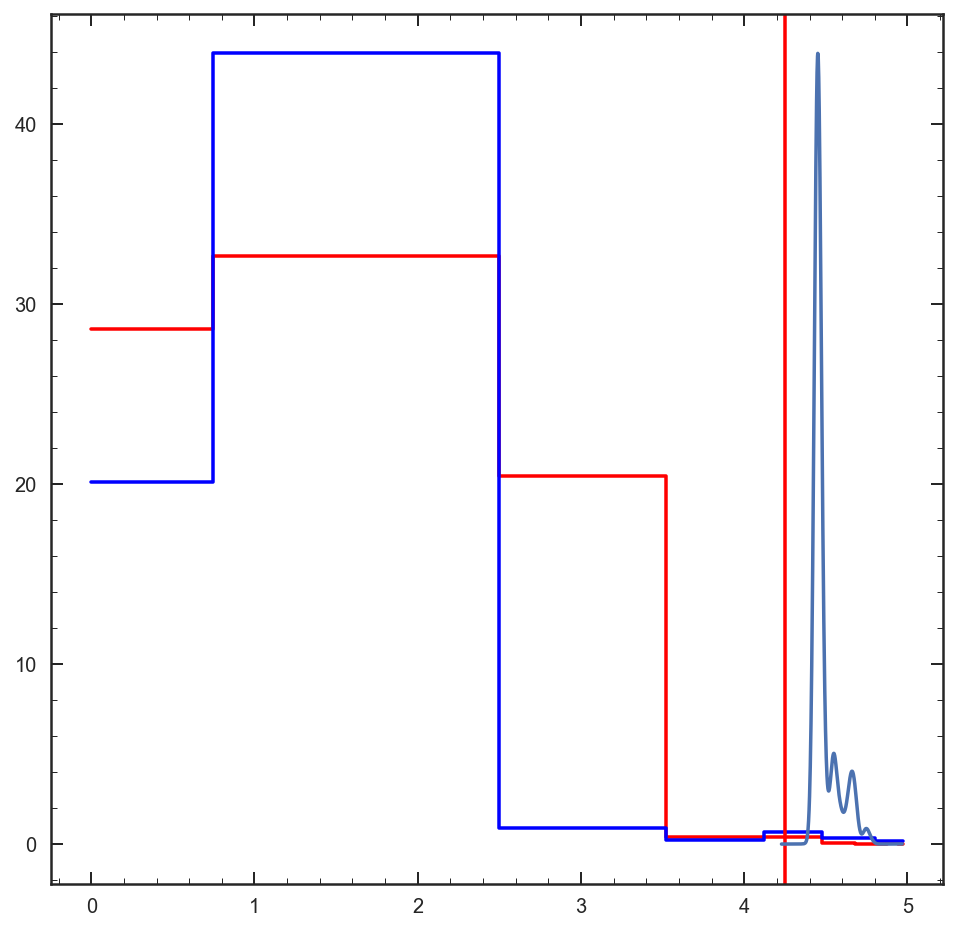

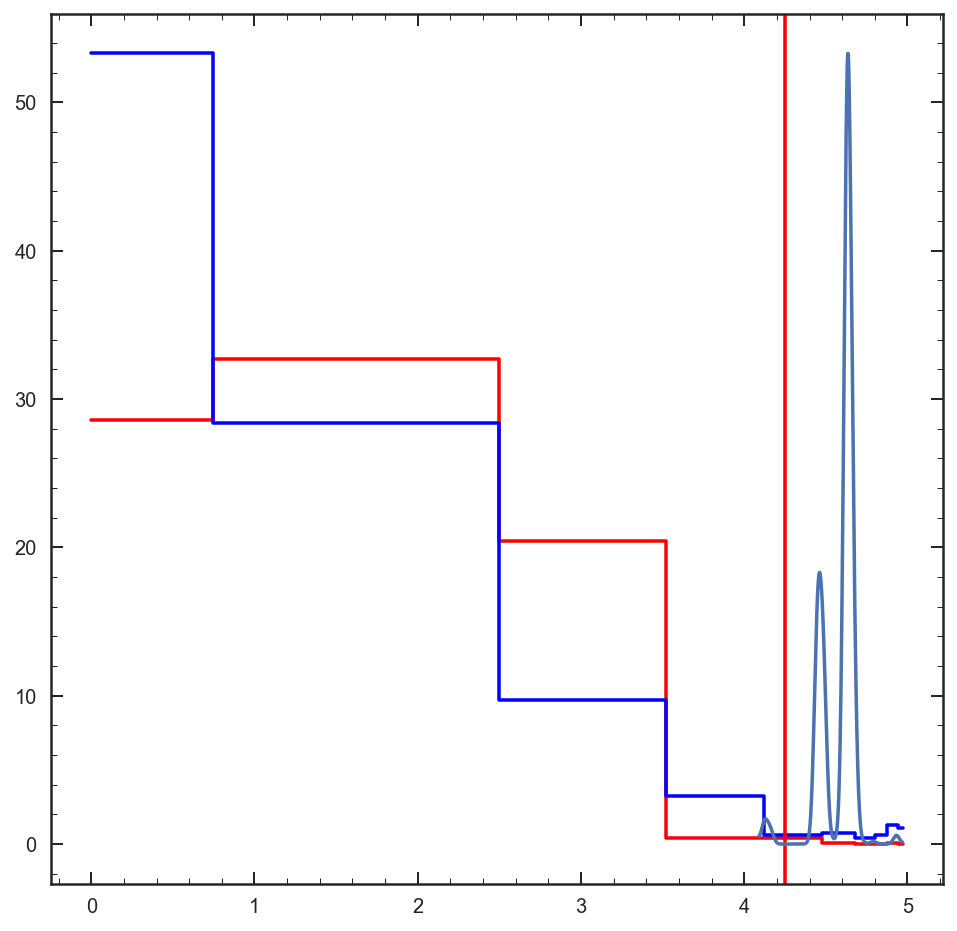

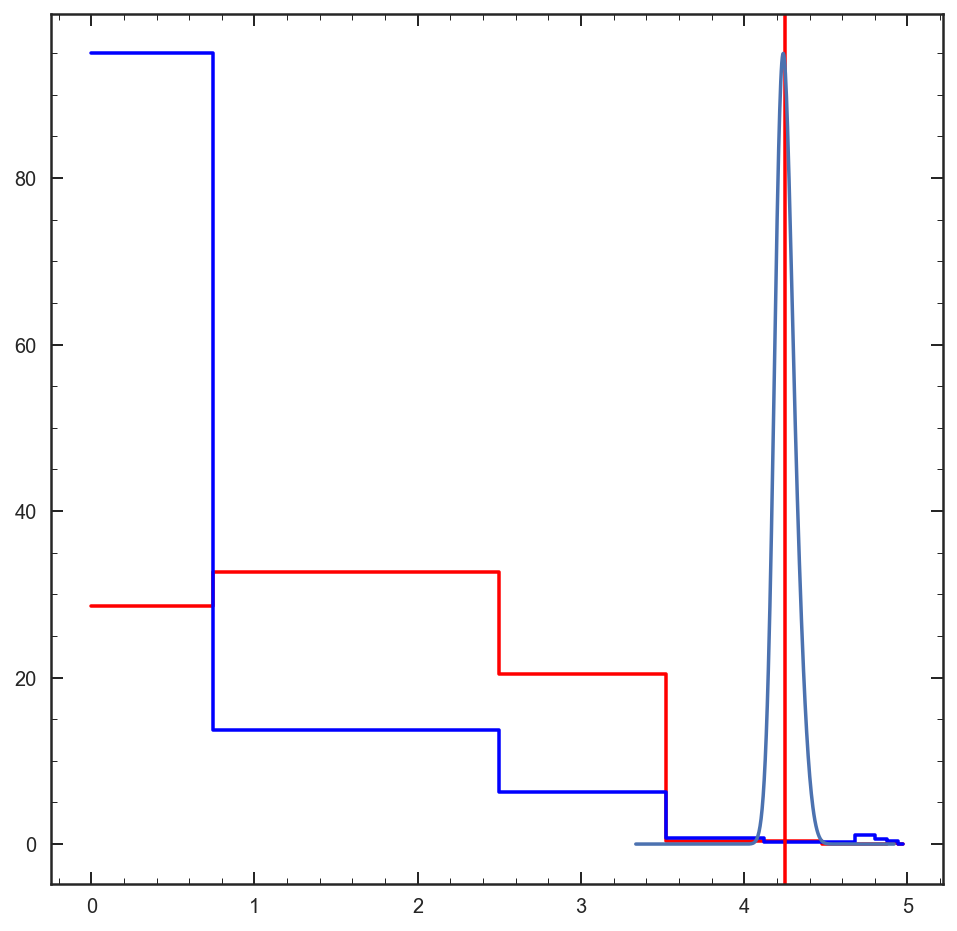

In [89]:
tab_sfh = np.array([0.7, 0.8, 0.5, 0.01, 0.01, 0.001, 0.00001, 0.0002, 0.002, 0.0001])
plt.figure(figsize=[8,8])

for i in range(10):
#     i=0
    md = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_{0}_Pt{1}.npy'.format(i+1,ii+1))
        md[ii] = t[pt == max(pt)]

    t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_{0}_Plm.npy'.format(i+1))
    md_mass = t[pt == max(pt)]
    t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_{0}_Pa.npy'.format(i+1))

    sc_md = scale_sfr(md,LBT,md_mass)

    plt.figure(figsize=[8,8])
    plt.step(np.append(0,LBT), np.append(sc_tab_sfh[0], sc_tab_sfh),'r')
    plt.step(np.append(0,LBT), np.append(sc_md[0],sc_md), 'b')
    plt.axvline(4.25, color = 'r')
    plt.plot(t,pt / max(pt) * max(sc_md))


# for i in range(10):
#     md = np.zeros(10)

#     for ii in range(10):
#         t,pt = np.load('../data/posteriors/sim_test_tab_to_tab_continuity_prior_multi_metal_{0}_Pt{1}.npy'.format(i+1,ii+1))
#         md[ii] = t[pt == max(pt)]
#     plt.figure(figsize=[8,8])
#     plt.step(np.append(0,LBT), np.append(tab_sfh[0], tab_sfh),'r')
#     plt.step(np.append(0,LBT), np.append(md[0],md), 'k')


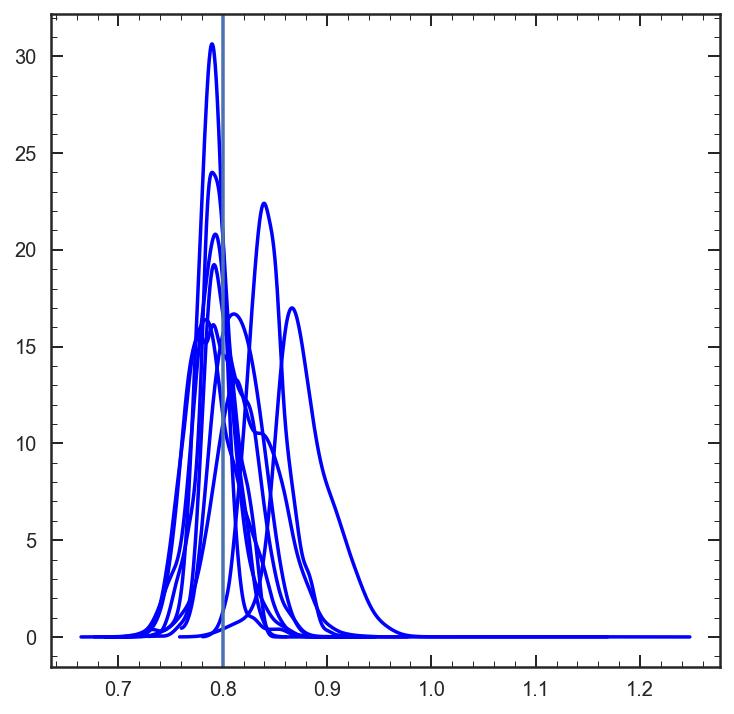

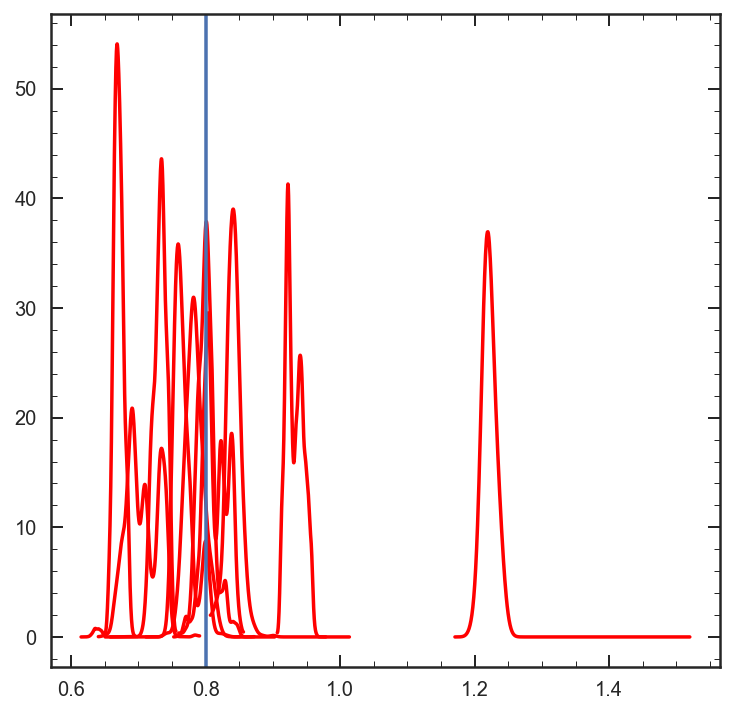

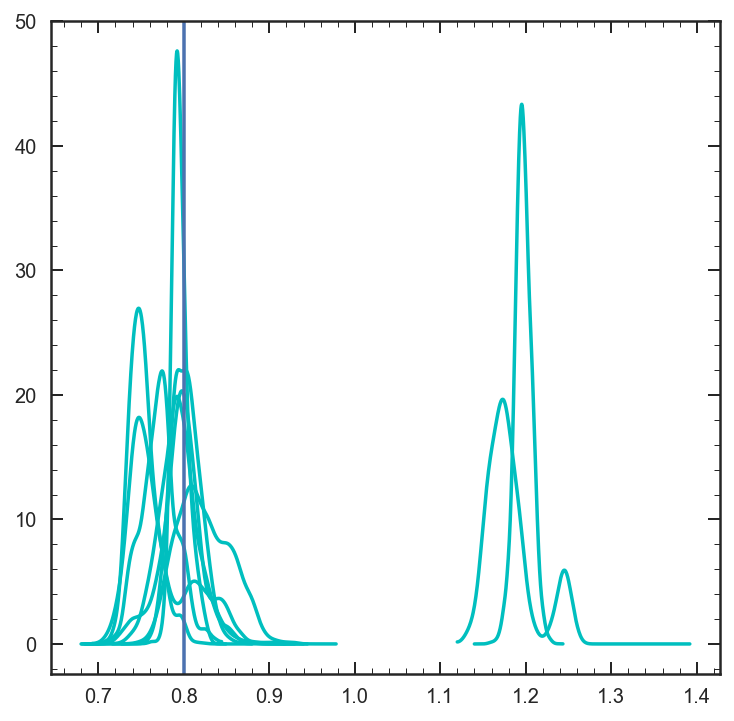

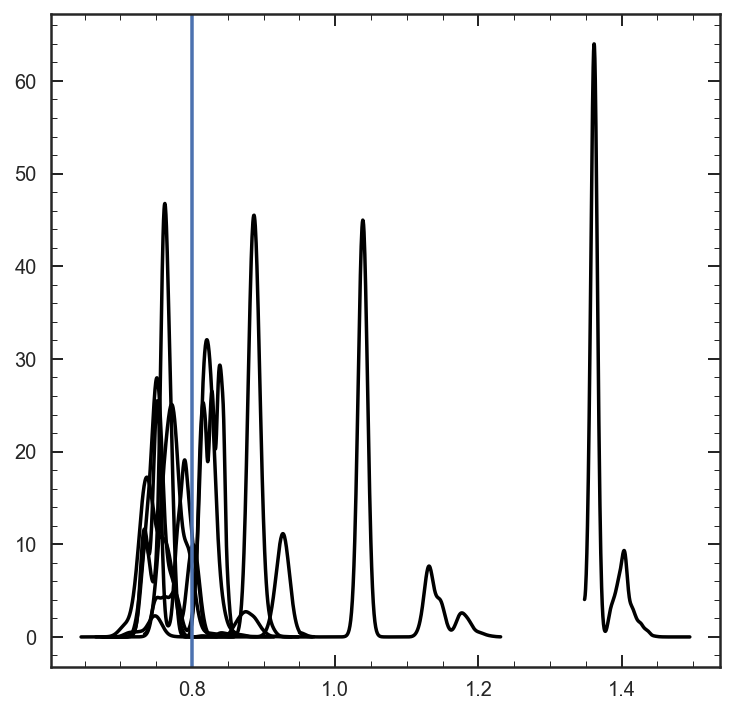

In [143]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(0.8)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(0.8)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(0.8)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,0], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(0.8)

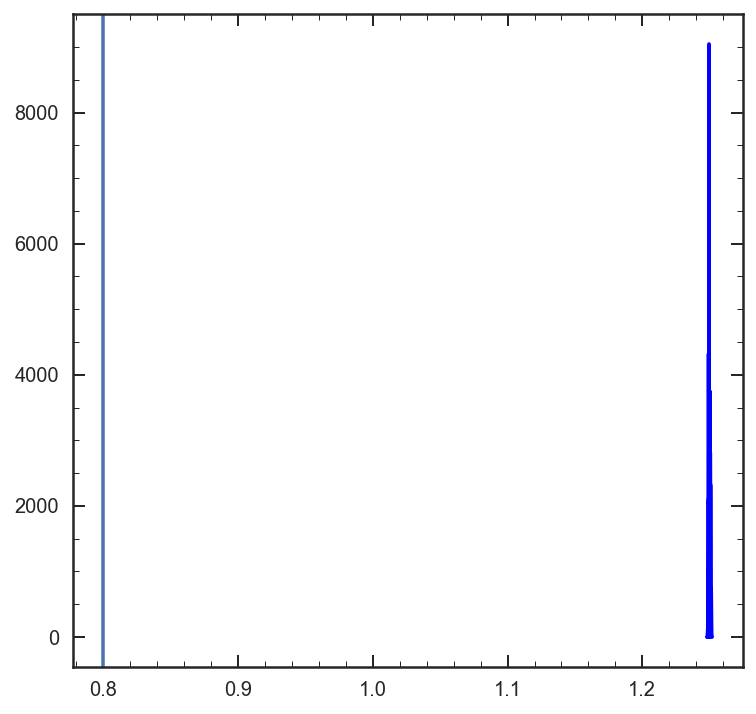

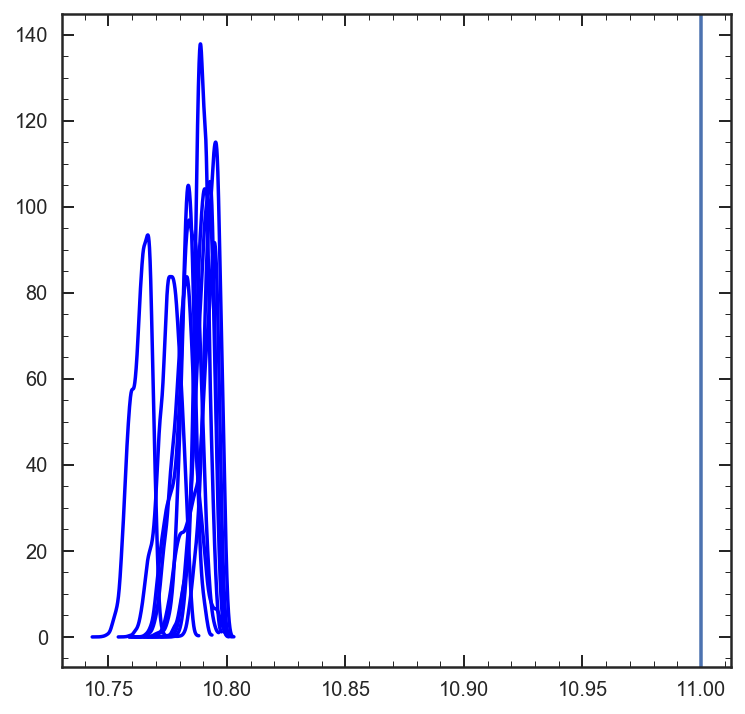

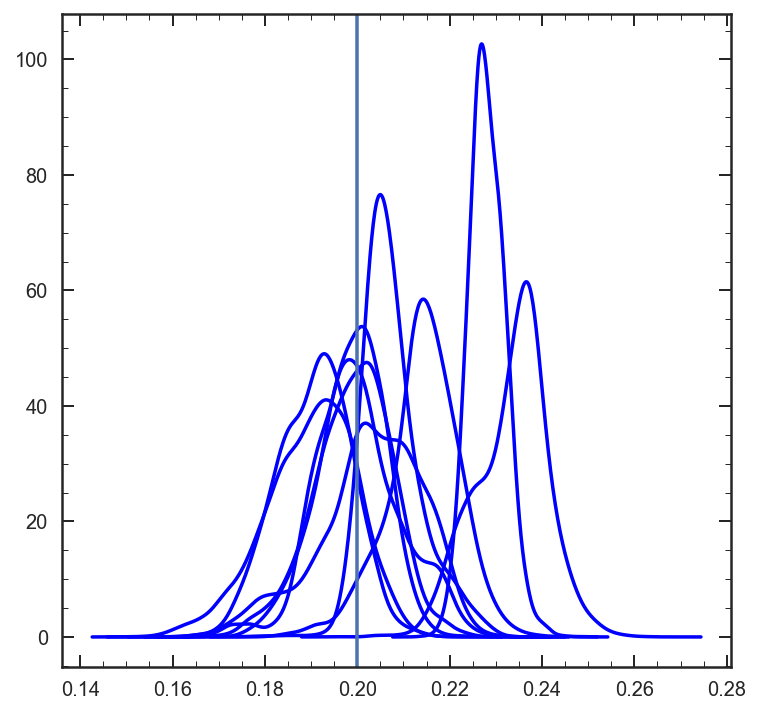

In [95]:
plt.figure(figsize=[6,6])
for i in range(10):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_{0}_PZ.npy'.format(i+1))
    
    plt.plot(m,Pm,'b')
plt.axvline(0.8)
    
plt.figure(figsize=[6,6])
for i in range(10):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_{0}_Plm.npy'.format(i+1))
    
    plt.plot(m,Pm,'b')
plt.axvline(11)


plt.figure(figsize=[6,6])
for i in range(10):
    m,Pm = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_{0}_Pd.npy'.format(i+1))
    
    plt.plot(m,Pm,'b')
plt.axvline(0.2)

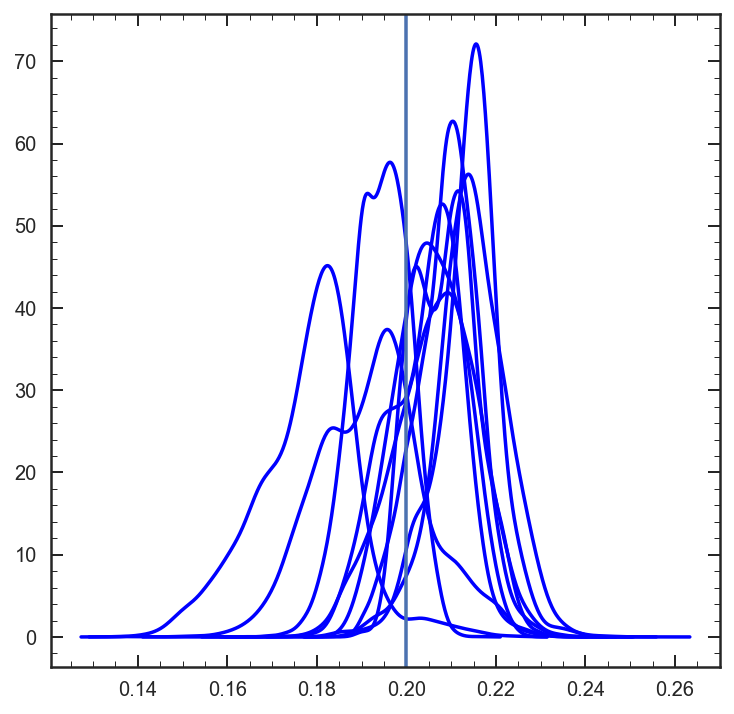

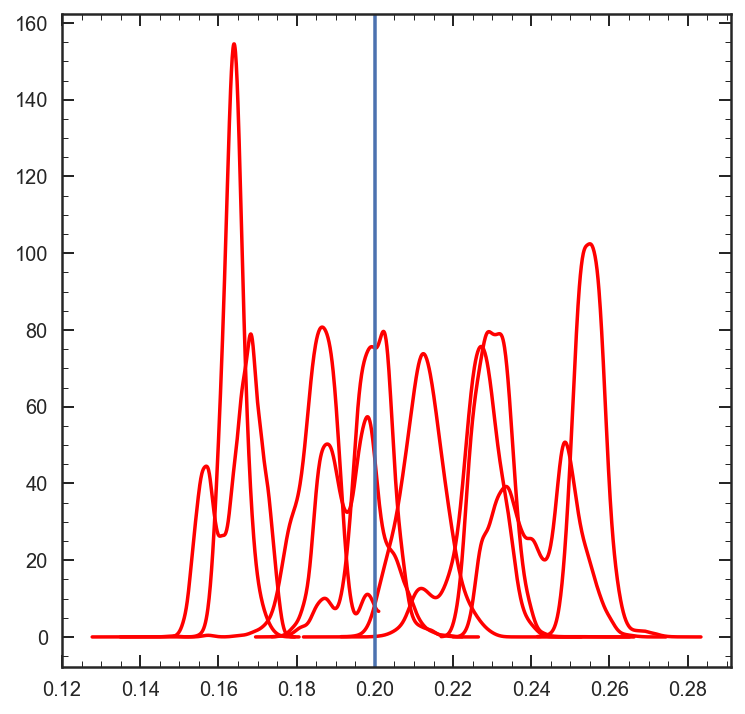

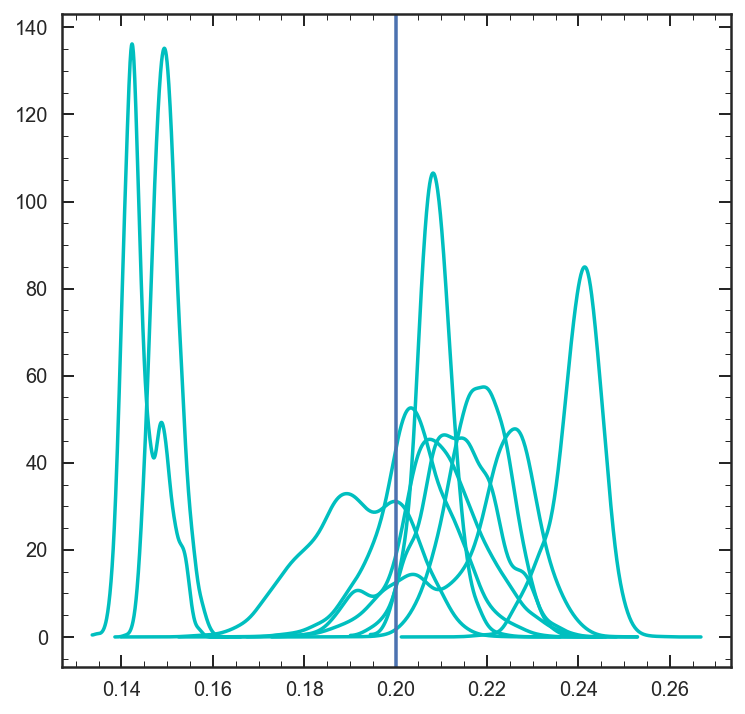

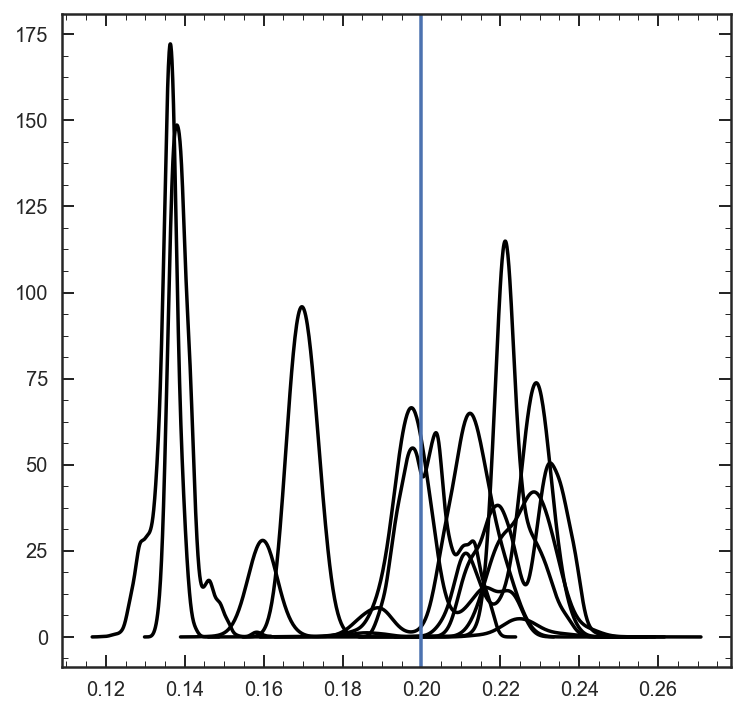

In [145]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(0.2)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(0.2)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(0.2)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,13], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(0.2)


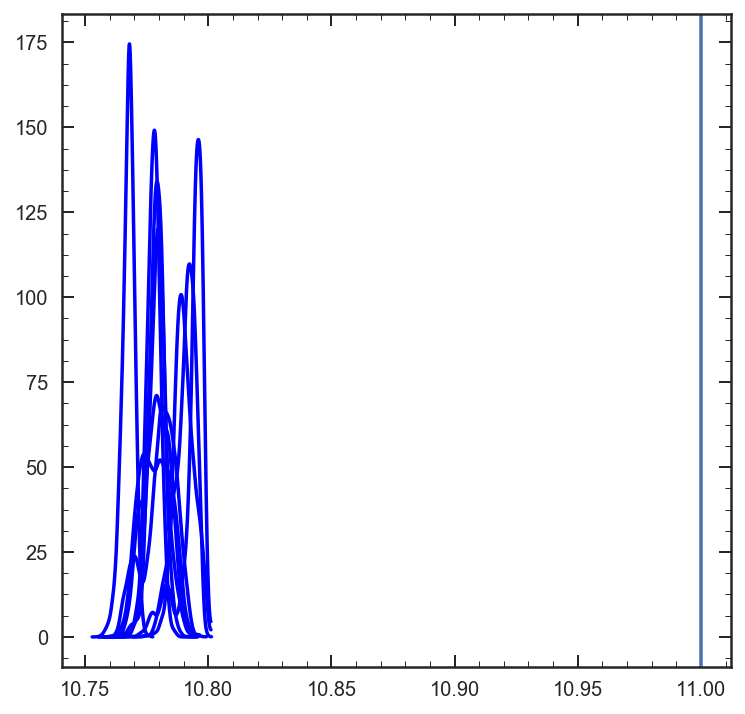

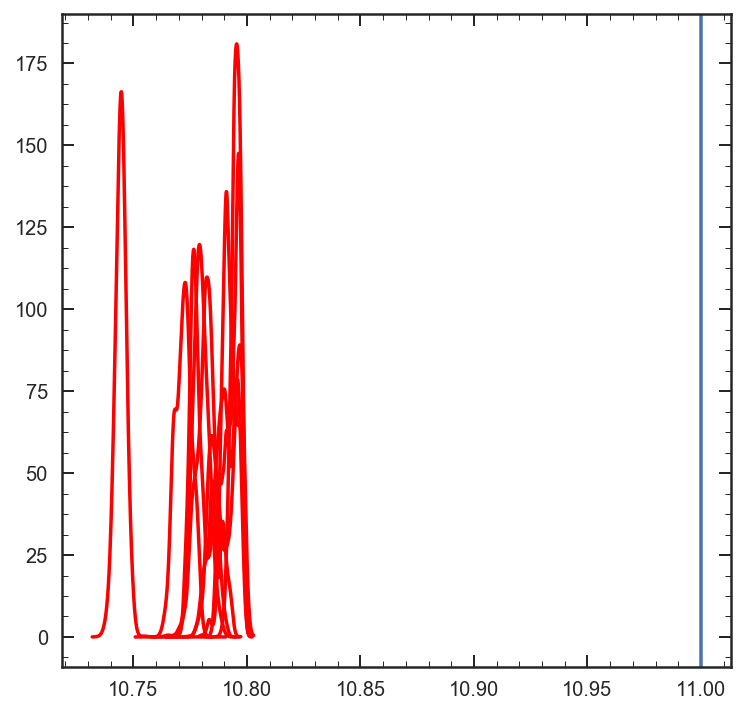

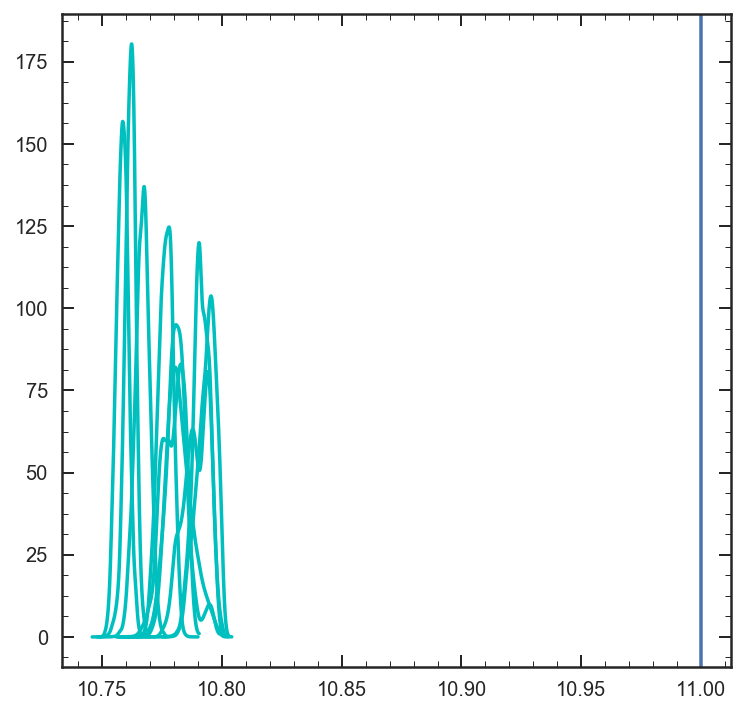

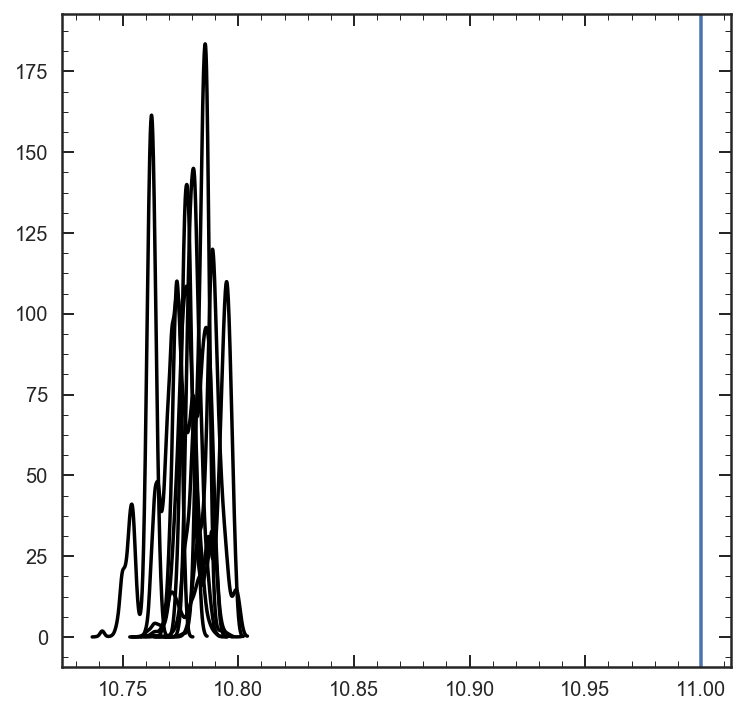

In [146]:
plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_{0}.npy'.format(i+1)).item()
    m,Pm = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(m,Pm,'b')
plt.axvline(11)
    
plt.figure(figsize=[6,6])    
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_balls_{0}.npy'.format(i+1)).item()
    b,Pb = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(b,Pb,'r')

plt.axvline(11)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_single_{0}.npy'.format(i+1)).item()
    s,Ps = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)

    plt.plot(s,Ps,'c')
plt.axvline(11)

plt.figure(figsize=[6,6])
for i in range(10):
    dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_cubes_{0}.npy'.format(i+1)).item()
    c,Pc = Get_posterior(dres.samples[:,14], dres.logwt, dres.logz)
    
    plt.plot(c,Pc,'k')
plt.axvline(11)

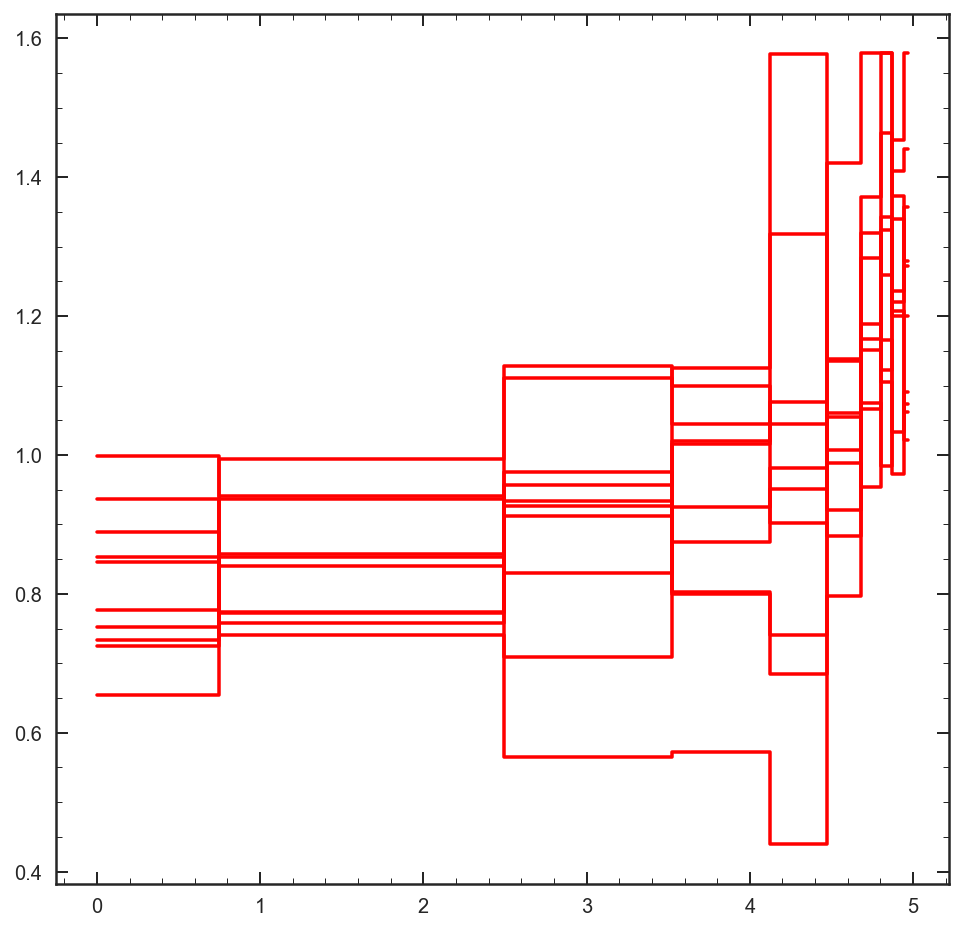

In [16]:
plt.figure(figsize=[8,8])

for i in range(10):
    md = np.zeros(10)
    le = np.zeros(10)
    he = np.zeros(10)

    for ii in range(10):
        t,pt = np.load('../data/posteriors/sim_test_delay_to_tab_continuity_prior_multi_metal_{0}_Pm{1}.npy'.format(i+1,ii+1))
    
#         md[ii], le[ii], he[ii] = Highest_density_region(pt,t)
        md[ii] = t[pt == max(pt)]

#     plt.figure(figsize=[8,8])
    plt.step(np.append(0,LBT), np.append(md[0],md), 'r')
#     plt.fill_between(np.append(0,LBT),np.append(md[0],md) - np.append(le[0],le),
#                      np.append(md[0],md) + np.append(he[0],he), step = 'pre',alpha = .3)

In [17]:
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

In [31]:
Zsampl = np.random.rand(10)
stdZ = (0.03 * Zsampl) / 0.019
logZ = stats.t.ppf( q = Zsampl, loc = 0, scale = 0.2, df =3.)

In [40]:
def logZ_to_zratio(logZ = None, agebins=None):
    nbins = agebins.shape[0] 
    Zratios = 10**np.clip(logZ,-1,1) # clip maximum and minimum values
    coeffs = np.array([ (1. / np.prod(Zratios[:i])) for i in range(nbins)])

    metals = np.clip(coeffs  / coeffs.sum() * 0.2 /0.019, 0.002 / 0.019, 0.03 / 0.019)
    
    return metals

In [33]:
tst = logZ_to_zratio(logZ,agebins)[::-1]

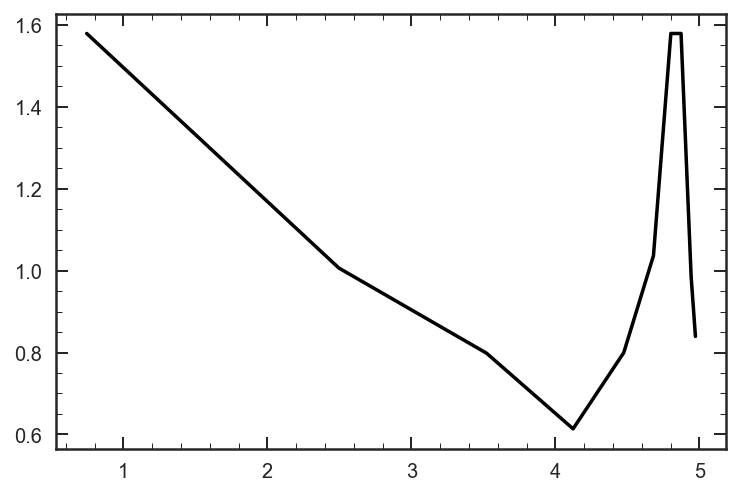

In [34]:
# plt.plot(LBT, stdZ)
# plt.plot(LBT, Zratios,'r')
plt.plot(LBT, tst,'k')
# plt.ylim(0.002 / 0.019, 0.03 / 0.019)

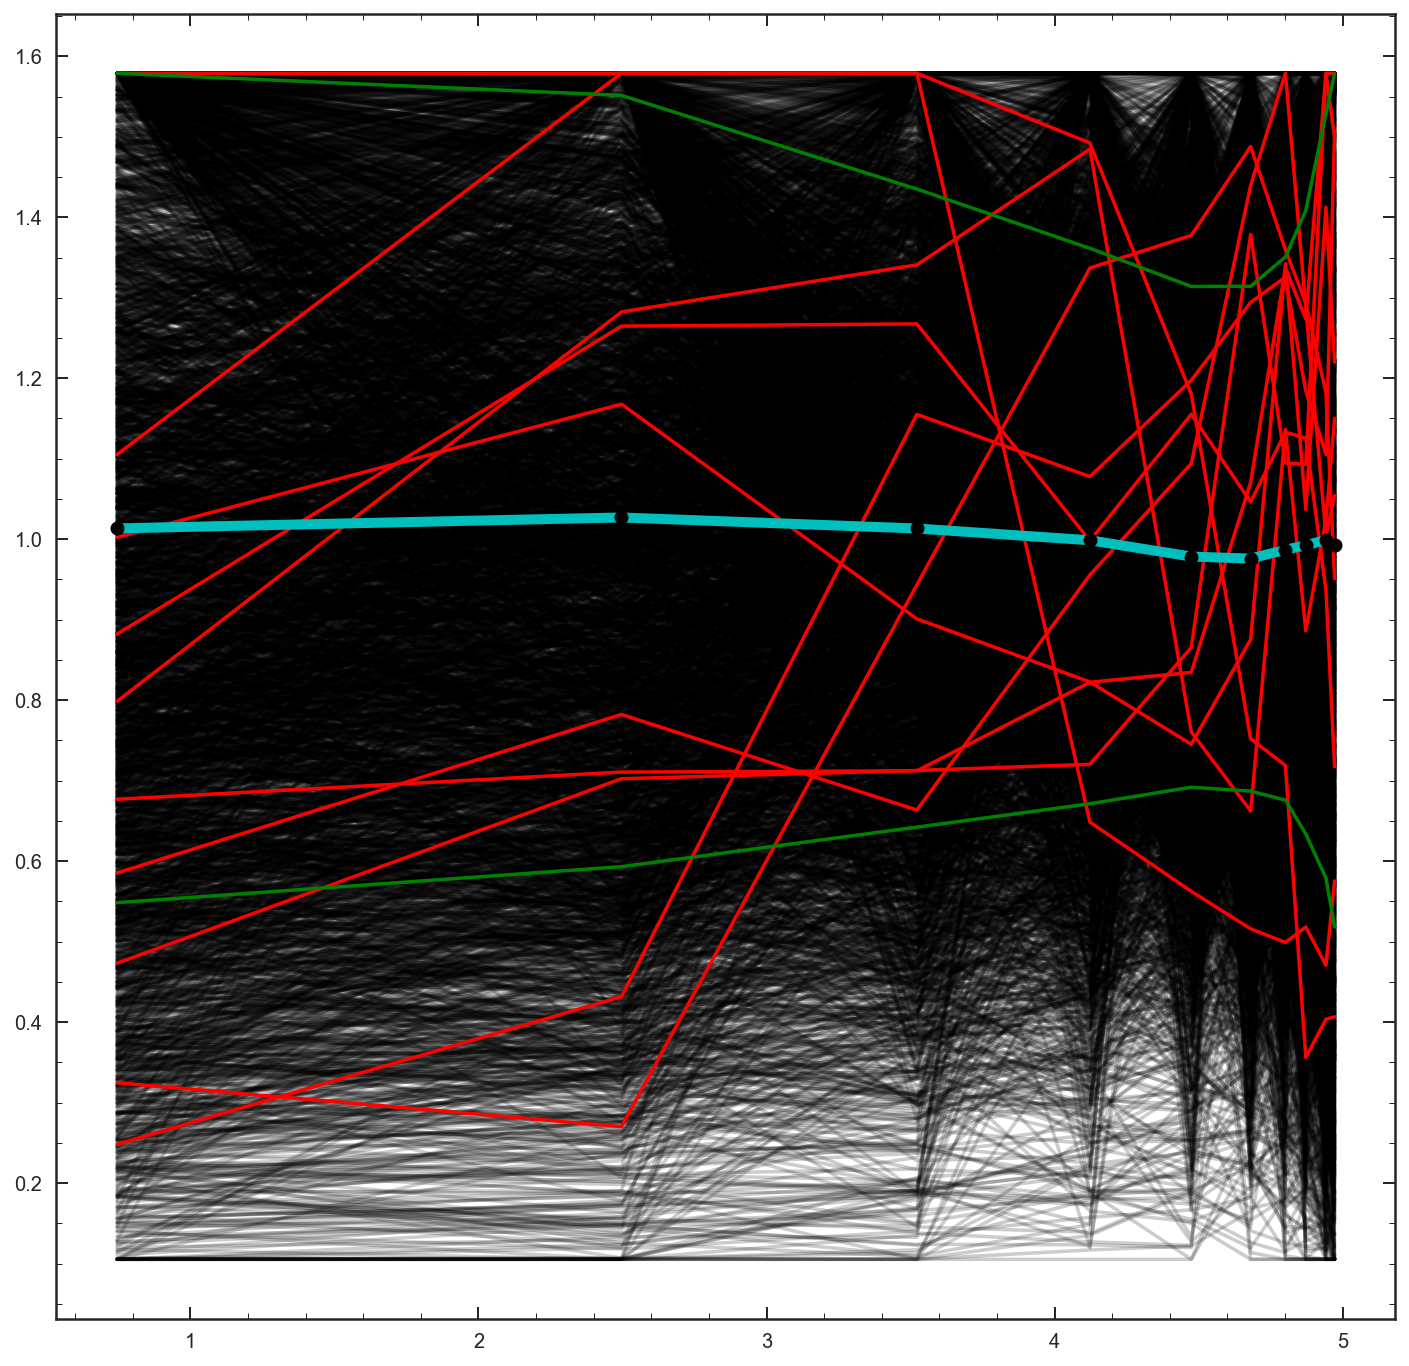

In [41]:
sampl_grid = np.zeros([len(tst),5000])


plt.figure(figsize=[12,12])

for i in range(5000):
    Zsampl = np.random.rand(10)
    logZ = stats.t.ppf( q = Zsampl, loc = 0, scale = 0.1, df =3.)
    
    tst = logZ_to_zratio(logZ,agebins)[::-1]
    sampl_grid.T[i] = tst
    plt.plot(LBT, tst,'k', alpha = 0.2)
for i in range(10):
    Zsampl = np.random.rand(10)
    logZ = stats.t.ppf( q = Zsampl, loc = 0, scale = 0.1, df =3.)
    
    tst = logZ_to_zratio(logZ,agebins)[::-1]
    plt.plot(LBT, tst,'r')
    
plt.plot(LBT, np.percentile(sampl_grid,50,axis=1),'c', linewidth = 5)
plt.plot(LBT, np.percentile(sampl_grid,50,axis=1),'ko', linewidth = 5)
plt.plot(LBT, np.percentile(sampl_grid,16,axis=1),'g')
plt.plot(LBT, np.percentile(sampl_grid,84,axis=1),'g')

In [37]:
x = np.arange(-1,1,0.001)
Px = stats.t.pdf(x, loc = 0, scale = 0.1, df =3.)
Px2 = stats.t.pdf(x, loc = 0, scale = 0.3, df =2.)

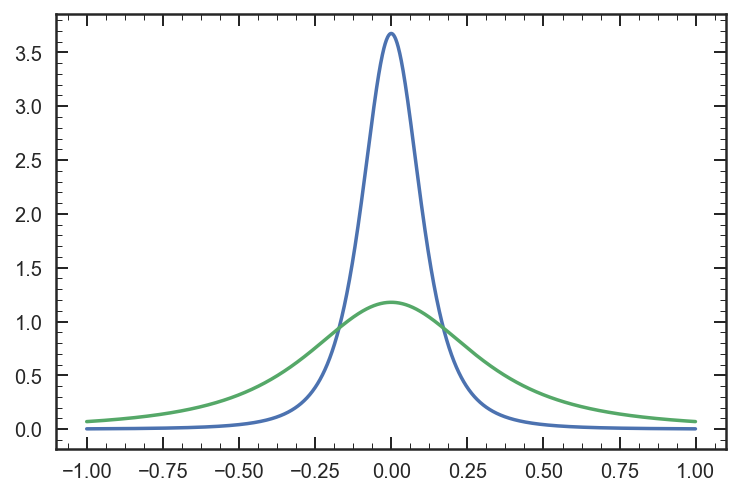

In [38]:
plt.plot(x,Px)
plt.plot(x,Px2)

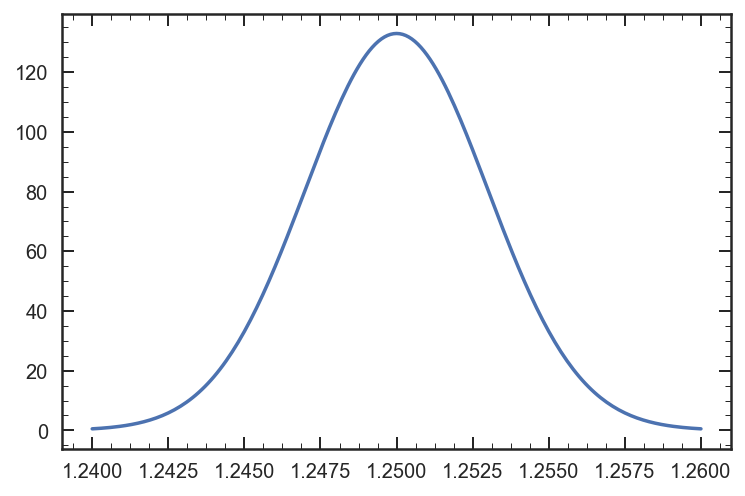

In [175]:
x = np.arange(1.24,1.26,0.0001)

plt.plot(x,stats.norm.pdf(x,loc = specz, scale = 0.003))


In [178]:
z= stats.norm.ppf(np.random.rand(1),loc = 10.75, scale = 0.5)

In [191]:
dres = np.load('../data/out_dict/sim_test_delay_to_tab_continuity_prior_multi_metal_6.npy').item()

(<Figure size 864x5184 with 48 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a68a0d0b8>,
       dtype=object))

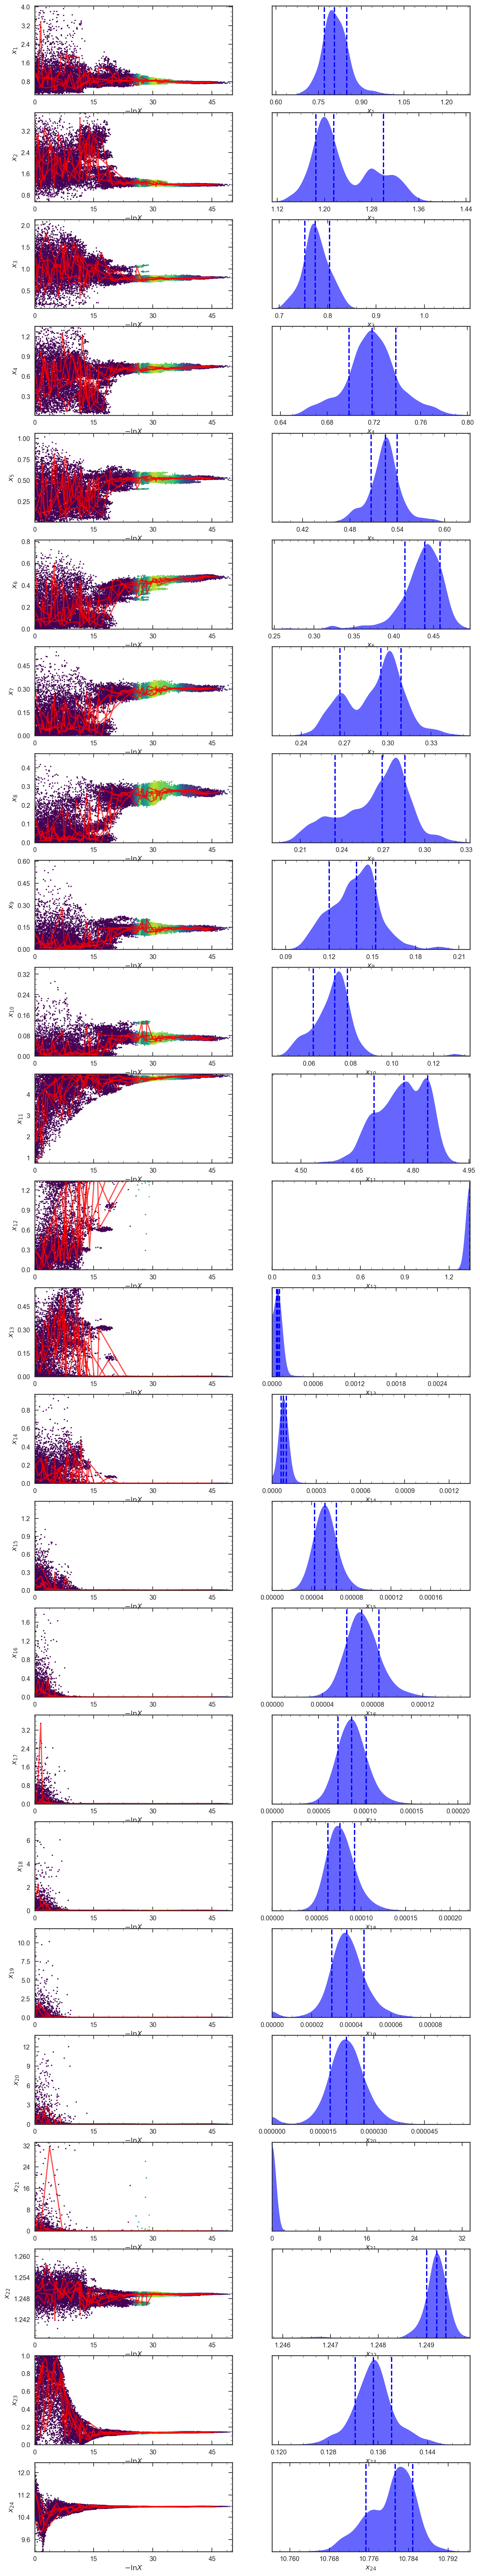

In [192]:
dyplot.traceplot(dres, truths=None, truth_color='black',
                             show_titles=False, title_kwargs={'fontsize': 5, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5))

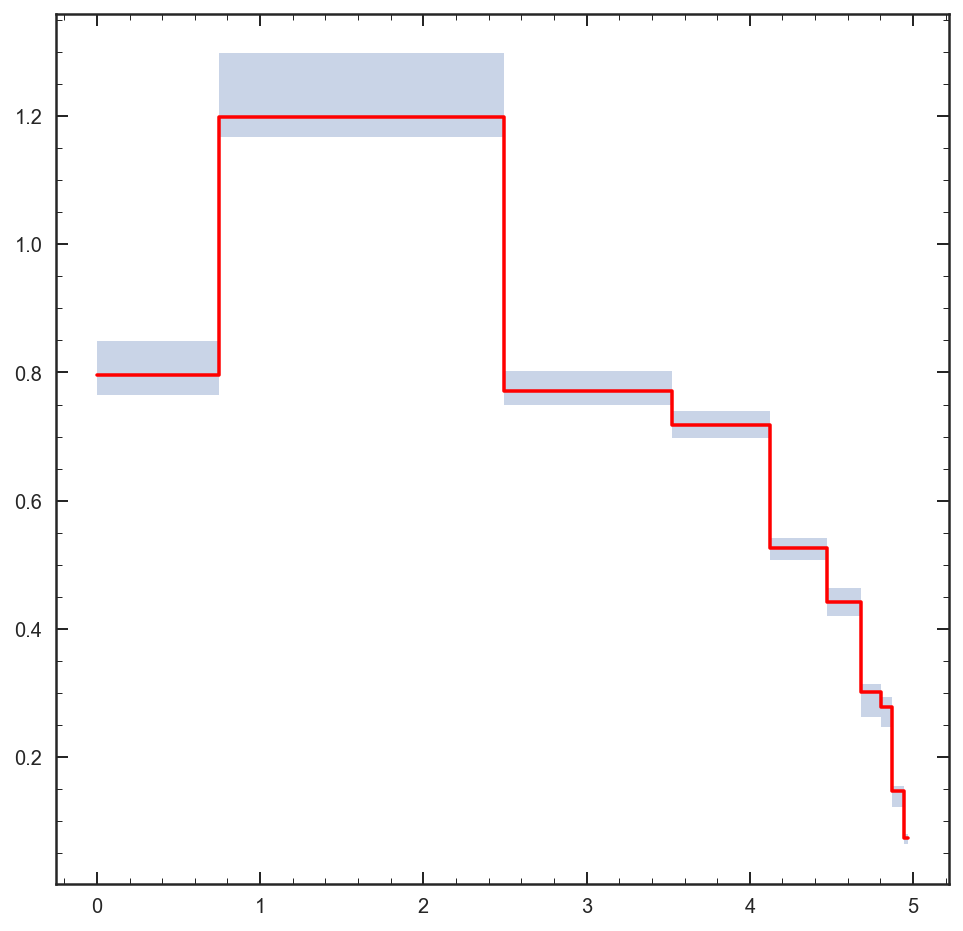

In [193]:
md = np.zeros(10)
le = np.zeros(10)
he = np.zeros(10)

for ii in range(10):
    t,pt = Get_posterior(dres.samples[:,ii],dres.logwt,dres.logz)
    md[ii], le[ii], he[ii] = Highest_density_region(pt,t)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(md[0],md), 'r')
plt.fill_between(np.append(0,LBT),np.append(md[0],md) - np.append(le[0],le),
                 np.append(md[0],md) + np.append(he[0],he), step = 'pre',alpha = .3)

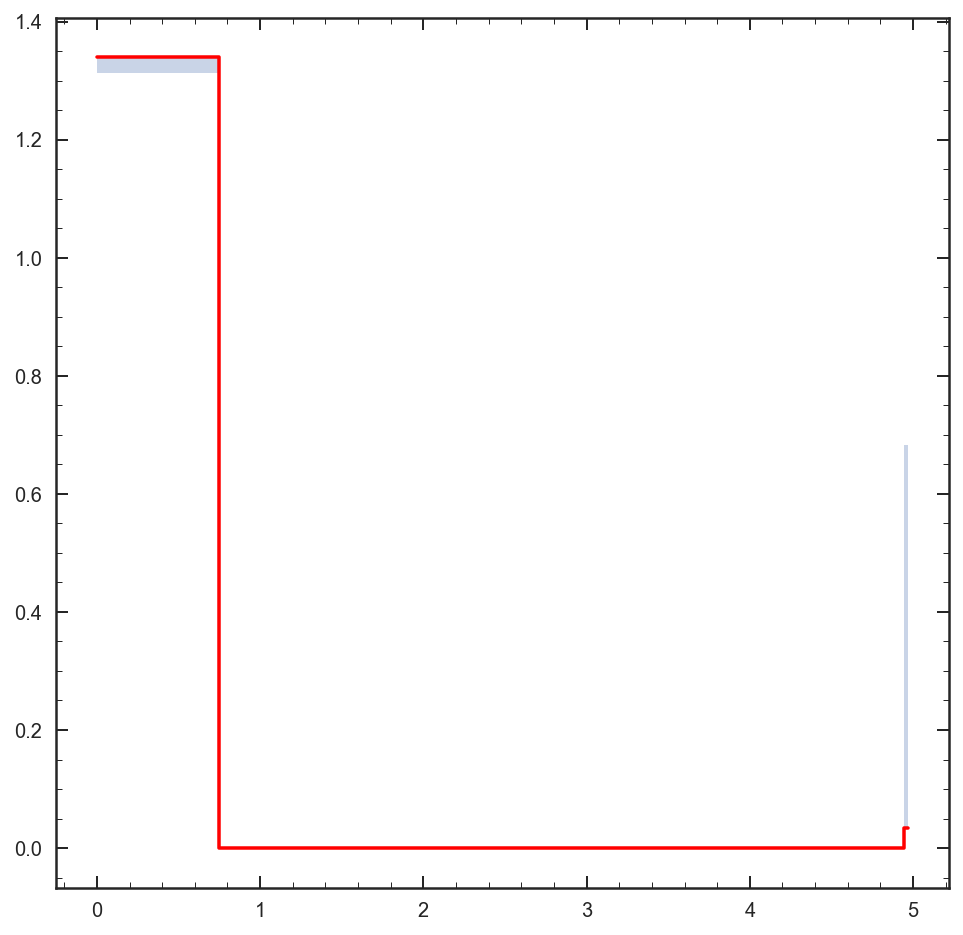

In [202]:
md = np.zeros(10)
le = np.zeros(10)
he = np.zeros(10)

for ii in range(10):
    t,pt = Get_posterior(dres,ii+11)
    md[ii], le[ii], he[ii] = Highest_density_region(pt,t)

plt.figure(figsize=[8,8])
plt.step(np.append(0,LBT), np.append(md[0],md), 'r')
plt.fill_between(np.append(0,LBT),np.append(md[0],md) - np.append(le[0],le),
                 np.append(md[0],md) + np.append(he[0],he), step = 'pre',alpha = .3)

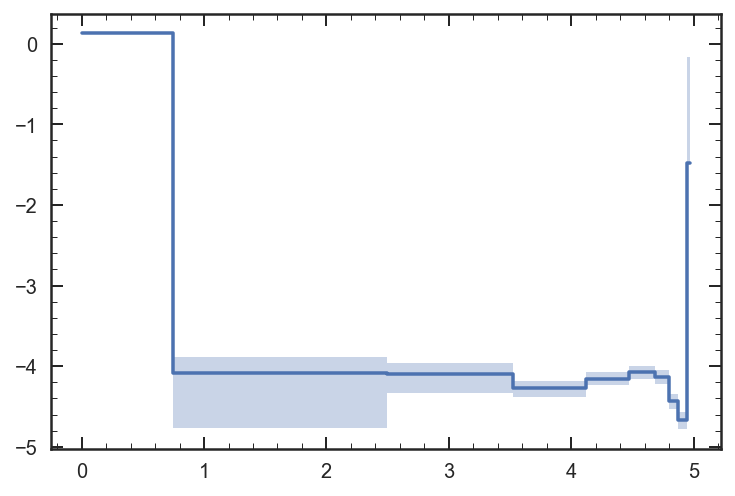

In [195]:
plt.step(np.append(0,LBT), np.log10(np.append(md[0],md)))
plt.fill_between(np.append(0,LBT),np.log10(np.append(md[0],md) - np.append(le[0],le)),
                 np.log10(np.append(md[0],md) + np.append(he[0],he)), step = 'pre',alpha = .3)

#new test - do not perturb

1) tab to delay

2) ** tab to delay +

3) delay to tab

4) delay to tab - 7 age bins

5) delay to tab - scale mass

6) delay to tab - scale spectra

3) tab to tab

4) tab to tab - 7 age bins

5) tab to tab - scale mass

6) tab to tab - scale spectra

In [45]:
#####SET SIM#####
specz = 1.25

sim2 = Gen_spec('GND', 21156, 1.25257,
               g102_lims=[8300, 11288], g141_lims=[11288, 16500],mdl_err = False,
            phot_errterm = 0.0, decontam = False) 

sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 4, tau=0.1, dust_type = 1)
sp.params['dust2'] =0.2
sp.params['dust1'] =0.2
sp.params['tau'] =0.3
sp.params['logzsol'] = np.log10(0.8)

wave2, flux2 = sp.get_spectrum(tage = 4.25, peraa = True)

mass_perc2 = sp.stellar_mass

D_l = cosmo.luminosity_distance(specz).value # in Mpc
conv = 3.086E24
lsol_to_fsol = 3.839E33

sim2.Make_sim(wave2, flux2 * 10**11* lsol_to_fsol / (4 * np.pi * (D_l*conv)**2), specz, perturb = False)

#####RESET FSPS#####
sp = fsps.StellarPopulation(imf_type = 2, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(1), sfh = 3, dust_type = 1)

############
###priors###
lages = [0,9.0,9.1,9.2,9.3,9.4,9.5,9.6,9.7,9.8,9.9]

tuniv = Oldest_galaxy(specz)
nbins = len(lages) - 1

tbinmax = (tuniv * 0.85) * 1e9
lim1, lim2 = 7.4772, 8.0
agelims = [0,lim1] + np.linspace(lim2,np.log10(tbinmax),nbins-2).tolist() + [np.log10(tuniv*1e9)]
agebins = np.array([agelims[:-1], agelims[1:]]).T

LBT = (10**agebins.T[1][::-1][0] - 10**agebins.T[0][::-1])*1E-9

time_per_bin = np.diff(10**agebins, axis=-1)[:,0]

agelim = Oldest_galaxy(specz)

############
#likelihood#

def Gather_grism_sim_data(spec):
    wvs = []
    flxs = []
    errs = []
    beams = []
    trans = []
    
    if spec.g102:
        wvs.append(spec.Bwv)
        flxs.append(spec.SBfl)
        errs.append(spec.SBer)
        beams.append(spec.Bbeam)
        trans.append(spec.Btrans)
    
    if spec.g141:
        wvs.append(spec.Rwv)
        flxs.append(spec.SRfl)
        errs.append(spec.SRer)
        beams.append(spec.Rbeam)
        trans.append(spec.Rtrans)

    return np.array([wvs, flxs, errs, beams, trans])

def forward_model_all_beams(beams, trans, in_wv, model_wave, model_flux):
    FL = np.zeros([len(beams),len(in_wv)])

    for i in range(len(beams)):
        mwv, mflx = forward_model_grism(beams[i], model_wave, model_flux)
        FL[i] = interp1d(mwv, mflx)(in_wv)
        FL[i] /= trans[i]

    return np.mean(FL.T,axis=1)

def Full_forward_model(spec, wave, flux, specz):
    Gmfl = []
    
    for i in range(len(wvs2)):
        Gmfl.append(forward_model_all_beams(beams2[i], trans2[i], wvs2[i], wave * (1 + specz), flux))

    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)

    return np.array(Gmfl), Pmfl


def Full_fit(spec, Gmfl, Pmfl):
    Gchi = 0
    
    for i in range(len(wvs2)):
        scale = Scale_model(flxs2[i], errs2[i], Gmfl[i])
        Gchi = Gchi + np.sum(((((flxs2[i] / scale) - Gmfl[i]) / (errs2[i] / scale))**2))

    Pchi = np.sum((((spec.SPflx - Pmfl) / spec.SPerr)**2))
    
    return Gchi, Pchi

def Full_scale(spec, Pmfl):
    return Scale_model(spec.SPflx, spec.SPerr, Pmfl)


wvs2, flxs2, errs2, beams2, trans2 = Gather_grism_sim_data(sim2)

# def tab_L(X):
#     m, a, t1, t2, t3, t4, t5, t6, t7, t8, t9, t10, z, d = X
    
#     sp.params['dust2'] = d
#     sp.params['dust1'] = d
#     sp.params['logzsol'] = np.log10(m)

#     sp.set_tabular_sfh(LBT,np.array([t1, t2, t3, t4, t5, t6, t7, t8, t9, t10]))
    
#     wave, flux = sp.get_spectrum(tage = a, peraa = True)

#     Gmfl, Pmfl = Full_forward_model(sim2, wave, flux, z)
          
#     PC= Full_scale(sim2, Pmfl)

#     Gchi, Pchi = Full_fit(sim2, PC*Gmfl, PC*Pmfl)
                  
#     return -0.5 * (Gchi + Pchi)


/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2


In [46]:
sp.params['dust2'] = 0.2
sp.params['dust1'] = 0.2
sp.params['logzsol'] = np.log10(1)

sp.set_tabular_sfh(LBT,np.array([1, 0.01, 0, 0, 0, 0, 0, 0, 0, 0]))

wave, flux = sp.get_spectrum(tage = 4, peraa = True)

Gmfl, Pmfl = Full_forward_model(sim2, wave, flux, 1.25)

PC= Full_scale(sim2, Pmfl)

Gchi, Pchi = Full_fit(sim2, PC*Gmfl, PC*Pmfl)

print(-0.5 * (Gchi + Pchi))

-257.9453796540214


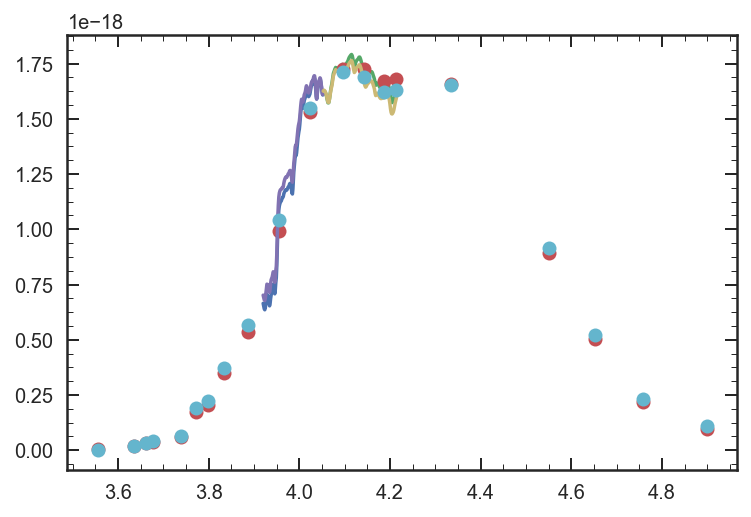

In [47]:
plt.plot(np.log10(sim2.Bwv), sim2.SBfl)
plt.plot(np.log10(sim2.Rwv), sim2.SRfl)
plt.plot(np.log10(sim2.Pwv), sim2.SPflx,'o')

plt.plot(np.log10(sim2.Bwv), PC*Gmfl[0])
plt.plot(np.log10(sim2.Rwv), PC*Gmfl[1])
plt.plot(np.log10(sim2.Pwv), PC*Pmfl,'o')

In [41]:
PC

6.078406479484539e-23